## Learn About The Execution Envrionment

Author : Lei Wang

Date : May 20th, 2019



We could use jupyter as an interface to communicate with remote machine by executing shell commands. Check $PROJECT_ROOT/Readme.md defined below to see how we preapre our executing envrionment.


In colab, your content will not be persistent in the default hdd. Hence you need to use external stroage to persistent your conent. Here we use Google Driver to do that. 

Mask_RCNN trained with massive classes coco dataset is well developed for people detection. In the code, we limit our detection only to 'people' and output detection results as a video. 

We clone a popular Mask_RCNN implementation to our colab hdd and write python codes to run inference for each frame of an uploaded video.

Examples of using opencv to generate detection results and a video is provided. We also show you how to use FFmpeg to generate video from generated images.

Jupyter also provides us with UI components for further demonstration. Rendering point clouds using Three.js powered by webgl, or adding an HTML5 components to show a media cannot be simpler.




##### Check the virtual machine running on

In [1]:
# switch to cpu device
import os
# Our GPU does not have enough memory to run the model
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# https://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

def get_available_gpus():
  local_device_protos = device_lib.list_local_devices()
  return [device_proto for device_proto in local_device_protos if device_proto.device_type == 'GPU']

print(get_available_gpus())

!nvidia-smi

[]
Thu May 21 11:55:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    On   | 00000000:01:00.0  On |                  N/A |
| 43%   38C    P8    21W / 175W |    839MiB /  7959MiB |     26%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GP

##### Make our notebook an active page

Open the development console, type following JS codes into the console and press "Enter"

```js
function RenewConn(Selector){
  document.querySelector(Selector).click() 
}
var query = "colab-connect-button"
// run every 10 miniuts. Please use random time tickets in case that the risk control detector is depolyed to against robot behaviors.
click_mock = 1000 * 60 * 10 + Math.random() * 1000 * 60

global = this // window object
global.prog_id = setInterval(RenewConn(query),click_mock)
// keep prog_id in case that you want to close event dispatching branch by using clearInterval(prog_id) 
// The codes above either increase your activity scores or renew connections by sending signals to the remote
```

The code run asynchronously and prevents google colab page from closing connection to the remote. So you won't interrupted.

Please see details of [Colaboratory Frequency Questions](https://research.google.com/colaboratory/faq.html#idle-timeouts) for details.

If you really want stronger services, instead of abuse of free resources to the public, I recommend you to try [Colab Pro](https://colab.research.google.com/signup?utm_source=faq&utm_medium=link&utm_campaign=how_long_can_nbs_run)

##### Mount Google Driver as an external HDD

In [2]:
HDD="/home/yiakwy"
ROOT="{hdd}/WorkSpace".format(hdd=HDD)
REPO="SEMANTIC_SLAM"
PROJECT_ROOT="{root}/Github/{repo}".format(root=ROOT, repo=REPO)

In [3]:
!cmake --version
!python --version

import tensorflow as tf 
print("tensorflow ver: ", tf.__version__)

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

cmake version 3.9.0

CMake suite maintained and supported by Kitware (kitware.com/cmake).
Python 3.6.10 :: Anaconda, Inc.
tensorflow ver:  2.1.0
Instructions for updating:
non-resource variables are not supported in the long term


## Install BA Solver

Sorry I have some problems to build a g2o alike solver (mostly implemented in c++) in colab (long time to wait for returning) hence I swtich to local environment. Most of codes in this lab could be found in `python/svso`

BA is used a generic framework to refine triangulated coordinates, estimated camera poses in pose graph context. It is wrapper of iterative method to optimize reprojection errors. See below "BundleAdjustment" and "PoseOptimization" (corresponding to PnP solver).

In [4]:
# update on Feb 26 2020
!pip install folium==0.2.1 # downgrade from 0.8.3 to 0.2.1
!pip install -U setuptools
!pip install -U wheel
# !make install -C "$ROOT/Github/coco/PythonAPI"

Requirement already up-to-date: setuptools in /home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages (46.1.3.post20200330)
Requirement already up-to-date: wheel in /home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages (0.34.2)


In [5]:
!pip install PyYAML
!pip install keras
!pip install scikit-image
!pip install imgaug

In [4]:
# alternatively you could add the path to sys.paths without entering into the directory and 
# build your own software system. See Synmantic Vision Supported Tracker implementation
# for example
# %cd "$ROOT/Github/Mask_RCNN"
import os
import sys

def add_path(path):
  path = os.path.abspath(path)
  if path not in sys.path:
    print("loading %s ..." % path)
    sys.path.insert(0, path)
  else:
    print("%s, already exits!" % path)

add_path("{}/Github/Mask_RCNN".format(ROOT))
add_path("{}/Github/Mask_RCNN/mrcnn".format(ROOT))

loading /home/yiakwy/WorkSpace/Github/Mask_RCNN ...
loading /home/yiakwy/WorkSpace/Github/Mask_RCNN/mrcnn ...


## Load Mask_RCNN model

MASK RCNN is not for real time processing. The model is deplyed just for validation of accuracy and visualization.

Later we will use our own model trianed on in house dataset and fine tuned it and deploy it on devices. 

In [5]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Project_base = PROJECT_ROOT

# Note the source code of MaskRCNN has been changed to use tf2.x to tf1.x compatible interface
# see discussion https://github.com/matterport/Mask_RCNN/issues/1797

# Import Mask RCNN
MASK_RCNN_ROOT="{root}/Github/Mask_RCNN".format(root=ROOT)
MASK_RCNN_Dataset_Coco="{mask_rcnn_root}/samples/coco".format(mask_rcnn_root=MASK_RCNN_ROOT)

add_path(MASK_RCNN_ROOT)
add_path(MASK_RCNN_Dataset_Coco)

# Import WorkDir
add_path(Project_base)

from mrcnn import utils
import mrcnn.model as Model
from mrcnn import visualize

import coco

MODEL_DIR = os.path.join(Project_base, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(Project_base, "data/models/coco", "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
  utils.download_trained_weights(COCO_MODEL_PATH)
  
IMAGE_DIR = os.path.join(Project_base, "images")

/home/yiakwy/WorkSpace/Github/Mask_RCNN, already exits!
loading /home/yiakwy/WorkSpace/Github/Mask_RCNN/samples/coco ...
loading /home/yiakwy/WorkSpace/Github/SEMANTIC_SLAM ...

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



Using TensorFlow backend.


##### Model Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.

In [6]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

class InferenceRTX2070Config(coco.CocoConfig):pass
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
# import keras
# import keras.backend as K

# We won't use GPU for the moment
tf_config = tf.ConfigProto(device_count={'CPU': 1, 'GPU': 0})

GPU_FRACTION = 0.5
# config.gpu_options.per_process_gpu_memory_fraction = GPU_FRACTION
# K.tensorflow_backend.set_session(tf.Session(config=config))

# see issues raised from https://github.com/tensorflow/issues/24496
tf_config.log_device_placement = True
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.per_process_gpu_memory_fraction = GPU_FRACTION
tf.keras.backend.set_session(tf.Session(config=tf_config))

# another approach
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)
    

# Create model object in inference mode.
model = Model.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
box_ind is deprecated, use box_indices instead
Instructions for updating:
Use `tf.cast` instead.


##### Coco Dataset Class Names

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [8]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Process the uploaded video

In [9]:
!mkdir -p $Project_base/log/video
!mkdir -p $Project_base/log/video/saver
!ls

semantic_tracker.ipynb	widgets


## Semantic Tracker

OpticalFlow mixed with Kalman Filter predictor and Hungarian algorithm (KM algorithm) matcher based info tracker

Author: LEI WANG (yiak.wy@gmail.com)
Date: Feb 28 2020

In this section, I am goint to implementer a track used for relocalization. With refernces to the implementation of Re-Id Person project: Simple Online Realtime Tracking, --instead of using traditional SIFT and ORB features widely used by vison only SLAM system (ORB SLam for example), by learning frequencies decomposition of image domain quantities, (i.e. CNN backbone layers) I provided a robust version of semantic multi obstacles tracker for vision suppported odemetry (VSO, such as VIO, GPS-IMU-VISION Odemtry). See our pending work (Semantic Vision Supported Odemetry (SVSO)) for further references. 

The visual supported odemetry programe implements part of logics from an embedded, high definition localization software. The high definition localization software is an important component of HDMap, an entry to end devices

##### Predictor

In [9]:
# KalmanFilter works as a predictor. I also demonstrate that opticalFlow provide better clue of obstacle motion
# movement
import cv2
import numpy as np
import logging
from logging.config import dictConfig
logging.basicConfig(level=logging.INFO, filemode='w', format=u"%(asctime)s [%(levelname)s]:%(filename)s, %(name)s, in line %(lineno)s >> %(message)s".encode('utf-8'))
# logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger("predictor")

class NotConfigured(Exception):pass

class LoggerAdaptor(logging.LoggerAdapter):

    def __init__(self, prefix, logger):
        # super(self, App_LoggerAdaptor).__init__(logger, {})
        logging.LoggerAdapter.__init__(self, logger, {})
        self.prefix = prefix

    def process(self, msg, kwargs):
        return "%s %s" % (self.prefix, msg), kwargs

def configure_loggings(config):
    if config:
        dictConfig(config)
    else:
        raise NotConfigured(details="passing null config!")


# This class implements universal Kalman Filter used by BBoxKalmanFilter
# BBoxKalmFilter give specific values setup for a general states predictor KalamFilter
# for video tracking mission.
#
# Author: Lei Wang
# Date: Feb 20, 2020
# reference of the implementation : 
# 1. http://ros-developer.com/2019/04/11/extended-kalman-filter-explained-with-python-code/
# 2. Simple Online Realtime Tracking project.
#
# Credits to the relevant authors
class ExtendedKalmanFilter(object):

  logger = LoggerAdaptor("ExtendedKalmanFilter", _logger);

  def __init__(self, states_dim, measures_dim):
    """
    @param states_dim: int
    @param measures_dim: int
    """
    self.states_dim = states_dim
    self.measures_dim = measures_dim
    # states to inspect, change to symbol `x` during computation
    # timer series of states is maintained by a tracker with array of observation
    self._states = np.zeros((states_dim,1))

    # usually I used 1/f where f estimated frequences of video sequences or observation sequences
    self.dt = 1.0 / 24
    # Constant Acceleration Physics Model, as long as dt is small enough, this equation holds
    self._A = self.populate_physics_constrain(self.dt)
    self._B = None
    self._u = None
    # See usage examples from https://github.com/balzer82/Kalman. However pay attention here that
    # my implementation is generalized to arbirary one-dimensional observations
    self.P = np.eye(states_dim)
    # observation variance matrix
    self.Q = self.populate_states_variance_constrain();
    # measurements cover matrix
    self.H = self.populate_measures_constrain();
    # variance matrix for measurements
    self.R = self.populate_priors_variance_constrain();

  def Init(self):pass

  ## helper func to initate Kalman Filter Computing routines.

  # The routines are also helpful when we implement multi fusion strategy for different sensors
  # since the frequencies vary dramatically, we could apply differnt measures when observation data from 
  # sensors arrive. 

  # @todo : TODO impl
  def populate_physics_constrain(self, dt):
    """
    @return A : np.array with shape of (states_dim, states_dim)
    """
    # for each observation x, we have
    # x_{k+1} = x_{k} + v_{k} * dt + 1.0/2 * a_{k+1}^2
    states_dim = self.states_dim

    A = np.eye(states_dim)
    factors = [dt, 0.5*dt*dt]
    assert(self.states_dim % 3 == 0)
    first_order_observation_dim = self.states_dim / 3.0
    for i in range(states_dim):
      k=1
      j=int(i+first_order_observation_dim*k)
      # print("i,j,k", i,j,k)
      while j < states_dim and k < len(factors):
        A[i,j] *= factors[k]
        k+=1
    return A

  # @todo : TODO impl
  def populate_measures_constrain(self, measures_indice=None):
    """
    @return H : np.array with shape of (measures_dim, states_dim)
    """
    H = np.zeros((self.measures_dim, self.states_dim))
    if measures_indice is not None and isinstance(measures_indice, (list, tuple)):
      assert(len(measures_indice) == self.measures_dim)
      # update H
      for i, idx in enumerate(measures_indice):
        H[i][idx] = 1
    else:
      if measures_indice is None:
        logging.warning("The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.")
      else:
        raise Exception("expect list or tuple, but encounter %s for measures_indice" % str(type(measures_indice)))
    return H

  def populate_priors_variance_constrain(self, measures_indice=None, measures_noises=None):
    """
    @return R : np.array with shape of (measures_dim, measures_dim)
    """
    R = np.eye(self.measures_dim)
    if measures_indice is not None and isinstance(measures_indice, (list, tuple)):
      if measures_noises is None: 
        measures_noises = np.ones((self.measures_dim, 1))
      elif hasattr(measures_noises, "__len__"):
        # implements list interface
        pass
      else:
        raise Exception("expect `measures_noise` to be array alike object, but encounter %s" % str(type(measures_noise)))
      assert(len(measures_indice) == self.measures_dim)
      # update R
      R = np.diag(measures_noises)
    else:
      if measures_indice is None:
        logging.warning("The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.")
      else:
        raise Exception("expect list or tuple, but encounter %s for measures_indice" % str(type(measures_indice)))
    return R

  def populate_states_variance_constrain(self, factors=None):
    """
    @return Q : np.array with shape of (states_dim, states_dim)
    """
    if factors is None:
      factors = np.zeros((self.states_dim,1))
      factors[0,0] = 1.0
    assert(factors.shape == (self.states_dim, 1))
    Q = factors * factors.T
    return Q

  ## Interfaces to modify the public attributes

  def set_dt(self, dt):
    self.dt = dt
    return self
  
  def set_P(self, P):
    self.P = P
    return self

  def set_Q(self, Q):
    self.Q = Q
    return self

  # @todo : TODO impl
  def predict(self, states):
    P = self.P
    A = self._A
    Q = self.Q

    # performance states prediction using pure physic models
    # I am going to embed opticalFlow control here, where magics happen
    # Suppose our moovement equation is not obeying `rigid body movement` but the estiated from
    # optcalFlow ? That's it!
    self._states = A.dot(states)

    self.P = A.dot(P.dot(A.T)) + Q
    return self._states

  # @todo : TODO impl
  # Not we can change measures dynamically for multi sensor fusion 
  def update(self, observed_states):
    states = self._states
    P = self.P
    H = self.H
    R = self.R
    z = observed_states
    I = np.eye(self.states_dim)

    def validate_states(states):
      # check wheter states is an object implements python array alike protcol
      if not hasattr(states, "__len__"):
        raise TypeError("states should be an array like object!")
      assert(len(states) == self.measures_dim)

    validate_states(z)

    # perform states update
    # Kalman Gain from standard EKF theory
    K = (P.dot(H.T)).dot(np.linalg.pinv(H.dot(P.dot(H.T)) + R))
    # Update estimates
    self.states = states + K.dot(z-H.dot(states))
    # Update states error covariance
    self.P = (I - K.dot(H)).dot(P)
    return self.states

class BBoxKalmanFilter(ExtendedKalmanFilter):
  # specify states to observe
  # bounding box : (x, y, w, h) with shape equal to (4,1)
  observation_dim = 4
  states_dim = observation_dim * 3
    
  logger = LoggerAdaptor("BBoxKalmanFilter", _logger); 

  def __init__(self):

    # we don't know velocity and accelertion of frame changing
    super().__init__(BBoxKalmanFilter.states_dim, BBoxKalmanFilter.observation_dim)

    self.bbox = np.zeros((4,1))
    self._states = np.zeros((12,1))

    self._Init()
    
  def _Init(self):
    # setup covariance matrix, borrow parameters by "Simple Object Realtime Tracking" directly]
    # since this is extremely hacky for different tasks
    self.setup_P()
    self.setup_Q()

    # initalize H and R
    self.H = self.populate_measures_constrain([0,1,2,3])

    self.R = self.populate_priors_variance_constrain([0,1,2,3])

  def setup_P(self, factors=None):
    if factors is None:
      transition_weight = 1. / 20
      velocity_weight = 1. / 160
      # freshly added
      acceleration_weight = 1. / 256
      factors_raw = np.array([transition_weight * 2, velocity_weight * 10, acceleration_weight * 10])
      factors = np.repeat(factors_raw, 4) #  x x x x y y y y z z z z
      
    self.P = np.diag(np.square(factors))
    
  def setup_Q(self, factors=None):
    if factors is None:
      transition_weight = 1. / 20
      velocity_weight = 1. / 160
      # freshly added
      acceleration_weight = 1. / 256
      factors_raw = np.array([transition_weight, velocity_weight, acceleration_weight])
      factors = np.repeat(factors_raw, 4) #  x x x x y y y y z z z z

    # also, you can use `populate_states_variance_constrain` method I provided
    # to populate the variance matrix 
    self.Q = np.diag(np.square(factors))

  def predict(self, bbox):
    self.bbox = bbox
    self._states[:4,0] = bbox
    ret = super().predict(self._states)
    ret = ret.reshape(ret.shape[0])
    return ret

  def update(self, observed_states):
    return super().update(np.array(observed_states).reshape((BBoxKalmanFilter.observation_dim,1)))

# According to partial equations of images movement, we have
#   uf_x + vf_y + f_t = 0  
# u and v are unknow variables while (f_x, f_y) are computed numeric gradients of an image. This is a linear equation. Hence
# we can sample gradients to estimate the movement of images. This gives a strong estimate movement
# of detected objects in pixel level.
# Note, this is a different from primitive KalmanFilter which applies physics assumptions to
# projected objects onto images.
#
# The algorithm only apply to grey level images.
#
# @todo : TODO impl
class Grid(object):
  pass

class OpticalFlowBBoxPredictor(object):

  logger = LoggerAdaptor("OpticalFlowBBoxPredictor", _logger);

  def __init__(self):
    #
    self._impl = None
    
    #
    self._cur_img = None 
    
    #
    self._pre_img = None

    #
    self.IMAGE_SHAPE = (None, None)

    # dense optical flow for the image
    self._flow = None
     
  def Init(self):
    # I am also considering to use createOptFlow_DualTVL1 algoithm ...
    # Farneback algorithm has some problem in numeric computing : https://stackoverflow.com/questions/46521885/why-does-cv2-calcopticalflowfarneback-fail-on-simple-synthetic-examples
    self._impl = cv2.calcOpticalFlowFarneback
    return self

  def set_FromImg(self, img):
    self._cur_img = img
    self.IMAGE_SHAPE = img.shape[0:2]
    return self

  def get_flow(self):
    return self._flow

  def set_flow(self, flow):
    self._flow = flow
    return self

  def predict(self, states, observed_img=None):
    assert(self._cur_img is not None)
    flow = self._flow
    if flow is None:
      assert (observed_img is not None)
      params = {
          'pyr_scale': 0.5,
          'levels': 3,
          'winsize': 15,
          'iterations': 3,
          'poly_n': 5,
          'poly_sigma': 1.1,
          'flags': 0
      }
      self._pre_img = self._cur_img
      self._flow = self._impl(self._pre_img, observed_img, None, 
                              params['pyr_scale'],
                              params['levels'],
                              params['winsize'],
                              params['iterations'],
                              params['poly_n'],
                              params['poly_sigma'],
                              params['flags'])
      self._cur_img = observed_img
      flow = self._flow
    
    dx, dy = flow[:,:,0], flow[:,:,1]
    x1, y1, w, h = states
    x2, y2 = x1 + w, y1 + h

    H, W = self.IMAGE_SHAPE
    if x2 >= W:
      x2 = W - 1;
    if y2 >= H:
      y2 = H - 1;

    ret = np.array([x1+dx[int(y1),int(x1)], y1+dy[int(y1),int(x1)], w+dx[int(y2),int(x2)] - dx[int(y1),int(x1)], h+dy[int(y2),int(x2)] - dy[int(y1),int(x1)]])
    return ret

  def update(self, measures):
    import sys
    func_name = sys._getframe().f_code.co_name
    raise NotImplemented("the method %s is not implemented!" % func_name)


class OpticalFlowKPntPredictor(OpticalFlowBBoxPredictor):

  logger = LoggerAdaptor("OpticalFlowKPntPredictor", _logger);

  def __init__(self):
    super().__init__()  

  def predict(self, kps, observed_img=None):
    assert(self._cur_img is not None)
    flow = self._flow
    if flow is None:
      assert (observed_img is not None)
      params = {
          'pyr_scale': 0.8,
          'levels': 3,
          'winsize': 11,
          'iterations': 5,
          'poly_n': 7,
          'poly_sigma': 1.1,
          'flags': 0
      }
      self._pre_img = self._cur_img
      self._flow = self._impl(self._pre_img, observed_img, None, 
                              params['pyr_scale'],
                              params['levels'],
                              params['winsize'],
                              params['iterations'],
                              params['poly_n'],
                              params['poly_sigma'],
                              params['flags'])
      self._cur_img = observed_img
      flow = self._flow
    
    # see help lib, adapted from opencv4_source_code/samples/python/opt_flow.py
    # about how to use `flow` object
    dx, dy = flow[:,:,0], flow[:,:,1]

    l = len(kps)
    new_pixels = np.zeros((l,2))
    # @todo : TODO impl
    try:
      for i, kp in enumerate(kps):
        x1, y1 = kp
        x2, y2 = x1 + dx[int(y1), int(x1)], y1 + dy[int(y1), int(x1)]
        new_pixels[i,0] = x2
        new_pixels[i,1] = y2
    except Exception as e:
      print(e)
      print("kp", kp)
      raise(e)

    return new_pixels

# @todo : TODO impl
class HybridOpticalFlowFilter(object):
  
  def __init__(self):
    pass


##### CUDA enabled Opencv checking

In [10]:
import cv2
CV_CUDA = False

print(cv2.__version__)

VERSION = cv2.__version__.split('.')
CV_MAJOR_VERSION = int(VERSION[0])

# print(cv2.CV_AA)

if not cv2.cuda.getCudaEnabledDeviceCount():
  try:
    mat_cpu = (np.random.random((128, 128, 3)) * 255).astype(np.uint8)
    mat_gpu = cv2.cuda_GpuMat()
    mat_gpu.upload(mat_cpu)
    CV_CUDA = True
    print("cuda is enabled for opencv")
  except Exception as e:
    print(e)
    print("You have to compile CUDA manually.")
    # @todo : TODO add cuda support

4.2.0
OpenCV(4.2.0) /io/opencv/modules/core/include/opencv2/core/private.cuda.hpp:109: error: (-216:No CUDA support) The library is compiled without CUDA support in function 'throw_no_cuda'

You have to compile CUDA manually.


##### Basic Data Structure for Map Block



In [11]:
import numpy as np
import threading

class AtomicCounter(object):

  def __init__(self):
    self._counter = 0
    self.lock = threading.Lock()

  def incr(self):
    with self.lock:
      self._counter += 1
      return self._counter

  def __call__(self):
    return self.incr()

PIXEL_PRECISION = 3
  
# helper classes
class Point3D:

  # Simulate an atomic 64 bit integer as an index. Note python provides no 
  # concepts like atomic operators (see c++) such that the compiled instructions
  # not be affected by disorder of threads execution sequence.
  Seq = AtomicCounter()

  def __init__(self, x, y, z=0):
    self.x = x
    self.y = y
    self.z = z # depth value is it can be viewed by a camera
    
    # might not be selected fro triangulation
    self.triangulated = False
    
    #
    self._isBad = False
    
    self.type = "local"
    
    ## Covisibility Graph Topology
    
    # source
    self.world = None
    
    # If point is upgraded as keypoint, the attribute is used to trace back
    # union set, here i uses Uncompressed Union Set to present films of the object
    self.parent = None
    self.records = []
    
    # projected pixel
    self.px = None
    
    # set color
    self.color = None
    
    # used if the point is a world point
    self.frames = {}
    
    ## Identity
    
    # id
    self.id = None
    self.seq = self.Seq()
    # generate uuid using uuid algorithm
    self.uuid = ""
    
  def update(self, x, y, z):
    self.x = x
    self.y = y
    self.z = z
    return self
    
  def set_color(self, color):
    self.color = color
    return self
  
  def setBadFlag(self):
    self._isBad = True
    return self
  
  def isBad(self):
    return self._isBad
    
  def __getitem__(self, i):
    # note i might be a tuple to be processed by a slicer, hence I use numpy for sanity checking
    data = np.array([self.x, self.y, self.z])
    return data[i]
  
  def data(self):
    data = np.array([self.x, self.y, self.z])
    return data
  
  def __setitem__(self, k, v):
    # note i might be a tuple to be processed by a slicer, hence I use numpy for sanity checking
    data = np.array([self.x, self.y, self.z])
    data[k] = v
    self.x = data[0]
    self.y = data[1]
    self.z = data[2]
    return self

  # @property
  # def data(self):
  #   _data = np.array([self.x, self.y, self.z])
  #   return _data
  
  def set_FromWorld(self, world):
    if not isinstance(world, self.__class__):
      raise ValueError("Expect world to be type %s but find %s\n" % (str(self.__class__), str(type(world))))
    self.world = world
    return self
  
  def set_FromType(self, type_str):
    self.type = type_str
    return self
  
  def associate_with(self, frame, pos):
    last_pos = self.frames.get(frame.seq, None)
    if last_pos is None:
      self.frames[frame.seq] = pos
      # check whether the pos is empty in frame
      if frame.pixels.get(pos, None) is None:
        raise Exception("The pixel is not recorded by the frame")
    else:
      if last_pos != pos:
        print("pos %d is different from last_pos: %d" % (pos, last_pos))
        print("Pixel(frame=%d, r=%d, c=%d, pos=%d) mapped points: " % \
              (frame.seq, frame.pixels[pos].r, frame.pixels[pos].c, pos))
        for p in frame.pixels[pos].sources:
          w = p.world
          print(w)
        print("\n")
        print("Pixel(frame=%d, r=%d, c=%d, last_pos=%d) mapped points: " % \
              (frame.seq, frame.pixels[last_pos].r, frame.pixels[last_pos].c, last_pos))
        for p in frame.pixels[last_pos].sources:
          w = p.world
          print(w)
        # if the two pixels are close enough
        if np.abs(frame.pixels[last_pos].r - frame.pixels[pos].r) < PIXEL_PRECISION and \
           np.abs(frame.pixels[last_pos].c - frame.pixels[pos].c) < PIXEL_PRECISION:
          pass
        raise Exception("The point %s has already been mapped to a different place" % self)
    return self

  # numpy wrapper. For fully scientific matrix container implementation see PyMatrix
  def __add__(self, other):
    if isinstance(other, [int, float]):
      return self.__class__(self.x + other, self.y + other, self.z + other)
    else:
      # check
      
      ret = self.data() + other.data()
      return self.__class__(ret[0], ret[1], ret[2])
  
  def __sub__(self, other):
    if isinstance(other, [int, float]):
      return self.__class__(self.x - other, self.y - other, self.z - other)
    else:
      # check
      
      ret = self.data() - other.data()
      return self.__class__(ret[0], ret[1], ret[2])

  @classmethod
  def NotSupported():
    raise Exception("Not supported operation, please convert it to Vec3!")
    
  def __mul__(self, other):
    NotSupported()
    
  def __div__(self, other):
    NotSupported()
  
  def __str__(self):
    if self.type == "world":
      return "<Point3D %d: %.3f, %.3f, %.3f>" % (self.seq, self.x, self.y, self.z)
    else:
      return "<Camera Point3D %d: %.3f, %.3f, %.3f>" % (self.seq, self.x, self.y, self.z)

R_PRECISION= 1e-4
  
class Pixel2D:

  Seq = AtomicCounter()

  # implements STL iterators
  class VectorIterator(object):
    def __init__(self, vec):
      self._vec = vec 
      self.counter = self.__counter__()

    def __iter__(self):
      return self

    def __counter__(self):
      l = len(self._vec)
      # one dimension index
      ind = 0
      while True:
        yield ind
        ind += 1
        if ind >= l:
          break

    def __next__(self):
      try:
        ind = next(self.counter)
        return self._vec[ind]
      except StopIteration:
        raise StopIteration()

    def __str__(self):
      return "Vector iterator"

  def __init__(self, r, c, val=0):
    self.r = r
    self.c = c
    self.val = val

    self.kp = None
    self.feature = None
    
    ## Covisibility Graph Topology

    # reproj 3d points in camera space
    #
    self.parent = None
    
    self.sources = []
    # a weak frame reference
    self.frame = None
    # a weak roi reference
    self.roi = None
  
    ## Identity 
  
    # id
    self.id = None
    self.seq = self.Seq()
    # generate uuid using uuid algorithm
    self.uuid = None
    self.key = None

  def set_FromFrame(self, frame):
    self.frame = frame
    H, W = frame.img.shape[:2]
    idx = int(self.r*W + self.c)
    # add strong connection
    frame.pixels[idx] = self
    return self

  def set_FromROI(self, landmark):
    self.roi = landmark
    # H, W = self.frame.img.shape[:2]
    # add strong connecion
    # idx = int(self.r*W + self.c)
    # associate with frame
    # landmark.associate_with(self.frame, idx)
    return self
  
  def set_FromFeature(self, feature):
    self.feature = feature
    return self
  
  def set_FromKp(self, kp):
    self.kp = kp
    return self
  
  def add_camera_point(self, p3d):
    # if not present
    self.sources.append(p3d)
    return self
  
  def __getitem__(self, i):
    data = np.array([self.c, self.r])
    return data[i]

  @property
  def x(self):
    return self.c
  
  @property
  def y(self):
    return self.r
  
  def __setitem__(self, k, v):
    data = np.array([self.c, self.r])
    data[k] = v
    self.r = data[1]
    self.c = data[0]
    return self

  def __iter__(self):
    data = np.array([self.c, self.r])
    return self.VectorIterator(data)
  
  @property
  def data(self):
    _data = np.array([int(self.c), int(self.r)])
    return _data
  
  # @todo : TODO
  def findObservationOf(self, world_pt3):
    if len(self.sources) == 0:
      return None
    if world_pt3 is None:
      return None
    
    best = None
    frame = self.frame
    H, W = frame.img.shape[:2]
    idx = int(self.r*W + self.c)
    
    def check_eq(retrived, new):
      left = retrived.data()
      right = new.data()
      dist = np.linalg.norm(left - right)
      if dist < R_PRECISION:
        return True
      else:
        return False
    
    for p in self.sources:
      # comparing world point location
      w = p.world
      if w is None:
        continue
      if check_eq(w, world_pt3):
        if best is None:
          best = w
        else:
          dist1 = np.linalg.norm(w - world_pt3)
          dist2 = np.linalg.norm(best - world_pt3)
          if dist1 < dist2:
            best = w
    
    return best
  
  def isObservationOf(self, mappoint):
    if mappoint is None:
      return False
    frame = self.frame
    px_pos = mappoint.frames.get(frame.seq, None)
    if px_pos is None:
      return False
    else:
      H, W = frame.img.shape[:2]
      idx = int(self.r*W + self.c)
      if idx == px_pos:
        return True
      else:
        return False
  
  # Union find with compression
  def findParent(self):
    if self.parent is not None:
      parent = self.parent.findParent()
      # self.parent = parent
      return parent
    return self
  
  def __repr__(self):
    return "<Pixel2D %d: r=%.3f, c=%.3f>" % (self.seq, self.r, self.c)
  
  def __str__(self):
    return "<Pixel2D %d: r=%.3f, c=%.3f>" % (self.seq, self.r, self.c)


##### Utilities of images as matrix

Here are some useful utilities I developed for common usage. See details from https://github.com/yiakwy/SpatialPerceptron/blob/master/notebooks/ModelArts-Improvement_One-Stage-Detectron.ipynb

In [12]:
'''
Created on 15 Jul, 2019

@author: wangyi
'''

import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# numpy array utils. 
# warning: the utilities should accept tensors as input.

def read_img(file_path):
    if not os.path.exists(file_path):
        raise ValueError("Image path [%s] does not exist." % (file_path))
    im = cv2.imread(file_path)
    im = im.astype(np.float32, copy=False)
    # im = cv2.resize(im, (config.HEIGHT, config.WIDTH), interpolation=cv2.INTER_CUBIC)
    return im

def load_images(files):
    count = len(files)
    X = np.ndarray((count, config.HEIGHT, config.WIDTH, config.CHANNEL), dtype=np.uint8)
    for i, image_file in enumerate(files):
        image = read_img(image_file)
        X[i] = image
    return X

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def IoU_numeric(left_box, right_box, left_area, right_area):
    # Compute intersection areas
    x1 = max(left_box[0], right_box[0])
    y1 = max(left_box[1], right_box[1])
    x2 = min(left_box[2], right_box[2])
    y2 = min(left_box[3], right_box[3])
    
    h = max(0, y2 - y1)
    w = max(0, x2 - x1)
    
    overlap = float(w * h)
    union = left_area + right_area - overlap
    iou = overlap / (union + 1e-6)
    return iou

# Simple implementation of my UIoUs, i.e, universal IoUs
def UIoU_numeric(left_box, right_box, left_area, right_area):
    # Compute intersection areas
    x1 = max(left_box[0], right_box[0])
    y1 = max(left_box[1], right_box[1])
    x2 = min(left_box[2], right_box[2])
    y2 = min(left_box[3], right_box[3])
    
    h = max(0, y2 - y1)
    w = max(0, x2 - x1)
    
    overlap = float(w * h)
    union = left_area + right_area - overlap
    iou = overlap / union

    x1 = min(left_box[0], right_box[0])
    y1 = min(left_box[1], right_box[1])
    x2 = max(left_box[2], right_box[2])
    y2 = max(left_box[3], right_box[3])

    h = max(0, y2 - y1)
    w = max(0, x2 - x1)

    chul_area = float(w * h)
    x = 1.0 if abs(iou) < 1e-09 else 0.0
    y = (chul_area - union + overlap) / chul_area
    fixed_chul = (left_box[2] - left_box[0] + right_box[2] - right_box[0]) * \
                 (left_box[3] - left_box[1] + right_box[3] - right_box[1])
    ymin = (fixed_chul - (left_area + right_area)) / float(fixed_chul)
    ymax = 1.0
    uiou = (1-x) * iou - x * (y - ymin) / (ymax - ymin)
    if uiou > -1 and uiou <= 1:
      return uiou
    else:
      print("left_box", left_box)
      print("right_box", right_box)
      print("iou", iou)
      print("chul_area", chul_area)
      print("x", x)
      print("overlap", overlap)
      print("union", union)
      print("y", y)
      print("fixed_chul", fixed_chul)
      print("ymax", ymax)
      print("ymin", ymin)
      print("uiou", uiou)
      raise Exception("Wrong Value!")


# Non-Max Suppression: simliar to tf.image.non_max_suppression for non-symbolic computation
# see https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/utils.py
def nms(boxes, scores=None, threshold=0.3):
    """
    @param boxes: np.array with standard tensorflow box order, [x1, y1, x2, y2]
    @param scores: np.array
    @param threshold: float32
    """
    if len(boxes) == 0:
        return 0
    
    # Compute box area: (x2 - x1) * (y2 - y1)
    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    
    if scores is not None:
        # Sort boxes indices by box scores
        idx = scores.argsort()[::-1]
    else:
        # see https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
        # Sort boxes indices by bottom-right y-coordinates of bounding box
        idx = np.argsort(boxes[:,3])
        
    picked = []
    
    while len(idx) > 0:
        # Pick one to the list
        i = idx[0]
        picked.append(i)
        # Compute IoU of the picked box with the rest
        ious = np.array([IoU_numeric(boxes[i], boxes[j], area[i], area[j]) for j in idx[1:]])
        remove_idx = np.where(ious > threshold)[0] + 1
        # Remove indices of overlapped boxes
        idx = np.delete(idx, remove_idx)
        idx = np.delete(idx, 0)
    return np.array(picked, dtype=np.int32)

# We will use KL distance to compare two pdf
def logloss(p, q):
    return np.sum(cross_entropy(p, q), axis=0) 
    
def cross_entropy(p, q):
    # print("q(sigmoid): %s" % np.array2string(q, formatter={'float_kind':'{0:6.3f}'.format}))
    # print("p(y): %s" % np.array2string(p, formatter={'float_kind':'{0:6.3f}'.format}))
    # print("entropy: %s" % np.array2string(-p * np.log(q) - (1-p) * np.log(1-q), formatter={'float_kind':'{0:6.3f}'.format}))
    EPILON = 1e-6
    p = np.asarray(p) 
    q = np.asarray(q)

    # make it probability distribution
    p = (p - np.min(p)) / (np.max(p) - np.min(p)) * (1 - 1e-6)

    q = (q - np.min(q)) / (np.max(q) - np.min(q)) * (1 - 1e-6)

    return -p * np.log(q+EPILON) - (1-p) * np.log(1-q)

def cosine_dist(p, q):
    p = (np.asarray(p)-np.mean(p))
    p =  p / (np.linalg.norm(p) + 1e-6)
    q = (np.asarray(q)-np.mean(q))
    q =  q / (np.linalg.norm(q) + 1e-6)
    return p.dot(q)

In [13]:
# Additional helper classes to match implementation in c++ side
import ctypes

class Vec3(ctypes.Array):
  _type_ = ctypes.c_double
  _length_ = 3

  # using python descriptor framework to mick behavior of anonymous union
  def __getattr__(self, name):
    if name == "x":
      return self.__getitem__(0)
    if name == "y":
      return self.__getitem__(1)
    if name == "z":
      return self.__getitem__(2)
  
class Pose(ctypes.Union):
  _fields_ = ("azimuth", ctypes.c_double), ("pitch", ctypes.c_double), ("roll", ctypes.c_double), ("data", Vec3)

##### BA Optimizer for SVSO

BA optimizer consists of Levenberg linear gradient optimizer with Lie algebra support and graphcial interfaces to evaluate reprojection errors of points and camera poses jointly.

To make things easier, we apply g2opy to construct graph and optimize both locally estimated 3d points position and camera pose simutaneously.[1]

Here is our objective function:

$$ E([R;t], {P_j}) = \sum_{i=1,2}{\sum_j{HypotheticFunc([R;t], P_j) - px_{ij}}} $$

With initial estimate from triangulation, we can quickly get results of 

```txt
[1] https://www.cc.gatech.edu/~dellaert/FrankDellaert/Frank_Dellaert/Frank_Dellaert.html
```

In [151]:
!python --version
import sys
import logging

_logger = logging.getLogger("bundle_adjust")

try:
  add_path
except NameError:
  def add_path(path):
    path = os.path.abspath(path)
    if path not in sys.path:
      logging.info("loading path %s ..." % path)
      sys.path.insert(0, path)
    else:
      logging.info("path %s exists!" % path)

# print(sys.path)
# add compiled pybind11 binding lib of g2o for python
G2OPYLIB_ROOT="{root}/Github/g2opy/lib/".format(root=ROOT)
add_path(G2OPYLIB_ROOT)

import g2o

# print(dir(g2o))

class Optimizer(g2o.SparseOptimizer):
  
  def __init__(self):
    super().__init__()

  def vertex_seq_generate(self, entity_name, entity_idx):
    v_idx = self.vertex_seq_generator()
    vertice = self._ivq.get(entity_name, None)
    if vertice is None:
      vertice = {}
      self._ivq[entity_name] = vertice
    vertice[entity_idx] = v_idx
    return v_idx
  
  def indexOfVertex(self, entity_name, entity_idx):
    vertice = self._ivq.get(entity_name, None)
    if vertice is None:
      raise Exception("No %s has been registered" % entity_name)
    v_idx = vertice.get(entity_idx, None)
    if v_idx is None:
      raise Exception("Could not find vertex for %s %d" % (entity_name, entity_idx))
    return v_idx
  
  def get_pose(self, entity_name, frame_key):
    v_idx = self.indexOfVertex(entity_name, frame_key)
    pose = self.vertex(v_idx).estimate()
    ##
    pose = pose.inverse()
    ##
    return pose
  
  def get_point(self, entity_name, point_key):
    v_idx = self.indexOfVertex(entity_name, point_key)
    point = self.vertex(v_idx).estimate()
    return point
  
  def edge_seq_generate(self, key):
    e_idx = self.edge_seq_generator()
    _KEY_NAME = "VERTEX,VERTEX" 
    edges = self._ieq.get(_KEY_NAME, None)
    if edges is None:
      edges = {}
      self._ieq[_KEY_NAME] = edges
    edges[key] = e_idx
    return e_idx
  
  def EstimateError(self):
    frames = self._map.get_active_frames()
    landmarks = self._map.trackList()
    pointCloud = self._map.trackPointsList()
    
    rsmes = [None, 0.]
    for i, frame in enumerate(frames):
      cam = frame.camera
      if cam is None:
        continue
      refined_pose = self.get_pose("Frame", frame.seq)
      # @todo : TODO estimate error of poses
      
    for _, point in pointCloud.items():
      refined_point = self.get_point("MapPoint", point.seq)
      err = point.data() - refined_point
      rsmes[1] += np.sum(err**2)
    
    if self.USE_LANDMARKS:
      for _, landmark in landmarks.items():
        centroid = landmark.Centroid()
        refined_point = self.get_point("MapPoint", centroid.seq)
        err = point.data() - refined_point
        rsmes[1] += np.sum(err**2)
        pass
      pass
    
    if self.USE_LANDMARKS:
      rsmes[1] /= float(len(pointCloud) + len(landmarks))
    else:
      rsmes[1] /= float(len(pointCloud))
    return rsmes
  
  def UpdateMap(self):
    frames = self._map.get_active_frames()
    landmarks = self._map.trackList()
    pointCloud = self._map.trackPointsList()
    
    for i, frame in enumerate(frames):
      cam = frame.camera
      if cam is None:
        continue
      frame.update_pose(self.get_pose("Frame", frame.seq))
    
    for _, point in pointCloud.items():
      refined_point = self.get_point("MapPoint", point.seq)
      print("refined mappoint %s position:" % point, refined_point)
      point.update(*refined_point)
    
    if self.USE_LANDMARKS:
      for _, landmark in landmarks.items():
        centroid = landmark.Centroid()
        refined_point = self.get_point("MapPoint", centroid.seq)
        print("refined landmark centroid %s position:" % centroid, refined_point)
        centroid.update(*refined_point)
        pass
      pass
    
    
# For the memoment we use g2o for fast development, later we will use our own graph optmizer based
# on SBA algortihm
class BundleAdjustment(Optimizer):
  
  def __init__(self):
    super().__init__()
    # g2o::BlockSlover_6_3(g2o::BlockSolver_6_3::LinearSolverType*)
    linear_solver = g2o.BlockSolverSE3(g2o.LinearSolverCSparseSE3())
    solver = g2o.OptimizationAlgorithmLevenberg(linear_solver)
    super().set_algorithm(solver)
    
    # additional parameters
    
    # 
    self._map = None
    
    #
    self.vertex_seq_generator = AtomicCounter()
    self.edge_seq_generator = AtomicCounter()
    
    # Point | Frame | Landmark -> Vertex mapping
    # inverse vertex query
    self._ivq = {}
  
    # (Vertex, Vetex) -> Edge mapping, a sparse matrix    
    # inverse edges query
    self._ieq = {}
    
    #
    self.USE_LANDMARKS = False
    
  def set_FromMap(self, map):
    self._map = map
    return self
  
  def Init(self):
    frames = self._map.get_active_frames()
    landmarks = self._map.trackList()
    pointCloud = self._map.trackPointsList()
    
    # construct graph
    # set key frame as vertices
    for i, frame in enumerate(frames):
      cam = frame.camera
      pose = None
      if cam is None:
        continue
      pose = g2o.SE3Quat(cam.R0, cam.t0.reshape(3,))
      v_idx = self.vertex_seq_generate("Frame", frame.seq)
      # only set the first frame as stational piont
      # self.add_pose(v_idx, pose, False)#fixed=frame.seq == 1)
    
      # when use ground truth
      self.add_pose(v_idx, pose, fixed=frame.seq == 1)
    
    # set array of MapPoint as vertices
    for _, point in pointCloud.items():
      v = point.data()
      v_idx = self.vertex_seq_generate("MapPoint", point.seq)
      self.add_point(v_idx, v, marginalized=True)
    
      # set edges
      observations = point.frames
      
      for frame_key, pixel_pos in observations.items():
        frame = self._map.findFrame(frame_key)
        cam = frame.camera
        if cam is None:
          continue
        key = (v_idx, self.indexOfVertex("Frame", frame_key))
        e_idx = self.edge_seq_generate(key)
        
        # measurement
        px = frame.pixels[pixel_pos]
        
        # @todo: TODO compute invSigma for : see ORBSlam implementation for details
        invSigma = 1.
        
        if not isinstance(key[1], int):
          print("key[1]", key[1])
          raise Exception("Wrong value!")
        edge = self.add_edge(e_idx, key[0], key[1], px.data, 
                     information=np.identity(2) * invSigma)
        
        # set camera parameters to compute reprojection error with measurements
        cam = frame.camera
        device = cam.device
        
        # modify python/types/sba/type_six_dof_expmap.h#L81
        # 
        # Projection using focal_length in x and y directions
        # py::class_<EdgeSE3ProjectXYZ, BaseBinaryEdge<2, Vector2D, VertexSBAPointXYZ, VertexSE3Expmap>>(m, "EdgeSE3ProjectXYZ")
        #   .def(py::init<>())
        #   .def("compute_error", &EdgeSE3ProjectXYZ::computeError)
        #   .def("is_depth_positive", &EdgeSE3ProjectXYZ::isDepthPositive)
        #   .def("cam_project", &EdgeSE3ProjectXYZ::cam_project)
        # + .def_readwrite("fx", &EdgeSE3ProjectXYZ::fx)
        # + .def_readwrite("fy", &EdgeSE3ProjectXYZ::fy)
        # + .def_readwrite("cx", &EdgeSE3ProjectXYZ::cx)
        # + .def_readwrite("cy", &EdgeSE3ProjectXYZ::cy)
        #   ; 
        #
        edge.fx = device.fx
        edge.fy = device.fy
        edge.cx = device.cx
        edge.cy = device.cy
        
        # check our modification is correct: I am not sure whether g2opy runs as expected so we check the result manually.
        
        measurement = edge.cam_project( edge.vertex(1).estimate().map( edge.vertex(0).estimate() ) )
        print("Measurement: %s" % measurement)
        print("px: %s" % px.data)
        # assert int(measurement[0]) == int(px.x) and int(measurement[1]) == int(px.y)
        pass
    
    if self.USE_LANDMARKS:
      # treat landmark as stationary points group and compute key points from it
      logging.info("Using landmarks for bundle adjustment ...")
      # set landmarks as vertices
      for _, landmark in landmarks.items():
        # representing landmark as top centre point
        logging.info("%s points size %d" % (landmark, len(landmark.points) ) )

        # compute bbox
        # Note: I just use AABB instead of OBB, because to estimate OBB we need dense points
        # bbox = landmark.computeAABB()
        # topCentre = bbox.topCentre()
        # v = topCentre.data()
        
        centroid = landmark.Centroid()
        v = centroid.data()
        v_idx = self.vertex_seq_generate("MapPoint", centroid.seq)
        
        self.add_point(v_idx, v, marginalized=True)

        # estimate measurement
        # we suppose the positions (centers) of landmarks are stable, which will be used in PnP later
        # @todo : TODO

        # set edges
        observations = landmark.observations

        # choose an estimate pose
        visited_pxes = {}
        for (point_key, frame_seq), pixel_pos in observations.items():
          point = pointCloud[point_key]
          frame = frames[frame_seq]
          cam = frame.camera
          if cam is None:
            continue
          
          px_pose = point[frame_seq]
          px = frame.pixels[pixel_pos]
          
          if visited_pxes.get(frame_seq, None) is None:
            visited_pxes = []
          visited_pxes[frame_seq].append(px.data())
          pass
        
        for frame_seq, projected_pixels in visited_pxes:
          reduced = reduce(lambda pre, cur: pre + cur, projected_pixels)
          reduced /= len(projected_pixels)
          key = (v_idx, self.indexOfVertex("Frame", frame_seq))
          e_idx = self.edge_seq_generate(key)
          
          # @todo: TODO compute invSigma for : see ORBSlam implementation for details
          # I have little idea how this should be set
          invSigma = 1.
          
          edge = self.add_edge(self.vertexPair_edges[key], key[0], key[1], reduced, 
                              information=np.identity(2) * invSigma)
          
          # set camera parameters to compute reprojection error with measurements
          cam = frame.camera
          device = cam.device

          # add camera parameters to compute reprojection errors
          edge.fx = device.fx
          edge.fy = device.fy
          edge.cx = device.cx
          edge.cy = device.cy

          pass
        pass
      
      logging.info("Number of vertices:", len(self.vertices()))
      logging.info("Number of edges:", len(self.edges()))
      return self
    
  def optimize(self, max_iterations=10, verbose=True):
    super().initialize_optimization()
    super().set_verbose(verbose)
    super().optimize(max_iterations)
    return self
   
  # @todo :TODO
  # pose: g2o.Isometry3d or g2o.SE3Quat
  def add_pose(self, pose_id, pose, fixed=False):
    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(pose_id)
    v_se3.set_fixed(fixed)
    ##

    ##
    v_se3.set_estimate( pose.inverse() )
    
    super().add_vertex(v_se3)
    return v_se3
  
  # point: numpy array with shape=(3,), similar to Eigen::Vector3
  def add_point(self, point_id, point, fixed=False, marginalized=True):
    v_p = g2o.VertexSBAPointXYZ()
    v_p.set_id(point_id)
    v_p.set_estimate(point)
    v_p.set_marginalized(marginalized)
    v_p.set_fixed(fixed)
    
    super().add_vertex(v_p)
    return v_p
  
  # @todo : TODO
  def add_edge(self, edge_id, point_id, pose_id,
              measurement,
              information=np.identity(2),
              robust_kernel=g2o.RobustKernelHuber(np.sqrt(5.991))):
    edge = g2o.EdgeSE3ProjectXYZ()
    edge.set_id(edge_id)
    edge.set_vertex(0, self.vertex(point_id) )
    edge.set_vertex(1, self.vertex(pose_id) )
    edge.set_measurement(measurement)
    edge.set_information(information)
    if robust_kernel is not None:
      edge.set_robust_kernel(robust_kernel)
    super().add_edge(edge)
    return edge
  
## == Used in mapping thread
class LocalBA(Optimizer):
  
  def __init__(self):
    super().__init__()
    
  # override  
  def Init(self):
    pass
  
## ===============================

class PoseOptimization(Optimizer):
  
  def __init__(self):
    super().__init__()
    # g2o::BlockSlover_6_3(g2o::BlockSolver_6_3::LinearSolverType*)
    linear_solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
    solver = g2o.OptimizationAlgorithmLevenberg(linear_solver)
    super().set_algorithm(solver)
    
    # additional parameters
    
    # 
    self._map = None

    #
    self.frame = None
    
    #
    self.points = None
    
    #
    self.vSE3 = None
    
    #
    self.measurements = None
    
    #
    self.vertex_seq_generator = AtomicCounter()
    self.edge_seq_generator = AtomicCounter()
    
    # Point | Frame | Landmark -> Vertex mapping
    # inverse vertex query
    self._ivq = {}
  
    # (Vertex, Vetex) -> Edge mapping, a sparse matrix    
    # inverse edges query
    self._ieq = {}
    
    #
    self.USE_LANDMARKS = False
    
    #
    self.edges = []
    
  def set_FromMap(self, map):
    self._map = map
    return self
  
  def set_FromFrame(self, frame):
    self.frame = frame
    return self
  
  def set_FromPoints(self, points):
    self.points = points
    return self
  
  def set_FromMeasurements(self, measurements):
    self.measurements = measurements
    return self
  
  # @todo : TODO
  def Init(self):
    pointCloud = self.points
    measurements = self.measurements
    
    # set current frame as vertex to be optimized
    cam = self.frame.camera
    pose = g2o.SE3Quat(cam.R0, cam.t0.reshape(3,))
    v_idx = self.vertex_seq_generate("Frame", self.frame.seq)
    self.vSE3 = self.add_pose(v_idx, pose, False)
    
    # add point
    # set array of MapPoint as vertices
    for _, point in pointCloud.items():
      v = point.data()
      v_idx = self.vertex_seq_generate("MapPoint", point.seq)
      # We only optimize pose, it is also possible to use g2o::EdgeSE3ProjectXYZOnlyPose
      self.add_point(v_idx, v, marginalized=True, fixed=True)
    
      # viewed by the frame
      key = (v_idx, self.indexOfVertex("Frame", self.frame.seq))
      e_idx = self.edge_seq_generate(key)
      
      # measurement
      measurement = measurements[point.seq]
      px = measurement.px2d2
      
      # @todo: TODO compute invSigma for : see ORBSlam implementation for details
      # I have little idea how this should be set
      invSigma = 1.
      
      edge = self.add_edge(e_idx, key[0], key[1], px.data, 
                   information=np.identity(2) * invSigma)
      
      # 
      device = self.frame.camera.device
      
      # modify python/types/sba/type_six_dof_expmap.h#L81
      # 
      # Projection using focal_length in x and y directions
      # py::class_<EdgeSE3ProjectXYZ, BaseBinaryEdge<2, Vector2D, VertexSBAPointXYZ, VertexSE3Expmap>>(m, "EdgeSE3ProjectXYZ")
      #   .def(py::init<>())
      #   .def("compute_error", &EdgeSE3ProjectXYZ::computeError)
      #   .def("is_depth_positive", &EdgeSE3ProjectXYZ::isDepthPositive)
      #   .def("cam_project", &EdgeSE3ProjectXYZ::cam_project)
      # + .def_readwrite("fx", &EdgeSE3ProjectXYZ::fx)
      # + .def_readwrite("fy", &EdgeSE3ProjectXYZ::fy)
      # + .def_readwrite("cx", &EdgeSE3ProjectXYZ::cx)
      # + .def_readwrite("cy", &EdgeSE3ProjectXYZ::cy)
      #   ; 
      #
      edge.fx = device.fx
      edge.fy = device.fy
      edge.cx = device.cx
      edge.cy = device.cy
    pass
        
  def optimize(self, max_iterations=10, verbose=True, level=None):
    if level is not None:
      super().initialize_optimization(level)
    else:
      super().initialize_optimization()
    super().set_verbose(verbose)
    super().optimize(max_iterations)
    return self
  
  def optimizeWhileFiltering(self):
    MaxIter = 4
    it = 0
    vSE3 = self.vSE3
    cam = self.frame.camera
    outliers = {}
    while it < MaxIter:
      vSE3.set_estimate(g2o.SE3Quat(cam.R0, cam.t0.reshape(3,)))
      self.optimize(level=it)
      
      # @todo : TODO
      # see ORBSlam PoseOptimization
      
      pass
    pass
    
  def add_pose(self, pose_id, pose, fixed=False):
    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(pose_id)
    v_se3.set_estimate(pose)
    v_se3.set_fixed(fixed)
    
    super().add_vertex( v_se3.inverse() )
    return v_se3
    
  # point: numpy array with shape=(3,), similar to Eigen::Vector3
  def add_point(self, point_id, point, fixed=False, marginalized=True):
    v_p = g2o.VertexSBAPointXYZ()
    v_p.set_id(point_id)
    v_p.set_estimate(point)
    v_p.set_marginalized(marginalized)
    v_p.set_fixed(fixed)
    
    super().add_vertex(v_p)
    return v_p
    
  # @todo : TODO
  def add_edge(self, edge_id, point_id, pose_id,
              measurement,
              information=np.identity(2),
              robust_kernel=g2o.RobustKernelHuber(np.sqrt(5.991))):
    # edge = g2o.EdgeSE3ProjectXYZOnlyPose()
    edge = g2o.EdgeSE3ProjectXYZ()
    edge.set_id(edge_id)
    edge.set_vertex(0, self.vertex(point_id) )
    edge.set_vertex(1, self.vertex(pose_id) )
    edge.set_measurement(measurement)
    edge.set_information(information)
    if robust_kernel is not None:
      edge.set_robust_kernel(robust_kernel)
    super().add_edge(edge)
    return edge
  

# edge = g2o.EdgeSE3ProjectXYZ()
# edge = g2o.EdgeSE3ProjectXYZOnlyPose()
# passed!
# print(edge.fx)

Python 3.6.10 :: Anaconda, Inc.
/home/yiakwy/WorkSpace/Github/g2opy/lib, already exits!


##### Pose Ground Truth Validation Toolkit

In [166]:
# reference EVO toolkit
from evo.tools import file_interface
from evo.tools.file_interface import csv_read_matrix, FileInterfaceException
from evo.core.transformations import *
from evo.core.transformations import quaternion_matrix

import numpy as np

import logging
_logger = logging.getLogger("GTToolkit")

class Trajectory3D:
  
  # Implements STL iterator
  class Trajectory3DIterator(object):
    def __init__(self, trajectory):
      self._trajectory = trajectory
      self.counter = self.__counter__()

    def __iter__(self):
      return self

    def __counter__(self):
      l = len(self._trajectory)
      # one dimension index
      ind = 0
      while True:
        yield ind
        ind += 1
        if ind >= l:
          break

    def __next__(self):
      try:
        ind = next(self.counter)
        return self._trajectory[ind]
      except StopIteration:
        raise StopIteration()

    def __str__(self):
      return "Trajectory iterator"
  
  def __init__(self, timestamp, rots, trans):
    
    self.timestamps = timestamp
    
    # Rotations
    self.rots = rots
    
    # Translations
    self.trans = trans
    pass
  
  def __iter__(self):
    data = np.c_[self.timestamps, self.trans, self.rots]
    return Trajectory3DIterator(data)
  
  # @todo TODO return aligned pose data
  # This parts implements EVO synchronoization algorithm to fetch ground truth for a picture timestamp specified
  def query_timestamp(self, timestamp, max_diff=0.01):
    diffs = np.abs(self.timestamps - timestamp)
    ind = np.argmin(diffs)
    if diffs[ind] > max_diff:
      print("ind: %d, diff[ind]: %f" % (ind, diffs[ind]))
      raise Exception("There is no valid matched pose for timestamp %f" % timestamp)
    data = np.c_[self.timestamps, self.trans, self.rots]
    return data[ind]
    pass



# reference https://github.com/MichaelGrupp/evo/blob/master/evo/tools/file_interface.py
# refactor for runtime GT usage 
def read_tum_trajectory_file(file_path):
  # tum ground truth trajectory format:
  #  timestamp tx ty tz qx qy qz qw
  
  # internally call cvs module to parse the file
  raw_mat = csv_read_matrix(file_path, delim=" ", comment_str="#")
  if len(raw_mat) > 0 and len(raw_mat[0]) != 8:
    raise FileInterfaceException("Not valid TUM trajectory file!")

  try:
    trajectories = np.array(raw_mat).astype(float)
  except ValueError:
    raise FileInterfaceException("Trajectory value must be type of float!")

  stamps = trajectories[:,0]
  # translation
  xyz = trajectories[:,1:4]
  # rotation in form of quaternion (qx, qy, qz, w)
  quat = trajectories[:, 4:]
  # shift component w in front column to be used by evo/core/transformation.py
  quat = np.roll(quat, 1, axis=1)
  if not hasattr(file_path, 'read'):
    print("Reading %d poses" % stamps.shape[0])
  return Trajectory3D(stamps, quat, xyz)
  pass

def read_tum_images_timestamp(file_path):
  # internally call cvs module to parse the file
  raw_mat = csv_read_matrix(file_path, delim=" ", comment_str="#")
  if len(raw_mat) > 0 and len(raw_mat[0]) != 2:
    raise FileInterfaceException("Not valid TUM images timestamp file!")
  if not hasattr(file_path, 'read'):
    print("Reading %d timestamps" % len(raw_mat))
  return raw_mat


def MultiplyAll(*matrice):
  R = np.identity(4)
  for Ri in matrice:
    R = R.dot(Ri)
  return R

class Euler:
  def __init__(self, x, y, z, order="rXYZ"):
    self.order = order
    
    self.roll = x
    self.yaw = y
    self.pitch = z
    if order == "XYZ":
      self.Init_FromAirplane(x, y, z)
    else:
      raise Exception("Not Implemented Yet!")
  
  def update(self, x, y, z):
    self.roll = x
    self.yaw = y
    self.pitch = z
    if self.order == "XYZ":
      self.Init_FromAirplane(x, y, z)
    return self
  
  def Init_FromAirplane(self, roll, yaw, pitch):
    Rx = rotation_matrix(roll,  [1,0,0])
    Ry = rotation_matrix(yaw,   [0,1,0])
    Rz = rotation_matrix(pitch, [0,0,1])
    # Euler its self has different way of updating
    self.R = MultiplyAll(Rx, Ry, Rz)
    return self.R
  pass

import math

# author : Lei Wang
# source: utils/math/quaternion.js
# Date: Created at 2018-07-28
#       Updated at 2020-05-08
# ref : https://www.haroldserrano.com/blog/developing-a-math-engine-in-c-implementing-quaternions
#       see http://wikipedia.org/wiki/Quaternion
#       see three.js, src/math/Quaternion.js
class Quaternion:
  def __init__(self, w, x, y, z):
    self.w = w
    self.x = x
    self.y = y
    self.z = z
    
    # later we will change it to vec3 instance
    self.q = None
    
    self.UpdateImaginary()
    self.UpdateLength()
    pass
  
  def UpdateImaginary(self):
    q = self.q
    if q is not None:
      del q
    q = np.array([self.x, self.y, self.z]).reshape((3,1))
    self.q = q
    return self
  
  def UpdateLength(self):
    data = np.array([self.w, self.x, self.y, self.z])
    self._length = np.linalg.norm(data)
    return self
  
  def Matrix4(self):
    data = np.array([self.w, self.x, self.y, self.z])
    return quaternion_matrix(data)
  
  @staticmethod
  def fromVector(real, imaginary):
    raise Exception("Not Implemented yet!")
  
  @classmethod
  def fromAxis(cls, axis, angle):
    raise Exception("Not Implemented yet!")
  pass

###### Load TUM Ground Truth Trajectory

In [153]:
TUM_DATASET_NAME="rgbd_dataset_freiburg1_xyz"
TUM_DATA_DIR="{project_base}/data/tum/{dataset_name}".format(project_base=Project_base, dataset_name=TUM_DATASET_NAME)

import os

trajectories = read_tum_trajectory_file(os.path.join(TUM_DATA_DIR, "groundtruth.txt"))
timestamps = read_tum_images_timestamp(os.path.join(TUM_DATA_DIR, "rgb.txt"))

for i in range(3):
  timestamp = float(timestamps[i][0])
  mtched = trajectories.query_timestamp(timestamp, max_diff=0.01)
  t = np.array(mtched[1:4]).reshape((3,1))
  qut = Quaternion(*mtched[4:])
  R = qut.Matrix4()
  print("======================================================")
  print("T %f matched trajectory data -> T %f: \nR:\n%s\nt:\n%s\n" % (
    timestamp,
    mtched[0],
    R,
    t
  ))

Reading 3000 poses
Reading 798 timestamps
T 1305031102.175304 matched trajectory data -> T 1305031102.175800: 
R:
[[ 0.075  0.614 -0.786  0.   ]
 [ 0.997 -0.038  0.066  0.   ]
 [ 0.01  -0.788 -0.615  0.   ]
 [ 0.     0.     0.     1.   ]]
t:
[[1.341]
 [0.627]
 [1.657]]

T 1305031102.211214 matched trajectory data -> T 1305031102.215900: 
R:
[[ 0.069  0.624 -0.779  0.   ]
 [ 0.998 -0.038  0.058  0.   ]
 [ 0.007 -0.781 -0.625  0.   ]
 [ 0.     0.     0.     1.   ]]
t:
[[1.33 ]
 [0.626]
 [1.646]]

T 1305031102.243211 matched trajectory data -> T 1305031102.245800: 
R:
[[ 0.065  0.633 -0.772  0.   ]
 [ 0.998 -0.038  0.053  0.   ]
 [ 0.004 -0.773 -0.634  0.   ]
 [ 0.     0.     0.     1.   ]]
t:
[[1.323]
 [0.625]
 [1.638]]



##### Load Depth Graph

In [17]:
depth_images = read_tum_images_timestamp(os.path.join(TUM_DATA_DIR, "depth.txt"))

# just for demo purpose
# @todo : TODO improve the algorithm using TopK (miniHeap) algorithm
def query_depth_img(depth_images, timestamp, max_diff=0.01):
  dataset = np.array(depth_images)
  stamps = dataset[:,0].astype(float)
  diffs = np.abs(stamps - timestamp)
  ind = np.argmin(diffs)
  if diffs[ind] > max_diff:
    print("ind: %d, diff[ind]: %f" % (ind, diffs[ind]))
    print("There is no valid matched depth image for timestamp %f" % timestamp)
    return None
  
  depth_img = dataset[ind,1]
  return depth_img

for i in range(3):
  timestamp = float(timestamps[i][0])
  depth_img = query_depth_img(depth_images, timestamp, max_diff=0.5)
  print("%s" % depth_img)
  

Reading 798 timestamps
depth/1305031102.160407.png
depth/1305031102.194330.png
depth/1305031102.226738.png


##### Semantic Vsiual Supported Tracker for SVSO

In [162]:
# OpticalFlow mixed with Kalman Filter predictor and Hungarian algorithm (KM algorithm) matcher based info tracker
# Author: LEI WANG (yiak.wy@gmail.com)
# Date: Feb 28th, 2020
#
# In this section, I am going to implement a tracker used for the relocalization problems i.e. when a robot changes its situation 
# significantly(or our system instrinsic parameters change significantly), we want to generate a map by registion of observations at different angles. With refernces to 
# the implementation of Re-Id Person project: Simple Online Realtime Tracking, --instead of using
# traditional SIFT and ORB features widely used by vison only SLAM system (ORB SLam for example), by learning frequencies decomposition of image domain quantities,
# (i.e. CNN backbone layers) I provided a robust version of semantic 
# multi obstacles tracker for vision supported odemetry (VSO, such as VIO, GPS-IMU-Visual Odemetry). See our pending work (Semantic Visual Supported Odemetry (SVSO)) for further 
# references. 

# The VSO programe implements part of logics from an embedded, high 
# definition localization software. The high definition localization software is an important
# component of HDMap, an entry to end devices.

# This version of tracker does not fully employ the concurency and parallelism of the machine
# and work as an example to demonstrate how a prototype in which we implemented asynchornous and
# multi threads tracker based on Pub/Sub network model or producer/consuter pair for inter threads communication(ITC) [1] 
# (contract to ITC, see gpc(c++ server side, c++/python/golang client sides) pubsub for IPC)

import threading
try:
  import queue
except:
  import Queue as queue
import cv2
# we will use linear_assignment to quickly write experiments,
# later a customerized KM algorithms with various optimization in c++ is employed
# see https://github.com/berhane/LAP-solvers

# This is used for "Complete Matching" and we can remove unreasonable "workers" first and then apply it 
import scipy.optimize as Optimizer

# This is used for "Maximum Matching". There is a desired algorithm implementation for our references
import scipy.sparse.csgraph as Graph 
from skimage.measure import find_contours

import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM

K.set_image_data_format('channels_last')

import logging
_logger = logging.getLogger("tracker")
import numpy as np
from enum import Enum
import uuid

DEBUG = True
USE_POSE_GROUND_TRUTH = True

def display(im, ax=None):
  figsize = (16, 16)
  if ax is None:
    _, ax = plt.subplots(1, figsize=figsize)
  height, width = im.shape[:2]
  size=(width, height)
  ax.set_ylim(height + 10, -10)
  ax.set_xlim(-10, width + 10)
  ax.axis('off')
  ax.imshow(im.astype(np.uint8))

class SemanticFeatureExtractor:
  """
  Author: LEI WANG (yiak.wy@gmail.com)
  Date: March 1, 2020

  """

  logger = LoggerAdaptor("SemanticFeatureExtractor", _logger)

  # shared encoder among all SemanticFeatureExtractor instances
  oneHotEncoder = None

  def __init__(self, model):
    # pretrained model with trained parameters
    self._base_model = model
    self._model = None
    # input tensor to the model
    self.inp_tensor = None
    # output features tensor from model model
    self.features_tensor = None
    # pool_size
    self.POOL_SIZE = model.config.POOL_SIZE
    # pool channel
    self.POOL_CHANNEL = None

    # weak ref to frame attached to
    self._frame = None

    # dataset labels
    self.LABELS_SET = class_names

    self.USE_BBOX_AS_KEY_POINTS = False

    self.USE_ROI_LEVEL_ORB = True

    # choosed subset of detection labels
    self.TRACK_LABELS_SET = ['BG', 'person', 
                             # 'bicycle', 'car', 'motorcycle', 'airplane','bus', 'train', 'truck', 'boat', 'traffic light',
                             'cat', 'dog',
                             'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 
                             'sports ball',
                             # 'kite',
                             'bottle', 'wine glass', 'cup',
                             'fork', 'knife', 'spoon', 'bowl', 
                             'banana', 'apple',
                             'sandwich', 'hot dog', 'pizza', 'donut', 'cake',
                             'orange', 'broccoli', 'carrot', 
                             'chair', 'couch', 
                             'potted plant', 
                             'bed', 'dining table', 'toilet', 'tv', 'laptop', 
                             'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                             'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                             'teddy bear', 'hair drier', 'toothbrush']

  def attach_to(self, frame):
    self._frame = frame

  def get_base_model(self):

    def init_base_model(base_model):
        for layer in base_model.layers:
            layer.trainable = False
        return base_model

    self._base_model.keras_model = init_base_model(self._base_model.keras_model)
    return self._base_model

  def get_model(self):
    if self._model is None:
      # restructure the model
      base_model = self.get_base_model()
      
      # see Keras implementation of MaskRCNN for inference mode
      
      # MaskRCNN accepts input image, generated 
      self.inp_tensor = base_model.keras_model.inputs
      
      # @todo : TODO important!

      # RPN compute (dx, dy, log(dh), log(dw)) and ProposalLayer generates filtered bbox
      # of ROIs with topk and Non-Maximal-Suppression algorithm. Then ROIAlign layer aligns ROI with 
      # Pyramid Network Features (generarted in the last step).
      #
      #  x = PyramidROIAlign([pool_size, pool_size], name="{Task_Name}")([rois, image_meta] + fpn_feature_maps)
      #
      # Features nd vector shape : (batch, size of diferent ratios, vectorized image cropped by bbox(using interpolation algorihtms), )
      # Note MaskRCNN only implements resized 244*244 Roi(w x h, on the input image)-FPN mapping (sampling pixel to the level of feature map)
      # ROI level for Pyramid Network head is computed using
      #
      #   RoI_level = Tensor.round(4+log2(sqrt(w*h)/(244/sqrt(IMAGE_WIDTH x IMAGE_HEIGHT))))
      #
      # Note most of 'famous' implementation just "crop and resize by binlinar interpolation". 
      # You don't know how a "statement" is implemented until you see it (feel sad)
      #  
      from mrcnn.model import PyramidROIAlign, norm_boxes_graph

      config = self._base_model.config
      inputs = self.inp_tensor

      input_image = inputs[0]
      image_meta = inputs[1]
      rois_inp = KL.Input(shape=[None, 4], name="rois_inp")
      rois_inp1 = KL.Lambda(lambda x: norm_boxes_graph(x, K.shape(input_image)[1:3]))(rois_inp)

      P2 = self._base_model.keras_model.get_layer('fpn_p2').output
      P3 = self._base_model.keras_model.get_layer('fpn_p3').output
      P4 = self._base_model.keras_model.get_layer('fpn_p4').output
      P5 = self._base_model.keras_model.get_layer('fpn_p5').output
      feature_maps = [P2, P3, P4, P5]
      self._feature_maps_tensor = feature_maps

      x = PyramidROIAlign((config.POOL_SIZE, config.POOL_SIZE), name="features_extractor")([rois_inp1, image_meta] + feature_maps)
      self.features_tensor = x
      
      self.logger.info("Constructing deep feature extration model ...")

      class ModelWrapper:

        def __init__(self, model, base_model):
          self._model = model
          self._base_model = base_model
        
        def detect(self, img, bboxes):
          # mold images
          molded_images, image_metas, windows = self._base_model.mold_inputs([img])
          
          # get anchors
          config  = self._base_model.config
          anchors = self._base_model.get_anchors(molded_images[0].shape)
          anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)
          
          # reshape bbox
          bboxes  = np.broadcast_to( bboxes, (config.BATCH_SIZE,) +  bboxes.shape)

          features = self._model.predict([bboxes, molded_images, image_metas, anchors], verbose=0)
          return features
        
      self._model = ModelWrapper(KM.Model(inputs=[rois_inp,] + inputs, outputs=self.features_tensor, name="SemanticFeatureExtractor"), self._base_model)
      
      self.logger.info("Construction of deep feature extraction model complete.")

    return self._model

  # @todo : TODO
  def encodeDeepFeatures(self, boxes, masks, roi_features, class_ids, scores):
    keypoints = []
    features = []

    n_instances = boxes.shape[0]
    for i in range(n_instances):
      keypoints_per_box = []
      feature = {}

      if not np.any(boxes[i]):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        continue

      y1, x1, y2, x2 = boxes[i]

      class_id = class_ids[i]
      score = scores[i]
      label = self.LABELS_SET[class_id]

      # our landmark idx starts from 1
      print("#%d type(%s), score:%f, bbox:" % (i+1, label, score), (x1, y1, x2, y2))

      if label not in self.TRACK_LABELS_SET:
        # self.logger.info("Found label unexpected label %s for track, ignore ..." % label)
        print("Found label unexpected label %s for track, ignore ..." % label)
        continue

      Thr = 0.7
      if score < Thr:
        print("detected %s score is less than %f, ignore ..."  % Thr)
        continue

      if self.USE_BBOX_AS_KEY_POINTS:
        keypoints_per_box.append(Pixel2D(y1, x1).set_FromFrame(self._frame))
        keypoints_per_box.append(Pixel2D(y1, x1).set_FromFrame(self._frame))

      if self.USE_ROI_LEVEL_ORB:
        kp, des = self._frame.ExtractORB(bbox=boxes[i])
        for j,p in enumerate(kp):
          # kp coordiantes are float numbers
          # assert (p.pt[1] - int(p.pt[1])) != 0
          # assert (p.pt[0] - int(p.pt[0])) != 0
          keypoints_per_box.append(Pixel2D(p.pt[1],p.pt[0]).set_FromFrame(self._frame).set_FromKp(p).set_FromFeature(des[j]))

        # keep a referene to key points associated with the descriptor
        feature['roi_orb'] = (des, kp)
        
        self.logger.info("extracting orb key points and features for detection")

      feature['box'] = boxes[i]
      feature['mask'] = masks[:,:,i]
      
      # for vocabulary database of large size, please use one-hot encoding + embedding instead.
      # encode it to category value vector
      if SemanticFeatureExtractor.oneHotEncoder is None:
        from sklearn.preprocessing import LabelEncoder
        from sklearn.preprocessing import OneHotEncoder
        
        label_encoder = LabelEncoder()
        indice = label_encoder.fit_transform(self.TRACK_LABELS_SET)
        categorical_features_encoder = OneHotEncoder(handle_unknown='ignore')

        inp = list(zip(self.TRACK_LABELS_SET, indice))
        print("categorical_features shp:", np.array(inp).shape)
        import pandas as pd
        df = pd.DataFrame({
            'LABEL': self.TRACK_LABELS_SET,
            'int': indice
        })
        print(df.head(10))
        categorical_features_encoder.fit(inp)
        encoded_features = categorical_features_encoder.transform(inp).toarray()
        
        def encoder(label):
          new_class_id = self.TRACK_LABELS_SET.index(label)
          return encoded_features[new_class_id, :]

        SemanticFeatureExtractor.oneHotEncoder = encoder

      feature['roi_feature'] = roi_features[i]
      feature['class_id'] = SemanticFeatureExtractor.oneHotEncoder(label)
      feature['score'] = score
      # feature['keypoints_per_box'] = keypoints_per_box

      # used for constructin of observation
      feature['label'] = label

      # add to features list
      features.append(feature)
      keypoints.append(keypoints_per_box)

    return (keypoints, features)

  def detect(self, img):
    base_model = self.get_base_model()

    ret = base_model.detect([img], verbose=1)[0]
    return ret

  # @todo : TODO
  def compute(self, img, detection):
    # get keras model
    model = self.get_model()
    
    # BATCH_SIZE is set to 1
    roi_features = model.detect(img, detection['rois'])[0]
    print("roi_features shape: ", roi_features.shape)
    
    rois, masks = detection['rois'], detection['masks']
    assert(len(rois) == roi_features.shape[0])
    assert(self.POOL_SIZE == roi_features.shape[1] == roi_features.shape[2])

    self.POOL_CHANNEL = roi_features.shape[3]
    shp = roi_features.shape
    roi_features = np.reshape(roi_features, (shp[0], shp[1]*shp[2]*shp[3]))

    print("=== Detection Results ===")

    keypoints, features = self.encodeDeepFeatures(rois, masks, roi_features, detection['class_ids'], detection['scores'])
    return (keypoints, features)

class Frame:

  Seq = AtomicCounter()
  logger = LoggerAdaptor("Frame", _logger)

  def __init__(self):
    self.id = None
    self.seq = self.Seq()

    self.isKeyFrame = False
    
    ## Content

    # 
    self.timestamp = None
    
    # might be a image path or url read by a asynchronous reader 
    self._img_src = None
    
    # color constructed from img: cv::Mat or std::vector<byte>
    self.img = None

    # computed grey img or collected grey img directly from a camera
    self._img_grey = None

    # a camera instance to performance MVP or other image related computation
    self.camera = None

    # group of map tiles, where we storage 3d points, measurements and source images
    # Note: this should be a weak reference to the original data representation
    self.runtimeBlock = None

    ## Rigid object movements
    # later we will move these attributes to Object3D as common practice
    # in game development area, i.e, class Frame -> class Frame: public Object3D
    
    # rotation and translation relative to origins
    # Rwc. Note the author of ORB_SLAM2 uses the opporsite notation (Rcw) to reprented camera 
    # camera pose, see discuss #226
    self.R0 = np.eye(3)
    # twc
    self.t0 = np.zeros((3,1))
    
    # rotation and translation relative to the last frame, updated in each frame
    self.R1 = np.eye(3)
    self.t1 = np.zeros((3,1))
    
    #
    self.Rcw = np.eye(3) # inv(R0)
    self.tcw = np.zeros((3,1)) # -R0.dot(t0)
    
    # GT set by tracker when timestamp and ground truth are all available
    self.assoc_timestamp = None
    self.R_gt = None
    self.t_gt = None
    
    ## Covisibility Graph Topology
    # previous frame
    self.pre = None

    # 
    self.pixels = {}

    ## Features Expression Layer

    # extracted features
    self.kps = None
    self.kps_feats = None

    # extracted roi features
    self.roi_kps = None
    self.roi_feats = None

    # meta data
    self._detections = {}

    # media scene depth
    self.medianSceneDepth = -1.
    
    self.extractors = {}

    self.is_First = False

    ### Main Logics Executor ###

    #
    self.predictors = {
        'OpticalFlow': OpticalFlowBBoxPredictor(),
        'OpticalFlowKPnt': OpticalFlowKPntPredictor()
    }

    #
    self.matchers = {}

    #
    self.USE_IMAGE_LEVEL_ORB = False # =>

    #
    self.SHOW_ROI = False

    #
    self.sample_size = -1
    
  def set_camera(self, camera):
    self.camera = camera
    return self

  def set_timestamp(self, timestamp):
    self.timestamp = timestamp
    return self
  
  # @todo : TODO
  def set_FromImg(self, img):
    self.img = img
    
    self.predictors['OpticalFlow'].set_FromImg(self.img_grey()).Init()
    self.predictors['OpticalFlowKPnt'].set_FromImg(self.img_grey()).Init()
    return self

  # getter of self._grey_img
  def img_grey(self):
    img_grey = self._img_grey 
    if img_grey is None:
      img_grey = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
      # suppose the image is undistorted
      self._img_grey = img_grey
    return img_grey

  # @todo : TODO
  def extract(self):
    orb_kp, orb_desc = (None, None) 
    if self.USE_IMAGE_LEVEL_ORB:
      # @todo : REFACTOR the tasks should be running in pararllel
      # self.logger.info("%s, Extracting Image ORB features ..." % self)
      print("%s, Extracting Image ORB features ..." % self)
      orb_kp, orb_desc = self.ExtractORB()
      
      # @todo : TODO
      # add to frame

      # self.logger.info("Type of image orb key points : %s, size %d" % (type(orb_kp), len(orb_kp)))
      print("Type of image orb key points : %s, size %d" % (type(orb_kp), len(orb_kp)))
      # self.logger.info("Type of image orb descriptors : %s, shape %s" % (type(orb_desc), orb_desc.shape))
      print("Type of image orb descriptors : %s, shape %s" % (type(orb_desc), orb_desc.shape))

    # extract deep features or ROI
    # self.logger.info("%s, Extracting ROI features ..." % self)
    print("%s, Extracting ROI features ..." % self)
    roi_kp, roi_features = self.ExtractROI()
    
    kps = []
    kps_feats = []

    if self.USE_IMAGE_LEVEL_ORB:
      kps.extend(orb_kp)
      kps_feats.extend(orb_desc)
    # catenate orb keypoints and features, see opencv docs for definition 
    # of returned key points and descriptors
    if self.extractors['sfe'].USE_ROI_LEVEL_ORB:
      for i, roi_feat_per_box in enumerate(roi_features):
        desc_per_box, kps_per_box = roi_feat_per_box['roi_orb']
        if len(kps_per_box) is 0:
          label = roi_feat_per_box['label']
          print("extract 0 points for detection#%d(%s)." % (i, label))
          # raise ValueError("'kps_per_box' should not be an empty list!")
        kps.extend(kps_per_box)
        kps_feats.extend(desc_per_box)

    self.kps = kps
    self.kps_feats = kps_feats
    self.roi_kp = roi_kp
    self.roi_features = roi_features

    return (kps, kps_feats, roi_kp, roi_features)

  def ExtractORB(self, bbox=None, mask=None):
    # using opencv ORB extractor
    orb = self.extractors.get('orb', None)
    if orb is None:
      orb = cv2.ORB_create(edgeThreshold=15, 
                          patchSize=31, 
                          nlevels=8, 
                          fastThreshold=20, 
                          scaleFactor=1.2, 
                          WTA_K=2,
                          scoreType=cv2.ORB_HARRIS_SCORE, 
                          firstLevel=0, 
                          nfeatures=500)
      self.extractors['orb'] = orb

    img_grey = self.img_grey()
    shp = img_grey.shape
    if bbox is not None:
      y1, x1, y2, x2 = bbox
      # crop image
    
      new_img_grey = np.zeros(shp)
      new_img_grey[y1:y2, x1:x2] = img_grey[y1:y2, x1:x2]
      if self.SHOW_ROI:
        display(new_img_grey)
      img_grey = img_grey[y1:y2, x1:x2]
      img_grey = cv2.resize(img_grey,(shp[0], shp[1]))
      # img_grey = cv2.cvtColor(new_img_grey.astype('uint8'), cv2.COLOR_GRAY2BGR)
  
    # compute key points vector
    kp = orb.detect(img_grey, None)

    # compute the descriptors with ORB
    kp, des = orb.compute(img_grey, kp)

    if bbox is not None:
      y1, x1, y2, x2 = bbox
      h = y2 - y1
      w = x2 - x1
      shp0 = img_grey.shape

      def _mapping(keypoint):
        x = keypoint.pt[0] * w / shp0[1]+ x1 
        y = keypoint.pt[1] * h / shp0[0]+ y1
        keypoint.pt = (x, y)
        return keypoint

      kp = list(map(lambda p: _mapping(p), 
                    kp))
      # kp = list(map(lambda idx: cv2.KeyPoint(kp[idx].x + x1, kp[idx].y + y1), indice))
    if bbox is not None and len(kp) > self.sample_size and self.sample_size is not -1:
      indice = np.random.choice(len(kp), self.sample_size)

      kp = list(map(lambda idx: kp[idx], indice))
      des = list(map(lambda idx: des[idx], indice))

    # filter out kp, des with mask
    # @todo : TODO

    # assert(len(kp) > 0)
    if len(kp) == 0:
      return [], []

    return kp, des
  
  def ExtractROI(self):
    # using our semantic features extractor
    sfe = self.extractors.get('sfe', None)
    if sfe is None:
      sfe = SemanticFeatureExtractor(model)
      self.extractors['sfe'] = sfe
      sfe.attach_to(self)

    # defaults to opencv channel last format
    img = self.img
    
    detections = sfe.detect(img)
    self._detections = detections

    # compute the descriptors with our SemanticFeaturesExtractor.encodeDeepFeatures
    kp, des = sfe.compute(img, detections)
    return kp, des

  def mark_as_first(self):
    self.is_First = True
    return self
  
  def find_px(self, x, y):
    H, W = self.img.shape[0:2]
    idx = int(y*W + x)
    return self.pixels.get(idx, None)

  def copy_pose_from(self, other_frame):
    self.R0 = other_frame.R0
    self.t0 = other_frame.t0
    camera = self.camera
    if camera is None:
      camera = Camera.clone(other_frame.camera)
      self.camera =camera
    return self
  
  def update_pose(self, pose):
    # see g2opy/python/types/slam3d/se3quat.h for details for the interface
    print("R before update shape: %s, data: \n%s\n" % (self.R0.shape, self.R0) )
    self.R0 = pose.orientation().matrix()
    print("R after update shape: %s, data: \n%s\n" % (self.R0.shape, self.R0) )
    
    print("t before update shape: %s, data: \n%s\n" % (self.t0.shape, self.t0) )
    self.t0 = pose.position().reshape((3,1))
    print("t after update shape: %s, data: \n%s\n" % (self.t0.shape, self.t0) )
    
    # update R1, t1
    if self.pre is not None:
      self.R1 = self.R0.dot(np.linalg.inv(self.pre.R0))
      self.t1 = self.t0 - self.R1.dot(self.pre.t0)
      
      # update camera
      self.camera.R0 = self.R0
      self.camera.t0 = self.t0
      self.camera.R1 = self.R1
      self.camera.t1 = self.t1
    else:  
      pass
    return self
  
  def get_pose_mat(self):
    if False: # self.camera is not None:
      print("camera.t0 shape: %s, data: \n%s\n" % (self.camera.t0.shape, self.camera.t0))
      print("frame.t0  shape: %s, data: \n%s\n" % (self.t0.shape, self.t0) )
      pose = g2o.SE3Quat(self.camera.R0, self.camera.t0.reshape(3,))
    else:
      pose = g2o.SE3Quat(self.R0, self.t0.reshape(3,))
    return pose.matrix()
  
  # retrieved current filled structure
  def get_points(self):
    pixels, cam_pts, points = [], [], []
    
    # @todo : TODO return current frame 3d structure
    for _, pixel in self.pixels.items():
      for cam_pt in pixel.sources:
        world = cam_pt.world
        if world is None:
          continue
        points.append(world)
    
    return points
  
  def get_landmarks(self):
    landmarks = set()
    for _, pixel in self.pixels.items():
      if pixel.roi is not None:
        landmarks.add(pixel.roi.findParent())
    
    return list(landmarks)
  
  def match(self, reference_frame, kps, kps_feat):
    frame_key = reference_frame.seq
    img_shp = self.img.shape[0:2]
    
    H, W = self.img.shape[0:2]
    matches = []
    unmatched_detections = []
    THR = 0.7 #0.95 #0.8 #0.7
    
    def _hamming_distance(x, y):
      from scipy.spatial import distance
      return distance.hamming(x, y)
    
    def _get_neighbors(R, row, col, feat_map, img_shp):
      H, W = img_shp[0:2]
      x1, y1 = (col - R, row - R)
      x2, y2 = (col + R, row + R)

      if x1 < 0:
        x1 = 0
      if y1 < 0:
        y1 = 0

      if x2 >= W:
        x2 = W - 1
      if y2 >= H:
        y2 = H - 1

      indice = feat_map[y1:y2, x1:x2] != -1
      return feat_map[y1:y2, x1:x2][indice]
    
    #
    inv_kp = {}
    for i, kp in enumerate(kps):
      x, y = kp.pt
      idx = int(y * W + x)
      inv_kp[idx] = i
    
    # init feat_map
    feat_map = np.full(img_shp, -1)
    for i, kp in enumerate(kps):
      x, y = kp.pt
      if int(y) >= img_shp[0] or int(y) < 0 or \
         int(x) >= img_shp[1] or int(x) < 0:
        continue
      feat_map[int(y),int(x)] = i 
    
    cur_kp, cur_kp_features = self.kps, self.kps_feats
    
    lost_pixels = 0
    skipped_in_parent_searching = 0
    skipped_in_neighbors_searching = 0
    dist_larger_than_thr = 0
    
    print("reference frame #%d key points: %d" % (reference_frame.seq, len(kps)) )
    print("cur frame #%d key points: %d" % (self.seq, len(cur_kp)) )
    if frame_key is not self.seq:
      for i,kp in enumerate(cur_kp):
        x, y = kp.pt
        idx = int(y * W + x)
        px = self.pixels.get(idx, None)
        if px is None:
          # print("The pixel (%f,%f) is none!" % (x, y))
          lost_pixels += 1
          continue
        
        parent = px.parent

        if parent is None:
          # print("The parent of the pixel is none!")
          unmatched_detections.append(px)
          continue
        
        feat_l = cur_kp_features[i]
        
        # print("=====================")
        # print("searching starts from %s(Frame#%d) 's parent %s(Frame#%d)" % (px, px.frame.seq, parent, parent.frame.seq))
        flag = True
        while parent is not None and flag:
          if parent.frame.seq == frame_key:
            # print("find a matched pixel %s(Frame#%d) for Frame#%d" % (parent, parent.frame.seq, frame_key))
            flag = False
          else:
            parent = parent.parent
            if parent is not None:
              # print("trace back to pixel %s(Frame#%d)" % (parent, parent.frame.seq))
              pass
              
        if flag:
          skipped_in_parent_searching += 1
          continue
          
        # print("\n")
        # print("find a match for pixel %s" % px)
        # find a match
#         jdx = int(parent.r * W + parent.c)
#         j = inv_kp[jdx]

#         feat_r = kps_feat[j]
#         feat_r = parent.feature
#         dist = _hamming_distance(feat_l, feat_r)
        
        # perform local search
        indice = _get_neighbors(8, int(parent.r), int(parent.c), feat_map, img_shp)
        if len(indice) == 0:
          skipped_in_neighbors_searching += 1
          continue

        # KNN search
        feat_l = cur_kp_features[i]

        dist = None
        min_dist, min_ind = np.inf, None

        for ind in indice:
          feat_r = kps_feat[ind]
          dist = _hamming_distance(feat_l, feat_r)
          if min_dist > dist:
              min_dist = dist
              min_ind = ind
      
        if min_dist >= THR:
          dist_larger_than_thr += 1
          continue
      
        # matches.append(cv2.DMatch(i, j, dist))
        matches.append(cv2.DMatch(i, min_ind, min_dist))
        
    else:
      # see Tracker._match
      raise Exception("Not Implemented Yet")
    
    matches = sorted(matches, key=lambda mtch: mtch.distance)
    import pandas as pd
    
    print("lost pixels : %d" % lost_pixels)
    print("unmatched detections : %d" % len(unmatched_detections))
    print("skipped when searching parent : %d" % skipped_in_parent_searching)
    print("skipped when searching neighbors of parents (8PX neighbors) : %d" % skipped_in_neighbors_searching)
    print("skipped when min dist is larger than %f : %d"  % (THR, dist_larger_than_thr))
    if len(matches) < 10:
      raise Exception("Unwanted matching results!")
      
    distances = [mtch.distance for mtch in matches]
    
    df = pd.DataFrame({
      "Dist": distances
    })
    
    print(df)
    
    l = len(self.kps)
    mask = np.ones((l,1))
    
    print("Found %d matches using Union Find algorithm" % len(matches))
    
    return matches, mask.tolist()

  
  def __repr__(self):
    return "<Frame %d>" % self.seq
  
  def __str__(self):
    return "<Frame %d>" % self.seq 


# use to compute perspective camera MVP projections with intrinsic parameters and distortion recover (using OpenCV4)
# the reading loop is implemented using CV2 camera.
class Camera:

  from enum import Enum
  class Status(Enum):
    MONOCULAR = 1

  class ProjectionType(Enum):
    PERSPECTIVE = 1
    UNSOPPROTED = -1

  def __init__(self, device, R, t, anchor_point, H=None, W=None):
    # default mode is monocular
    self.mode = Camera.Status.MONOCULAR
    self.type = Camera.ProjectionType.PERSPECTIVE

    #
    self.device = device

    # extrinsic parameters of a camera, see TUM vision group dataset format
    self.K = device.K

    # world
    self.R0 = None
    self.t0 = None
    
    # eye and pose
    self.R1 = R
    self.t1 = t

    self.Rcw = np.eye(3)
    self.tcw = np.zeros((3,1))
    
    self.anchor_point = anchor_point
    
    self.H = H
    self.W = W

  def Init(self):
    self.K = self.device.K
    # update other computed properties
    return self

  @staticmethod
  def clone(camera):
    camera_cpy = Camera(camera.device, camera.R1, camera.t1, camera.anchor_point, H=camera.H, W=camera.W)
    camera_cpy.R0 = camera.R0
    camera_cpy.t0 = camera.t0
    return camera_cpy
  
  # @todo : TODO
  def t_SE3ToR3(self, t=None):
    if t is None:
      t = self.t1
    return np.array([
      [ 0.  , -t[2],  t[1]],
      [ t[2],    0., -t[0]],
      [-t[1],  t[0],    0.]
    ])

  # @todo : TODO
  def viewWorldPoint(self, point3d):
    v = point3d.data().reshape(3,1)
    
    cam_pt = np.linalg.inv(self.R0).dot(v - self.t0)
    
    ret = Point3D(cam_pt[0][0], cam_pt[1][0], cam_pt[2][0])
    # used for debug
    ret.seq = point3d.seq
    return ret
    
  # @todo : TODO
  def view(self, point3d):
    # should be homogenous point
    v = point3d.data().reshape(3,1)
    if v[2][0] < 0:
      print("The point %s is not visible by the camerea" % point3d)
      return None
    
    # print("v(ori):\n",v)
    v /= v[2][0]
    # print("K:\n",self.K)
    # print("v:\n",v)
    px = self.K.dot(v)
    # print("px:\n", px)
    px = px.reshape((3,))
    px = Pixel2D(px[1], px[0])
    
    if px.x < 0 or px.x >= self.W or px.y < 0 or px.y >= self.H:
      print("The projection %s of the point %s is out of bound (%f, %f)" % (
        px,
        point3d,
        self.W,
        self.H
      ))
      return None
    return px
  
  def reproj(self, pixel2d):
    px = pixel2d
    K = self.K
    # compute normalized point in camera space
    if isinstance(px, cv2.KeyPoint):
      px = Pixel2D(px.pt[1], px.pt[0])
    
    if isinstance(px, tuple):
      px = Pixel2D(px[1], px[0])
    
    return Point3D(
      (px.x - K[0,2]) / K[0,0],
      (px.y - K[1,2]) / K[1,1],
      1
    )

# Utilities
def push(stack, e):
  stack.append(e)

def pop(stack, e):
  return stack.pop()

class Device:
  def __init__(self):
    self.fx = None
    self.cx = None
    self.fy = None
    self.cy = None
    
    self.distortion = None
    self.image_size = None

  @property
  def K(self):
    return np.array([
     [self.fx, 0.,      self.cx],
     [0.,      self.fy, self.cy],
     [0.,      0.,      1.     ]                
    ])

class RuntimeBlock:

  logger = LoggerAdaptor("RuntimeBlock", _logger)

  def __init__(self):
    self._frames = []
    self.device = Device()
    # detected landmarks from sfe 
    self.landmarks = {}
    # key points
    self.keypointCloud = {}
    # active frames selected from dynamic sliding window
    self.slidingWindow = 10
    # active frames stack: see discussion https://github.com/raulmur/ORB_SLAM2/issues/872
    self.active_frames = []
  
  def set_device(self, device):
    self.device.fx = device.fx
    self.device.fy = device.fy
    self.device.cx = device.cx
    self.device.cy = device.cy
    self.device.distortion = device.distortion
    return self
    
  def load_device(self, device_path):
    
    def parseCalibratedDevice(fn_yaml):
      import yaml
      ret = {}
      skip_lines=1
      with open(fn_yaml) as f:
        f.readline()
        content = f.read()
        parsed = yaml.load(content, Loader=yaml.FullLoader)
        return parsed
    
    parsed = parseCalibratedDevice(device_path)
    parsed_camera = parsed["Camera"]
    
    self.device.fx = parsed_camera["fx"]
    self.device.fy = parsed_camera["fy"]
    self.device.cx = parsed_camera["cx"]
    self.device.cy = parsed_camera["cy"]
    self.device.distortion = parsed_camera["distortion"]
    return self

  def add(self, entity):
    if isinstance(entity, Frame):
      if len(self._frames) == 0:
        entity.mark_as_first()
        # self.add_new_key_frame(entity)
      self._frames.append(entity)
    else:
      raise ValueError("expect entity to be type of %s but found %s" % (str(self.__class__), str(type(entity))))

  def get_frames(self):
    return self._frames

  def findFrame(self, frame_key):
    try:
      return self._frames[frame_key - 1]
    except Exception as e:
      print("map frames:", self._frames)
      print("query frame key:", frame_key)
      raise(e)
    
  # @todo : TODO
  def get_active_frames(self):
    # @todo : TODO modify active frames list

    return self.active_frames

  # @todo : TODO
  def add_new_key_frame(self, entity):
    if isinstance(entity, Frame):
      push(self.active_frames, entity)
    else:
      raise TypeError("expect type of entity to be Frame, but found %s" % type(entity))

  # landmarks registration
  def register(self, detection):
    self.landmarks[detection.seq] = detection

  # keypoints registration
  def registerKeyPoints(self, cur_frame, kps1, last_frame, kps2, cur_cam_pts3, last_cam_pts3, points, mtched, mask):
    H, W = cur_frame.img.shape[0:2]
    newly_add = []
    numOfMatched = 0
    
    for i, mtch in enumerate(mtched):
      left_idx = mtch.queryIdx
      right_idx = mtch.trainIdx

      # kp observed by left_px using triangulation
      kp = points[i]
      if kp.isBad():
        continue
      
      # x - columns
      # y - rows
      (x1,y1) = kps1[left_idx].pt
      (x2,y2) = kps2[right_idx].pt

      left_px_idx  = int(y1 * W + x1)
      right_px_idx = int(y2 * W + x2)

      # retrieve stored key points
      left_px = cur_frame.pixels[left_px_idx]
      right_px = last_frame.pixels[right_px_idx]
      
      # check whether kp is already observed by right_px
      mappoint = right_px.findObservationOf(kp)
      if mappoint is not None:
        #
        numOfMatched += 1
        left_px.add_camera_point(cur_cam_pts3[i])
        
        print("point %s is already observed by mappoint %s" % (kp, mappoint) )
        
        try:
          mappoint.associate_with(cur_frame, left_px_idx)
        except Exception as e:
          print(e)
          
          # exit(-1)
          pass
        
        # processing ROI
        landmark = left_px.roi.findParent()
        try:
          landmark.associate_with(mappoint, cur_frame, left_px_idx)
        except Exception as e:
          print(e)

          # exit(-1)
          pass
        
        try:
          landmark.associate_with(mappoint, last_frame, right_px_idx)
        except:
          print(e)
          
          # exit(-1)
          pass
      else:
        #
        left_px.add_camera_point(cur_cam_pts3[i])
        cur_cam_pts3[i].px = left_px
        cur_cam_pts3[i].world = kp

        right_px.add_camera_point(last_cam_pts3[i])
        last_cam_pts3[i].px = right_px
        last_cam_pts3[i].world = kp
      
        # upgrade from camera point to map key point
        try:
          kp.associate_with(cur_frame, left_px_idx)
          print("Associate %s with #F%d.%s at <%d>" % (kp, cur_frame.seq, left_px, left_px_idx))
          kp.associate_with(last_frame, right_px_idx)
          print("Associate %s with #F%d.%s at <%d>" % (kp, last_frame.seq, right_px, right_px_idx))
        except Exception as e:
          print(e)
          raise(e)
          

        # compute an uuid key for registration
        # This varies from one programe to another. For example, if a program
        # retrieves it from tiles, a key is computed by uint64(tileid) << 32 | seq_id

        key = self.get_point3d_key(cur_frame.seq, i)
        kp.key = key
        
        # set RGB color for rendering
        # color = cur_frame.img[int(y1), int(x1)]
        # kp.set_color(color)
        
        # store it in the map block instance

        # @todo : TODO octree check

        # store the point into a concurrent hash map. Note since in python interator
        # is guarded to be executed by only one thread, we can directly use it but suffer 
        # from performance issues.
        self.keypointCloud[key] = kp
        newly_add.append(kp)
        
        # Processing ROI
        landmark = left_px.roi.findParent()
        landmark.associate_with(kp, cur_frame, left_px_idx)
        landmark.associate_with(kp, last_frame, right_px_idx)
        print("Associate KeyPoint %s with RoI %s" % (kp, landmark))
        landmark.add(kp)
        kp.set_color(np.array(landmark.color or [1., 1., 0.]) * 255.)
        
    if DEBUG:
      print("Newly added world points: %d; Points matched to point cloud: %d" % (len(newly_add), numOfMatched))
  
  def get_point3d_key(self, tile_id, seq_id):
    if tile_id is None:
      tile_id = 0.
    return tile_id << 32 | seq_id

  # @todo : TODO
  def track(self, frame, detected_objects):
    if frame.is_First:
      self.logger.info("Add %d detected objects to initialize landmarks" % len(detected_objects))
      for ob in detected_objects:
        self.landmarks[ob.seq] = ob
      return tuple()
    else:
      trackList = self.trackList()

      for landmark in trackList:
        landmark.predict(frame)

      matcher = None   
      if frame.matchers.get('ROIMacher', None) is None:
        matcher = ROIMatcher()
        frame.matchers['ROIMacher'] = matcher

      N = len(trackList)
      M = len(detected_objects)

      # solving N*M assignment matrix using KM algorithm
      mtched_indice, unmtched_landmarks_indice, unmtched_detections_indice = matcher.mtch(trackList, detected_objects)
      
      print("%d mtches, %d unmtched landmarks, %d unmtched detections" % 
                   (len(mtched_indice), len(unmtched_landmarks_indice), len(unmtched_detections_indice)))

      mtched, unmtched_landmarks, unmtched_detections = [], [], []
      # mtched List<Tuple> of (row,col,weights[row,col],distance[row,col]))
      for match in mtched_indice:
        landmark = trackList[match[0]]
        detection = detected_objects[match[1]]
        
        detection.parent = landmark
        landmark.records.append((detection, detection.frame.seq, landmark.predicted_states))
        landmark.update(detection)
        
        mtched.append((landmark, detection))
        
      # mark unmtched_landmarks
      # @todo : TODO
      for idx in unmtched_landmarks_indice:
        landmark = trackList[idx]
        unmtched_landmarks.append(landmark)

      # add unmtched_detections to landmarks
      l = len(unmtched_detections_indice)
      if l > 0:
        self.logger.info("Adding %d new landmarks" % l)
        for j in unmtched_detections_indice:
          detection = detected_objects[j]
          if self.landmarks.get(detection.seq, None) is not None:
            raise ValueError("The detection has already been registered")
          self.landmarks[detection.seq] = detection

          unmtched_detections.append(detection)
      else:
        self.logger.info("No new landmarks found.")
        
      # do something with the mtched
      if DEBUG:
        # rendering the matches
        pass

      return mtched, unmtched_landmarks, unmtched_detections

  def trackKeyPoints(self, cur_frame, kps, kps_features, last_frame=None, matches1to2=None):
    if frame.is_First:
      self.logger.info("Add %d extracted keypoints to initialize key points cloud" % len(kps))
      H, W = cur_frame.img.shape[0:2]
      for i, kp in enumerate(kps):
        # create a world, though we don't know depth infomation and camera poses
        world = Point3D(-1, -1, -1)
        # just for demo, don't need to worry about it
        world.type = "world"
        # see cv2::KeyPoint for details
        x, y = kp.pt
        px_idx = int(y*W + x)
        px = cur_frame.pixels[px_idx]
        world.associate_with(cur_frame, px_idx)
        
        local = Point3D(-1, -1, -1)
        local.world = world
        
        local.px = px
        px.add_camera_point(local)
    else:
      # @todo : TODO
      
      pass
    pass
  
  def trackList(self):
    _trackList = []
    for key, landmark in self.landmarks.items():
      if landmark.is_active() or landmark.viewable():
        _trackList.append(landmark)
    self.logger.info("Retrieve %d active and viewable landmarks" % len(_trackList))
    print(self.landmarks)
    return _trackList
  
  # @todo : TODO
  def trackPointsList(self):
    return self.keypointCloud

  
class AABB:
  
  def __init__(self, bottomLeft, topRight):
    self.bottomLeft = bottomLeft
    self.topRight = topRight
    self.centre = None
    self.width = None
    self.height = None
    
    self.Init()
    
  def Init(self):
    x1, y1, z1 = self.bottomLeft.data()
    x2, y2, z2 = self.topRight.data()
    
    self.centre = Point3D(x1 + x2 / 2., y1 + y2 / 2., z1 + z2 / 2.)
    
  def topCentre(self):
    x2, y2, z2 = self.topRight.data()
    x3, y3, z3 = self.centre.data()
    
    _topCentre = Point3D(x3, y3, z2)
    return _topCentre
   
  def toArray(self):
    x1, y1, z1 = self.bottomLeft.data()
    x2, y2, z2 = self.topRight.data()
    
    return np.array([
      [x1,y1,z1],
      [x2,y2,z2]
    ])
    
class Observation:
  
  Seq = AtomicCounter()  

  def __init__(self, label, roi_kps, roi_features):
    # label
    self.label = label
    # score
    self.score = roi_features['score']
    # roi keypoints
    self.roi_kps = roi_kps
    # roi feature
    self.roi_features = roi_features
    # associated frame
    self.frame = None

    ## Updated while tracking ...

    #
    self.projected_pos = roi_features['box']
    #
    self.projected_mask = roi_features['mask']

    # key points used to reconstruct struction in 3d world
    self.points = {}
    
    #
    self.bbox = []    

    ## Covisibility Graph Topology
    # recording upgraded 3dpoints for each ROI
    self.observations = {}

    ## Identity information 

    self.seq = self.Seq()
    self.id = None
    self.uuid = uuid.uuid4()
    # computed key used to uniquely identify a key point
    self.key = None

    # parameters used for tracking
    self.kf = None
    # self.opticalPredictor = None
    self.predicted_states = self.projected_pos # None

    # union set, here i uses Uncompressed Union Set to present films of the object
    self.parent = None 
    self.records = []
    
    # rendering attributes
    self.color = None
    
    # AABB
    self._aabb = None
    
    # OBB
    self._Obb = None
    self._major = None
    self._minor = None
    self._W = None
    
    # Centroid
    self._centroid = None

  def Init(self):
    self.kf = BBoxKalmanFilter()
    # self.opticalPredictor = OpticalFlowBBoxPredictor()
    self.records.append((
        None, # Observation
        self.frame.seq if hasattr(self, "frame") else -1, # frameId
    ))
    return self

  # associate with pixels
  def associate_with(self, mappoint, frame, pos):
    key = (mappoint.key, frame.seq)
    if self.observations.get(key, None) is None:
      self.observations[key] = pos
    else:
      # @todo : TODO check
      last_pos = self.observations[key]
      if last_pos != pos:
        raise Exception("The mappoint %s projectd position %d has bee associated with frame %s in a different position: %d" % (
        mappoint, pos, frame, last_pos))
    return self
  
  def set_FromFrame(self, frame):
    self.frame = frame
    return self

  # @todo : TODO already matched 
  def is_active(self):
    return True

  # @todo : TODO observed by camera, i.e, camera is able to capure 3d points of the landmark
  # we use projection test upon estimated 3d structures to see whether this is viewable by 
  # the camera
  def viewable(self):
    return True

  def last_frame(self):
    last_observation = self.records[-1][0]
    if last_observation != None:
      return last_observation.frame
    else:
      return self.frame

  def predict(self, cur_frame=None):
    y1, x1, y2, x2 = self.projected_pos
    w1, h1 = x2 - x1, y2 - y1
    box = np.array([x1, y1, w1, h1])
    box0 = self.kf.predict(box)
    assert (len(box0.shape) == 1)
    self.predicted_states = np.array([box0[0], box0[1], box0[0] + box0[2], box0[1] + box0[3]])
    
    if cur_frame is not None:
      # use the velocity estimated for the last frame (containing the object)
      last_frame = self.last_frame()
      box1 = last_frame.predictors['OpticalFlow'].predict(box, cur_frame.img_grey())
      self.predicted_states = np.array([box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]])

    if DEBUG:
      logging.info("<Landmark %d> , bbox <%d, %d, %d, %d>; predicted bbox by KalmanFilter: <%d, %d, %d, %d>" %
            (self.seq, x1, y1, x2, y2, 
             self.predicted_states[0], self.predicted_states[1],
             self.predicted_states[2], self.predicted_states[3]))

      logging.info("<Landmark %d> , bbox velocity (delta/frame) <%d, %d, %d, %d>, predicted by KalmanFilter" % 
            (self.seq,
             self.predicted_states[0] - x1,
             self.predicted_states[1] - y1,
             box0[2] - w1,
             box0[3] - h1))
      
      if cur_frame is not None:
        
        logging.info("<landmark %d> , bbox velocity (delta/frame) <%d, %d, %d, %d>, predicted by OpticalFlowBBoxPredictor" %
            (self.seq,
             box1[0] - x1,
             box1[1] - y1,
             box1[2] - w1,
             box1[3] - h1))

    return self.predicted_states

  def update(self, detection):
    logging.info("<Landmark %d> update projected pose from %s => %s" % 
                 (self.seq, str(self.projected_pos), str(detection.projected_pos)))
    self.projected_pos = detection.projected_pos
    self.projected_mask = detection.projected_mask
    #
    y1, x1, y2, x2 = self.projected_pos
    box = np.array([x1, y1, x2 - x1, y2 - y1])
    self.kf.update(box)

## Compute Cuboids
  def computeAABB(self):
    points = []
    for _, point in self.points.items():
      points.append(point.data())
    
    l = len(points)
    if l < 10:
      raise Exception("Not Enough Points (%d) for this landmark %s!" % (l, self) )
    
    points = np.array(points)
    
    bottomLeftVec = points.min(axis=0)
    topRightVec = points.max(axis=0)
    
    bottomLeft = Point3D(bottomLeftVec[0], bottomLeftVec[1], bottomLeftVec[2])
    topRight = Point3D(topRightVec[0], topRightVec[1], topRightVec[2])
    
    # update AABB
    self._aabb = AABB(bottomLeft, topRight)
    return self._aabb
  
  # compute major direction and minor direction
  def computeOBB(self):
    if self._aabb is None:
      self.computeAABB()
      
    if self._obb is None:
      # estimate using PCA algortithm
      
      # @todo : TODO
      
      pass
    else:
      # do refinement
      
      #
      return self._obb
    
  def Centroid(self):
    v = np.zeros(3)
    l = len(self.points)
    for point_key, point in self.points.items():
      v += point.data()
    v /= float(l)
    if self._centroid is None:
      self._centroid = Point3D(v[0], v[1], v[2])
    else:
      self._centroid.update(v[0], v[1], v[2])
    return self._centroid
    
## Spanning Tree

  def findParent(self):
    if self.parent is not None:
      parent = self.parent.findParent()
      self.parent = parent
      return parent
    return self
  
  def add(self, mappoint):
    if self.points.get(mappoint.key, None) is None:
      self.points[mappoint.key] = mappoint
    else:
      raise Exception("The point has already been registered into the RoI")

## Just for logging

  def __str__(self):
    return "<F#%d.Ob#%d(%s:%.2f)>" % (self.frame.seq, self.seq, self.label, self.score)

  def __repr__(self):
    return "<F#%d.Ob#%d(%s)>" % (self.frame.seq, self.seq, self.label)
  
# Pub/Sub Network model or producer/consumer pair based ITC utilities for the tracker
#
# Camera in a main process or thread produce images for digestion. Meanwhile, once an image is retrieved, we
# will notify mapper worker to performance features extraction and register the image into images pool. We derived that
# this is a simple producer/worker local communication model. Feature extractor is the most important part of our programmes
# where we introduce feature comparision and realtime neural network features extractor.

# Note since this is a demo with produced image sequences offline, using a slower network to inference is just enough for our
# job. 
# 

# simple image renderer suite
class WebImageRenderer:

  # implement a image renderer using opencv as backend
  def __init__(self):
    self.camera = None
    pass

  def drawMatchedROI(self, img, reference_img, mtched, unmtched_landmarks, unmtched_detections):
    
    # First : unmatched landmarks
    # Second : unmatched detections

    n_mtches = len(mtched) + 2
    colors = visualize.random_colors(n_mtches)

    if not n_mtches:
      logging.info("No instances to display!")
      return img

    def _apply_mask(image, mask, color, alpha=0.5):
      """Apply the given mask to the image.
      """
      for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
      return image

    def _drawROI(image, box, mask, color, label, score, _id):
        
      masked_image = image.copy()
      
      # Bounding box
      if not np.any(box):
        # Skip this instance. Has no bbox. Likely lost in image cropping.
        return masked_image
      
      y1, x1, y2, x2 = box
      
      caption = "<Landmark #{} : {}({:.3f})>".format(_id, label, score) if score \
           else "<landmark #{} : {}>" .format(_id, label)
      
      masked_image = visualize.apply_mask(masked_image, mask, color)
      masked_image_with_boxes = cv2.rectangle(masked_image, (x1, y1), (x2, y2), np.array(color) * 255, 2)
      
      # Mask Polygon
      padded_mask = np.zeros(
        (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8
      )
      padded_mask[1:-1, 1:-1] = mask
      # contours = find_contours(padded_mask, 0.5)
      if CV_MAJOR_VERSION > 3:
        contours, _ = cv2.findContours(padded_mask, 
  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      else:
        _, contours, _ = cv2.findContours(padded_mask, 
  cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      
      masked_image_with_contours_plus_boxes = cv2.drawContours(masked_image_with_boxes, contours, -1, (0, 255, 0), 1)
      
      out = cv2.putText(
        masked_image_with_contours_plus_boxes, caption, (x1, y1-4), cv2.FONT_HERSHEY_PLAIN, 0.8, np.array(color)*255, 1
      )
      
      masked_image = out
      return out

    MATCHED_COLORS = colors[1:-1]
    # print("mtched colors", MATCHED_COLORS)
    UNMATCHED__LANDMARK_COLORS = colors[ 0]
    UNMATCHED_DETECTION_COLORS = colors[-1]

    masked_img = img.copy()
    masked_reference_img = reference_img.copy()

    # drawing extraction results
    offset = 0
    for mtch in mtched:
      landmark, detection = mtch
      landmark.color = landmark.color or MATCHED_COLORS[offset]
      masked_reference_img = _drawROI(masked_reference_img, 
                            landmark.roi_features['box'], 
                            landmark.roi_features['mask'], 
                            landmark.color, 
                            landmark.label,
                            landmark.score,
                            landmark.seq)
      masked_img = _drawROI(masked_img, 
                            detection.roi_features['box'],
                            detection.roi_features['mask'],
                            landmark.color,
                            detection.label,
                            detection.score,
                            landmark.seq)
      offset += 1

    for unmtched_landmark in unmtched_landmarks:
      masked_reference_img = _drawROI(masked_reference_img,
                            unmtched_landmark.roi_features['box'],
                            unmtched_landmark.roi_features['mask'],
                            (0., 1., 1.), # Yellow
                            unmtched_landmark.label,
                            unmtched_landmark.score,
                            unmtched_landmark.seq)

    for unmtched_detection in unmtched_detections:
      masked_img = _drawROI(masked_img,
                            unmtched_detection.roi_features['box'],
                            unmtched_detection.roi_features['mask'],
                            (0., 0., 1.), # Red
                            unmtched_detection.label,
                            unmtched_detection.score,
                            unmtched_detection.seq)

    # store the rendered images
    self._masked_img = masked_img
    self._masked_reference_img = masked_reference_img
    
    # drawing bbox matching results
    r1, c1 = masked_img.shape[0], masked_img.shape[1]
    r2, c2 = masked_reference_img.shape[0], masked_reference_img.shape[1]

    out = np.zeros((max([r1, r2]), c1+c2,3), dtype='uint8')

    out[:r1, :c1] = np.dstack([masked_img])
    out[:r2, c1:] = np.dstack([masked_reference_img])

    # draw line between matched bbox
    offset = 0
    for mtch in mtched:
      color = mtch[0].color or np.array(MATCHED_COLORS[offset]) * 255
      y1_1, x1_1, y2_1, x2_1 = mtch[1].roi_features['box']
      cy_1 = (y2_1 + y1_1) / 2.0
      cx_1 = (x2_1 + x1_1) / 2.0 
      y1_2, x1_2, y2_2, x2_2 = mtch[0].roi_features['box']
      cy_2 = (y2_2 + y1_2) / 2.0
      cx_2 = (x2_2 + x1_2) / 2.0 

      # draw lines
      cv2.line(out, (x1_1,y1_1), (x1_2+c1,y1_2), color, 1)
      cv2.line(out, (int(x2_1),int(y1_1)), (int(x2_2)+c1,int(y1_2)), color, 1)
      cv2.line(out, (int(x2_1),int(y2_1)), (int(x2_2)+c1,int(y2_2)), color, 1)
      cv2.line(out, (int(x1_1),int(y2_1)), (int(x1_2)+c1,int(y2_2)), color, 1)

      # cv2.line(out, (int(cx_1),int(cy_1)), (int(cx_2)+c1,int(cy_2)), color, 1)

      offset += 1

    return out

  def drawMatchesKnn(self, img1, kps1, img2, kps2, kps_mtched1to2, mask):
    draw_params = dict(matchColor = (0,255,0), # G
                       singlePointColor = (255,0,0), # R
                       # this is important to filter out the dense connection
                       matchesMask = mask,
                       flags = 0)

    masked_img = cv2.drawMatchesKnn(img1, kps1, img2, kps2, kps_mtched1to2, None, **draw_params)
    return masked_img

  # Credits to the original author: 
  #   https://www.hongweipeng.com/index.php/archives/709/
  #   https://stackoverflow.com/questions/20259025/module-object-has-no-attribute-drawmatches-opencv-python
  def drawMatches(self, img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated
    keypoints, as well as a list of DMatch data structure (matches)
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1, :cols1] = np.dstack([img1])

    # Place the next image to the right of it
    out[:rows2, cols1:] = np.dstack([img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (255, 0, 0), 1)

    return out

  def drawOpticalFlow(self, frame, step=16):
    flow = frame.predictors["OpticalFlowKPnt"].get_flow()
    H, W = frame.img.shape[:2]
    y, x = np.mgrid[step/2:H:step,step/2:W:step].reshape(2,-1).astype(int)
    fx, fy = flow[y, x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1,2,2)
    lines = np.int32(lines+0.5)
    mask = np.zeros_like(frame.img)
    cv2.polylines(mask, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
      cv2.circle(mask, (x1, y1), 1, (0, 255, 0), -1)
    return mask

  def drawAxis(self, frame=None):
    # unit is mm
    arrow_length = 0.3
    dv = np.array([0., 0., 0.])
    
    # compute the point to place an axis object, R, t are estiamted from ransac and posegraph optimization
    
    H, W = frame.img.shape[:2]
    rot_vec, _ = cv2.Rodrigues(frame.R0)
    points = np.float32([[arrow_length, 0+dv[1], 0+dv[2]], 
                         [0, arrow_length+dv[1], 0+dv[2]], 
                         [0, 0+dv[1], arrow_length+dv[2]], 
                         [0, 0+dv[1], 0+dv[2]] ]).reshape(-1, 3)
    # set distortion to zeros
    axisPoints, _ = cv2.projectPoints(points, rot_vec, frame.t0, frame.camera.K, (0, 0, 0, 0) )
    print("Axis in image pixels (OpenCV): \n%s" % axisPoints)
    imagepoints = []
    for p in points:
      cam_pt = frame.camera.viewWorldPoint(Point3D(p[0], p[1], p[2]))
      px = frame.camera.view(cam_pt)
      imagepoints.append(px)
      pass
    imagepoints = np.array(imagepoints)
    print("images points computed: \n%s" % imagepoints)
    mask = np.zeros_like(frame.img)
#     mask = cv2.line(mask, tuple(axisPoints[3].ravel()), tuple(axisPoints[0].ravel()), (255,0,0), 5)
#     mask = cv2.line(mask, tuple(axisPoints[3].ravel()), tuple(axisPoints[1].ravel()), (0,255,0), 5)
#     mask = cv2.line(mask, tuple(axisPoints[3].ravel()), tuple(axisPoints[2].ravel()), (0,0,255), 5)
    
    mask = cv2.line(mask, tuple(imagepoints[3].data), tuple(imagepoints[0].data), (255,0,0), 5)
    mask = cv2.line(mask, tuple(imagepoints[3].data), tuple(imagepoints[1].data), (0,255,0), 5)
    mask = cv2.line(mask, tuple(imagepoints[3].data), tuple(imagepoints[2].data), (0,0,255), 5)
    return mask

  
  def drawGrid(self, frame=None, gridNum=8, gridSize=0.1):
    camera = frame.camera or self.camera
      
    if camera is None:
      raise Exception("Camera should not be None!")
      
    H, W = frame.img.shape[:2]
    
    halfGridNum = (gridNum - 1) / 2
    grid = np.zeros((gridNum, gridNum, 2))
    dv = np.array([0., 0., 0.])
    
    for i in range(gridNum):
      for j in range(gridNum):
        x = (i - halfGridNum) * gridSize + dv[0]
        y = (j - halfGridNum) * gridSize + dv[1]
        z = 0.                           + dv[2]
        
        v = np.array([x,y,z]).reshape(3,1) - frame.t0
        pt_cam = np.linalg.inv(frame.R0).dot(v)
        pt_cam = pt_cam.reshape((3,))
        if np.abs(pt_cam[2]) < 0.001:
          pt_cam[2] = 0.001
        px = camera.view(Point3D(pt_cam[0], pt_cam[1], pt_cam[2]))
        if px is None:
          grid[i,j,0] = -1
          grid[i,j,1] = -1
          continue
        grid[i,j,0] = px.x
        grid[i,j,1] = px.y
        
    # draw grid
    mask = np.zeros_like(frame.img)
    for i in range(gridNum):
      for j in range(gridNum-1):
        if grid[i,j,0] == -1 and grid[i,j,1] == -1:
          continue
        if grid[i,j+1,0] == -1 and grid[i,j+1,1] == -1:
          continue
        mask = cv2.line(mask, (int(grid[i,j,0]),int(grid[i,j,1])), (int(grid[i,j+1,0]),int(grid[i,j+1,1])), (255, 0, 255), 1)
    
    for j in range(gridNum):
      for i in range(gridNum-1):
        if grid[i,j,0] == -1 and grid[i,j,1] == -1:
          continue
        if grid[i+1,j,0] == -1 and grid[i+1,j,1] == -1:
          continue
        mask = cv2.line(mask, (int(grid[i,j,0]),int(grid[i,j,1])), (int(grid[i+1,j,0]),int(grid[i+1,j,1])), (255, 0, 255), 1)

    return mask
  
  def render(self, im, mode=None):
    if mode is 'webcam':
      try:
        from google.colab.patches import cv2_imshow
      except Exception as e:
        logging.warn(e)
        
        def wrapped_cv_img_render(img):
          cv2.imshow(mode, img)
        
        cv2_imshow = wrapped_cv_img_render
        
      cv2_imshow(im)
      # wait for highgui processing drawing requests from cv::show
      k = cv2.waitKey(30) & 0xff
      if k == 'ESC':
        raise StopIteration()
    else:
      logging.warn("Use matplotlib as image rendering backend")
      figsize = (16, 16)
      _, ax = plt.subplots(1, figsize=figsize)
      height, width = im.shape[:2]
      size=(width, height)
      ax.set_ylim(height + 10, -10)
      ax.set_xlim(-10, width + 10)
      ax.axis('off')
      ax.imshow(im.astype(np.uint8))


# Linear Assignment Problems Solver Wrapper
class ROIMatcher:

  from enum import Enum
  class Algorithm(Enum):
    COMPLETE_MATCHING = 0
    MAXIMUM_MATCHING = 1

  def __init__(self):
    self.algorithm = ROIMatcher.Algorithm.COMPLETE_MATCHING
    pass

  def mtch(self, trackList, detected_objects, product="composite"):
    N = len(trackList)
    M = len(detected_objects)
    
    weights = np.zeros((N, M))
    
    distance = np.zeros((N, M))
    corr = np.zeros((N, M))

    def make_standard_tf_box(box):
      y1, x1, y2, x2 = box
      return np.array([x1, y1, x2, y2])

    def compose_feat_vec(roi_feats, encodedId, score):
      new_feats = np.concatenate([roi_feats, encodedId, np.array([score])], axis=0)
      return new_feats

    INF = float("inf")
    EPILON = 1e-9

    column_names = list(map(lambda detection: str(detection), detected_objects))
    row_names = list(map(lambda landmark: str(landmark), trackList))

    for i in range(N):
      for j in range(M):
        obj1 = trackList[i]
        obj2 = detected_objects[j]

        # deep feature score
        ext_feat1 = compose_feat_vec(obj1.roi_features['roi_feature'],
                                     obj1.roi_features['class_id'],
                                     obj1.roi_features['score'])
        ext_feat2 = compose_feat_vec(obj2.roi_features['roi_feature'],
                                     obj2.roi_features['class_id'],
                                     obj2.roi_features['score'])
        
        # compute cosine distance
        score = cosine_dist(ext_feat1, ext_feat2)
        if np.isinf(score) or np.isnan(score):
          raise Exception("Wrong Value!")
        corr[i,j] = score
        
        # must hold same semantic meaning if we belive our detectron
        if obj1.roi_features['label'] != obj2.roi_features['label']:
          weights[i,j] = 1000
          continue

        box1 = obj1.predicted_states
        box2 = make_standard_tf_box(obj2.projected_pos)

        left_area  = (box1[2] - box1[0]) * (box1[3] - box1[1])
        right_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

        # 0 ~ 1
        # iou = IoU_numeric(box1, box2, left_area, right_area)
        # distance[i,j] = 1. - iou

        uiou = UIoU_numeric(box1, box2, left_area, right_area)  
        distance[i,j] = (1 + uiou) / 2.0
        if np.isinf(uiou) or np.isnan(uiou):
          raise Exception("Wrong Value!")

        # assign IoU distance
        # weights[i,j] = 1. - iou

        # assign UIoU distance
        if product == "composite":
          weights[i,j] = (1 + uiou) / 2.0
          # compute total score
          weights[i,j] *= score
          weights[i,j] = 1 - weights[i,j]
        elif product == "feature_only":
          weights[i,j] = 1 - score
        else:
          raise Exception("Not Implemented Yet!")

    mtched, unmtched_landmarks, unmtched_detections = ([], [], [])
    row_indice, col_indice = [], []
    np.set_printoptions(precision=3)
    if self.algorithm is ROIMatcher.Algorithm.COMPLETE_MATCHING:
      if DEBUG:
        # print weight matrix
        print("%d landmarks, %d detections, forms %d x %d cost matrix :" % (N, M, N, M))
        print(weights)
        pass

      # remove rows if there are no reasonable matches from cols so that we could 
      # apply maximum match here. I have to say that this is very important!
      
      # @todo : TODO

      # see http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html, 
      # also see https://www.kaggle.com/c/santa-workshop-tour-2019/discussion/120020
      try:
        row_indice, col_indice = Optimizer.linear_sum_assignment(weights)
      except Exception as e:
        print(e)
        import pandas as pd
        # iou scores
        df = pd.DataFrame(distance, index=row_names, columns=column_names)
        print("UIoUs:")
        print(df)

        # entropy scores
        df = pd.DataFrame(corr, index=row_names, columns=column_names)
        print("Corr:")
        print(df)
        raise(e)
        
    
    else:
      raise Exception("Not Implemented Yet!")

    # use maximum matching strategy
    assignment = np.zeros((N, M))
    for i, col in enumerate(col_indice):
      row = row_indice[i]
      if weights[row, col] > 0.5:
        continue
      mtched.append((row,col,weights[row,col],distance[row,col]))
      assignment[row, col] = 1

    for i in range(N):
      if i not in row_indice:
        unmtched_landmarks.append(i)

    for j in range(M):
      if j not in col_indice:
        unmtched_detections.append(j)

    import pandas as pd
    # iou scores
    df = pd.DataFrame(distance, index=row_names, columns=column_names)
    print("UIoUs:")
    print(df)

    # entropy scores
    df = pd.DataFrame(corr, index=row_names, columns=column_names)
    print("Corr:")
    print(df)

    # draw matches

    df = pd.DataFrame(np.array(assignment), index=row_names, columns=column_names)
    print("assignment:")
    print(df)

    return mtched, unmtched_landmarks, unmtched_detections


# using cv2.FlannBasedMatcher as backend to match key points
class FlannBasedKeyPointsMatcher:

  def __init__(self):
    self.features = None
    self._impl = None
    self.LOWE_RATIO_TEST_ON = True
    self.sample_size = -1

  def Init(self):
    # FLANN parameters, simply borrow from opencv website: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    # use cv2 implementation as backend
    self._impl = cv2.FlannBasedMatcher(index_params, search_params)
    self.K = 2
    return self

  def set_FromFrame(self, frame):
    self._frame = frame 
    return self

  def set_FromFeatures(self, features):
    self.features = features
    return self

  # @todo : TODO impl
  def mtch(self, other_features):
    """
    @return mtched : Tuple(List<Tuple(DMatch, DMatch)>, list (2d))
    """

    # opencv2 flann matcher for more information, also see this
    # https://answers.opencv.org/question/192712/why-does-knnmatch-return-a-list-of-tuples-instead-of-a-list-of-dmatch/
    mtches = self._impl.knnMatch(np.asarray( self.features, np.float32), 
                                 np.asarray(other_features, np.float32), 
                                 self.K)

    # filtered matches
    # @todo : TODO impl
    l = len(mtches)
    mask = np.ones((l, self.K))

    def ratio_test(mask, mtches):
      # ratio test as per Lowe's paper
      for i,row in enumerate(mtches):
        if row[0].distance >= 0.7*row[1].distance:
          # always ignore the second match object
          mask[i,0]= 0

    # Lowe ratio test
    if self.LOWE_RATIO_TEST_ON:
      ratio_test(mask, mtches)

    if self.sample_size is not -1:
      print("Filtering out samples ...")
      choosed_indice_mask = np.where(mask[:,0] == 1)[0]
      permutated_choosed_indice_mask = np.random.permutation(choosed_indice_mask)
      
      # mask[permutated_choosed_indice_mask[self.sample_size:], 0] = 0
      indice = permutated_choosed_indice_mask[:self.sample_size]
      mtches = list(map(lambda idx: mtches[idx], indice))
      mask = mask[indice]
    else:
      print("Keep all key piont matches.")
    
    return mtches, mask.tolist()
  
class OpticalFlowBasedKeyPointsMatcher:

  def __init__(self):
    self.kps = None
    self.features = None
    # changed from 7 -> 14, in case that calcOpticalFlowFarneback algorithm gives wrong prediction results
    self.R = 8 # px
    self.sample_size = -1
    self.matches = None
    self.mask = None

  def Init(self):
    return self

  def set_FromFrame(self, frame):
    self._frame = frame 
    return self

  def set_FromKP(self, kps):
    self.kps = kps
    return self

  def set_FromFeatures(self, features):
    self.features = features
    return self

  # @todo : TODO impl
  def _get_neighbors(self, row, col, feat_map, img_shp):
    H, W = img_shp[0:2]
    x1, y1 = (col - self.R, row - self.R)
    x2, y2 = (col + self.R, row + self.R)

    if x1 < 0:
      x1 = 0
    if y1 < 0:
      y1 = 0

    if x2 >= W:
      x2 = W - 1
    if y2 >= H:
      y2 = H - 1

    indice = feat_map[y1:y2, x1:x2] != -1
    return feat_map[y1:y2, x1:x2][indice]

  # @todo : TODO impl
  def mtch(self, kps, other_features, last_frame):
    mtches = []
    img_shp = self._frame.img.shape[0:2]

    # predict coord
    kps_coor_r = list(map(lambda kp: kp.pt, kps))
    predicted_pos = last_frame.predictors["OpticalFlowKPnt"].predict(kps_coor_r, self._frame.img_grey())

    # init feat_map
    feat_map = np.full(img_shp, -1)
    for i, kp in enumerate(predicted_pos):
      x, y = kp
      if int(y) >= img_shp[0] or int(y) < 0 or \
         int(x) >= img_shp[1] or int(x) < 0:
        continue
      feat_map[int(y),int(x)] = i  

    def _hamming_distance(x, y):
      from scipy.spatial import distance
      return distance.hamming(x, y)

    # 
    for i,kp in enumerate(self.kps):
      x, y = kp.pt
      indice = self._get_neighbors(int(y), int(x), feat_map, img_shp)
      if len(indice) == 0:
        continue

      # KNN search
      feat_l = self.features[i]

      dist = None
      min_dist, min_ind = np.inf, None

      for ind in indice:
        feat_r = other_features[ind]
        dist = _hamming_distance(feat_l, feat_r)
        if min_dist > dist:
            min_dist = dist
            min_ind = ind
      try:
        mtches.append(cv2.DMatch(i, min_ind, min_dist))
        if DEBUG:
          kpl = kp
          kpr = kps[min_ind]
          if np.sqrt(np.power(kpl.pt[0] - kpr.pt[0], 2) + \
                     np.power(kpr.pt[1] - kpr.pt[1], 2)) > self.R:
            pass
            # raise Exception("Wrong Match!")

      except Exception as e:
        print(e)
        print("i",i)
        print("kpl(cur)", kp.pt)
        print("min_ind", min_ind)
        print("kpr(last_frame)", kps[min_ind].pt)
        print("predicted kpr(last_frame)", predicted_pos[min_ind])
        print("min_dist", min_dist)
        print("dist", dist)
        raise(e)

    # sort keypoints
    mtches = sorted(mtches, key=lambda mtch: mtch.distance)
    
    # filter out distance larger than 0.8
    # mtches = list(filter(lambda mtch: mtch.distance < 0.8, mtches))
    
    import pandas as pd
    
    distances = [mtch.distance for mtch in mtches]
    
    df = pd.DataFrame({
      "Dist": distances
    })
    
    print("[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):\n")
    print(df)
        
    l = len(self.kps)
    mask = np.ones((l,1))
    
    #
    self.matches = mtches
    self.mask = mask
    
    return mtches, mask.tolist()

# used to evaluated pose graph optimization inside PnP Solver
class Measurement:
  
  def __init__(self, pt3d, frame1, px2d1, frame2, px2d2):
    self.pt3d = pt3d
    self.frame1 = frame1
    self.px2d1 = px2d1
    self.frame2 = frame2
    self.px2d2 = px2d2

# available method: projection | BF
def fetchByRoI(cur_frame, mapblock, method="projection"):
  detections = cur_frame._detections
  detected_rois = [] if detections is (None, list) else [obj.findParent() for obj in detections]
  frames = mapblock.get_frames()
  
  slidingWindows = set()
  
  #
  kps, kp_feats = cur_frame.kps, cur_frame.kps_feats
  img_shp = cur_frame.img.shape[0:2]
  
  # init feat_map
  feat_map = np.full(img_shp, -1)
  for i, kp in enumerate(kps):
    x, y = kp.pt
    if int(y) >= img_shp[0] or int(y) < 0 or \
       int(x) >= img_shp[1] or int(x) < 0:
      continue
    feat_map[int(y),int(x)] = i 
  
  def _hamming_distance(x, y):
    from scipy.spatial import distance
    return distance.hamming(x, y)
  
  def _get_neighbors(R, row, col, feat_map, img_shp):
    H, W = img_shp[0:2]
    x1, y1 = (col - R, row - R)
    x2, y2 = (col + R, row + R)

    if x1 < 0:
      x1 = 0
    if y1 < 0:
      y1 = 0

    if x2 >= W:
      x2 = W - 1
    if y2 >= H:
      y2 = H - 1
    
    try:
      indice = feat_map[y1:y2, x1:x2] != -1
    except Exception as e:
      print(e)
      print("Slicer(y1, y2, x1, x2) : Slicer(%d, %d, %d, %d)" % (y1, y2, x1, x2))
      raise e
    return feat_map[y1:y2, x1:x2][indice]
  
  # retrieve mappoints observed
  points = {}
  measurements = {}
  
  print("Begin to fetch matched points for PnP ...")
  print("Total fetched ROIs: %d" % len(detected_rois))
  
  for roi in detected_rois:
    pointCloud = roi.points
    print("Total fetched points for RoI %s: %d" % (roi, len(pointCloud) ) )
    for _, point in pointCloud.items():
      # fetch points visible to the last frame
      camera = cur_frame.pre.camera
      # print("viewing point %s using camera from Frame#%d" % (point, cur_frame.pre.seq))
      
      cam_pt = camera.viewWorldPoint(point)
      
      projection = camera.view(cam_pt)
      if projection is None:
        continue
      
      if points.get(point.seq, None) is not None:
        continue
            
      # @todo : TODO get predicted projection with OpticalFlowKPntPredictor
      row = projection.y # + flow[projection.x, projection.y][1]
      col = projection.x # + flow[projection.x, projection.y][0]
      
      # set searching radius to a large number
      indice = _get_neighbors(50, int(row), int(col), feat_map, img_shp)
      if len(indice) == 0:
        continue
          
      # we can see the point
      points[point.seq] = point
      # print("Adding %s point" % point)
      # print("The point has been observed by %d frames" % len(point.frames))
          
      for frame_key, pixel_pos in point.frames.items():
        frame = frames[frame_key-1]
        px_l = frame.pixels.get(pixel_pos, None)
        if px_l is None:
          print("Could not find %s projection at Frame#%d pixel location %d" % (
            point,
            frame_key,
            pixel_pos
          ))
          print(frame)
          raise Exception("Unexpected Value!")
        feat_l = px_l.feature

        # KNN Search
        dist = None
        min_dist, min_ind = np.inf, None

        for ind in indice:
          feat_r = kp_feats[ind]
          dist = _hamming_distance(feat_l, feat_r)
          if min_dist > dist:
              min_dist = dist
              min_ind = ind
          pass # indice
        
        # add to measurement
        x, y = kps[min_ind].pt
        H, W = img_shp[:2]
        px_r = cur_frame.pixels.get(int(y*W + x), None)
        if px_r is None:
          raise Exception("Unexpected Value!")
        
        measurements[point.seq] = Measurement(point, frame, px_l, cur_frame, px_r)
        # print("Adding measurement for %s" % point)
        
        # update sliding window
        slidingWindows.add(frame_key)
        
        # associate with frame
        
        pass # observations
      pass # pointCloud
    pass # detected_rois
  
  return points, measurements, list(slidingWindows)
  pass

# checking whether our results from PoseOptimization close to this, see Tracker._PnP (PoseOptimization) method
# defaults to cv2.solvePnPRansac
class PnPSolver:
  
  MIN_INLIERS = 10
  
  def __init__(self, frame, mapblock):
    self.frame = frame
    self._map = mapblock
    self._impl = cv2.solvePnPRansac
    self.inliers = None
    pass
  
  # @todo : TODO
  def solve(self, points, measurements):
    K = self.frame.camera.K
    
    pointCloud = []
    observations = []
    
    for _, point in points.items():
      pointCloud.append(point.data())
      measurement = measurements[point.seq]
      observations.append(measurement.px2d2.data)
    
    if len(pointCloud) < 6:
      print("Not Enough Points for PnP Solver!")
      return None, None
    
    try:
      _, rot_vec, tvec, inliers = self._impl(np.float32(pointCloud), np.float32(observations), K, None, None, None,
                            False, 100, 4.0, 0.99, None)
    except Exception as e:
      print(e)
      return None, None
    
    R, _ = cv2.Rodrigues(rot_vec)
    t = tvec.reshape((3,1))
    if inliers is None or len(inliers) < self.MIN_INLIERS:
      print("inliners:", inliers)
      return None, None
    
    self.inliers = inliers
    return R, t

# This should be running in the main thread
class Tracker:

  class State(Enum):
    UNDEFINED_STATE = -1
    UNINITIALIZED = 1
    INITIALIZED = 2
    TRACKING = 3
    LOSTED = 4
  
  def __init__(self):
    # since there is no atomic operator around python, I have warp the value with a lock manually
    self._initialized = False
    # used to decide whether to trigger more operation update the map
    self._isInRelocalization_mode = False
    self._state_modifier_lock = threading.Lock()
    self._renderer = WebImageRenderer()
    self._map = None
    self.mapblocks = []
    self.mapblock_idx = 0
    self.ref = None
    self.matcher = None
#     # previous key frames and cur frame used for triangulation
#     self.key_frames = []
    # self.reference_frame = None 
    self.cur = None
    
    # 
    self.last_frame = None
    self.flow_mask = None

    #
    self.cur_anchor_point = np.array([0., 0., 0.])

    # trajectory
    self.trajectory = [self.cur_anchor_point]
    
    # trajectory GT
    self.trajectories_gt = trajectories
    
    # depth images
    self.depth_images = []
    
    # state
    self.state = Tracker.State.UNINITIALIZED
    
    #
    self.SlidingWindow = []
    
    ## Specification of workers
    
    self.mapper = LocalMapping()
    self.mapper.set_FromTracker(self)
    # Not implemented yet
    self.loopCloser = None
    
    # Relocalizer
    self.relocalizer = Relocalization()

  def Init(self):
    pass
  
  def Reset(self):
    pass
  
  def Reset_ForRelocalization(self):
    # hold map blocks and states relating to relocalization unchanged
    # keep references to workers (localmapping, loopCloser(Not implemented Yet) and Relocalization workers)
    
    # reset initialization states
    self.state = Tracker.State.UNINITIALIZED
    self._initialized = False
    
    # reset frames holders 
    self.cur = None
    
    self.ref = None
    
    self.last_frame = None
    
    # keep trajectories
    
    # keep ground truth
    
    # reset algorithms modules to clear caches
    self.matcher = None
    
    # reset rendering properties
    self.flow_mask = None
    
    #
    self.SlidingWindow.clear()
    return self
    pass
    
  def set_FromMap(self, map):
    if not isinstance(map, RuntimeBlock):
      raise ValueError("expect map of type <%s> but found %s" % (str(RuntimeBlock), str(type(map))))
    self._map = map
    self.mapper.set_FromMap(self._map)
    return self

  # @todo : TODO
  def _init(self):
    pass
  
  def _match(self, reference_frame):
    #### Step 1 : exract features
    
    cur_kp, cur_kp_features, cur_roi_kp, cur_roi_features = self.cur.extract()
    detected_objects = []
    for i, roi_feature in enumerate(cur_roi_features):
      detected_object = Observation(roi_feature['label'], cur_roi_kp[i], roi_feature).set_FromFrame(self.cur)
      detected_object.Init()
      detected_objects.append(detected_object)
      
      kp_per_box = cur_roi_kp[i]
      if len(kp_per_box) is 0:
        logging.warn("There is no detected key points(camera space) associated to %s" % detected_object)
      else:
        for px in kp_per_box:
          x, y = px
          for obj in detected_objects:
            px.set_FromROI(obj)
    
    self.cur._detections = detected_objects
    #### Step 2 : track detected objects

    # track detected objects using landmarks with updated postions (bbox)
    rets = self._map.track(self.cur, detected_objects)
    if DEBUG and len(rets) > 0:
      mtched, unmtched_landmarks, unmtched_detections = rets
      
      rendered_img = self.cur.img.copy()
      draw_group = {}
      for mtch in mtched:
        fid = mtch[0].frame.seq
        frame = draw_group.get(fid, None)
        if frame is None:
          draw_group[fid] = {
              'frame': mtch[0].frame,
              'matches': [],
              'unmatches': []
          }
        draw_group[fid]['matches'].append(mtch)

      for unmtch in unmtched_landmarks:
        fid = unmtch.frame.seq
        frame = draw_group.get(fid, None)
        if frame is None:
          draw_group[fid] = {
              'frame': unmtch.frame,
              'matches': [], # mtched detection and landmarks
              'unmatches': [] # unmtched landmarks
          }
        draw_group[fid]['unmatches'].append(unmtch)

      for fid, kw in draw_group.items():
        masked_img = self._renderer.drawMatchedROI(rendered_img, # changed here
                                                   kw['frame'].img, 
                                                   kw['matches'], 
                                                   kw['unmatches'], 
                                                   unmtched_detections)
        print("Plot matches between cur frame %s and frame %s" % (self.cur, kw['frame']))
        self._renderer.render(masked_img)
        rendered_img = self._renderer._masked_img
        
      self.cur.rendered_img = rendered_img
    
    if reference_frame is None:
      # see key frames selection principles discussion: https://github.com/raulmur/ORB_SLAM2/issues/872
      self._map.add_new_key_frame(self.cur)
      self.cur.isKeyFrame = True
      # setting current frame as reference
      self.ref = self.cur
      
      # using ground truth R, t
      if USE_POSE_GROUND_TRUTH and self.cur.timestamp is not None:
        self.cur.R0 = self.cur.R_gt[0:3,0:3]
        self.cur.t0 = self.cur.t_gt
        
        camera = Camera(self._map.device, self.cur.R1, self.cur.t1, self.cur.t0, H=self.cur.img.shape[0], W=self.cur.img.shape[1])
        camera.R0 = self.cur.R0
        camera.t0 = self.cur.t0
        
        self.cur.camera = camera
        pass
      
      return False
    
    #### Step 3 : find pixel matches with the last frame (important!)
    # note in our new alogrithm, this is done every frame, see Tracker._match

    # compute matched key pionts
    mtches = []
    # matcher = FlannBasedKeyPointsMatcher().set_FromFrame(self.cur).set_FromFeatures(cur_kp_features)
    # matcher.Init()
    # self.cur.matchers['FlannBasedMatcher'] = matcher 

    last_frame = self.get_last_frame()
    self.cur.pre = last_frame
    # kps_mtched, mask = matcher.mtch(last_frame.kps_feats)

    
    ## Freshly updated matcher
    matcher = OpticalFlowBasedKeyPointsMatcher() \
                      .set_FromFrame(self.cur) \
                      .set_FromKP(cur_kp) \
                      .set_FromFeatures(cur_kp_features)

    self.cur.matchers['OpticalFlowBasedKeyPointsMatcher'] = matcher

    kps_mtched, mask = matcher.mtch(last_frame.kps, last_frame.kps_feats, last_frame)
    for i, mtched in enumerate(kps_mtched):
      (x1, y1) = cur_kp[mtched.queryIdx].pt
      (x2, y2) = last_frame.kps[mtched.trainIdx].pt
      
      cur_px = self.cur.find_px(x1, y1)
      last_px = last_frame.find_px(x2, y2)
      # (x3, y3) = last_px.findParent().data
      
      assert (cur_px != None)
      assert (last_px != None)
      
      # later we will use union findParent to fetch the px with largest disparity
      cur_px.parent = last_px
          
    ## add mtched keypoints to map
    
    logging.info("key points matched (kps_mtched) : %d" % len(kps_mtched))
    # do visualization of orb key points matching
    # draw matches from cur to frame
    
    self.last_frame = last_frame
    if DEBUG:
      flow_mask = self._renderer.drawOpticalFlow(last_frame)
      masked_img = cv2.add(last_frame.img, flow_mask)
      
      # for offline rendering
      self.flow_mask = flow_mask
    
    if len(kps_mtched) < 10:
      self.state = Tracker.State.LOSTED
      logging.info("switch state to ")
    
    #### Step 4 : triangluation with reference frame
    
    # retrieve matches with reference
    reference_frame = self.ref
    ref_kps_mtched, ref_mask = self.cur.match(reference_frame, reference_frame.kps, reference_frame.kps_feats)
    self.ref_kps_mtched, self.ref_mask = ref_kps_mtched, ref_mask
    
    if DEBUG:
      ref_masked_img = self._renderer.drawMatches(
        self.cur.img, cur_kp,
        reference_frame.img, reference_frame.kps,
        ref_kps_mtched
      )
      self._renderer.render(ref_masked_img)
    
    # estimate R, t, i.e., camera to world matrix
    
    # estimate camera motion and poses with depths of keypoints for monocular camera using
    # RandSacWrapper + linear implementation of epipolar equation solver

    if len(ref_kps_mtched) < 10: # unlikely to invoke
      print("Not enough points!")
      return False
    
    try:
      R, t, mask = self.resolve_pose(cur_kp, reference_frame.kps, ref_kps_mtched)
    except Exception as e:
      masked_img = self._renderer.drawMatches(
          self.cur.img, cur_kp,
          masked_img, last_frame.kps,
          kps_mtched
      )

      self._renderer.render(masked_img)
      print(e)
      print("Skip the frame ...")
      raise e
      return False
    
    # Note, opencv are operating pixel movemnt tranformation!    
    # [e1, e2, e3] * x1 (world) = [R|t]*[e1, e2, e3]*x2, i.e. x1 = [R\t] * x2 (camera)
    
    # camera movement Twc
    Rcw = np.linalg.inv(R)
    tcw = -R.dot(t)
    
    # done
    if self.cur.timestamp is not None:
      R_gt = self.cur.R_gt[0:3,0:3].dot(np.linalg.inv( reference_frame.R_gt[0:3,0:3] ))
      t_gt = self.cur.t_gt - R_gt.dot( reference_frame.t_gt )
      print("")
      print("Pose Ground truth (from T(#%d): %s to T(#%d): %s) \nR:\n%s\nt:\n%s\n" % (
        self.cur.pre.assoc_timestamp,
        self.cur.pre.seq,
        self.cur.assoc_timestamp,
        self.cur.seq,
        R_gt,
        t_gt
      ))
      
      print("Estimated pose (E/F, T: %s) \nR:\n%s\nt:\n%s\n" % (
        self.cur.timestamp,
        R,
        t
      ))
      
    else:
      print("Estimated pose (E/F) R:\n%s\n" % R)
      print("Estimated pose (E/F) t:\n%s\n" % t)
    
    if USE_POSE_GROUND_TRUTH and self.cur.timestamp is not None:
      print("Using pose ground truth instead")
      R = R_gt
      t = t_gt
      pass
        
    anchor_point = R.dot(reference_frame.t0) + t
    # Later we will use device to populate 
    camera = Camera(self._map.device, R, t, anchor_point, H=self.cur.img.shape[0], W=self.cur.img.shape[1])
    camera.Rcw = Rcw
    camera.tcw = tcw
    
    self.cur.set_camera(camera)
    # check solver relative epipolar contraint precision
    if DEBUG:
      t_mat = camera.t_SE3ToR3()
      K = camera.K
      E = t_mat.dot(R)
      ComulativeErr = 0.
      AvgErr = 0.
      num_test_cases = len(ref_kps_mtched)
      logging.info("check solver relative epipolar constraint precision, test cases %d" % num_test_cases)
      for i, mtch in enumerate(ref_kps_mtched):
        x1 = camera.reproj(reference_frame.kps[mtch.trainIdx]).data().reshape(3,1)
        x2 = camera.reproj(cur_kp[mtch.queryIdx]).data().reshape(3,1)
        epipolar_constrain_eq = x2.T.dot(E.dot(x1))
        print("Epipolar contrain eqution <%d(cur), %d(reference_frame #%d)>: %f" % (
          mtch.queryIdx, mtch.trainIdx, reference_frame.seq, epipolar_constrain_eq))
        ComulativeErr += epipolar_constrain_eq
        
      AvgErr = ComulativeErr / num_test_cases
      print("Avervage epipolar constrain error : %f" % AvgErr)
      
    # check computed pose with ground truth (Optional)
    
    # info fusion with IMU for a high accuracy R, t
    # @todo TODO

    # upate frame matrix stack
    self.cur.R0 = R.dot(reference_frame.R0)
    self.cur.t0 = R.dot(reference_frame.t0) + t
        
    self.cur.R1 = R
    self.cur.t1 = t
    
    self.cur.Rcw = Rcw
    self.cur.tcw = tcw

    camera.R0 = self.cur.R0
    camera.t0 = self.cur.t0
    
    # change to bitwise operation
    try:
      grid_mask = self._renderer.drawGrid(self.cur)
      masked_img = cv2.add(masked_img, grid_mask)
    except Exception as e:
      print(e)
      pass
    
    try:
      axis_mask = self._renderer.drawAxis(self.cur)
      masked_img = cv2.add(masked_img, axis_mask)
    except Exception as e:
      print(e)
      pass
    
    masked_img = self._renderer.drawMatches(
        self.cur.img, cur_kp,
        masked_img, last_frame.kps,
        kps_mtched
    )

    self._renderer.render(masked_img)
    
    # decide whether we discard the frame and move on
    # check pixel disparity 
    
    # @todo : TODO
    if self.cur.seq - reference_frame.seq < 5:
      return False  
    
    # if there are enough kp for triangulation
    if self.checkDisparity():
      self._map.add_new_key_frame(self.cur)
      self.cur.isKeyFrame = True
      return True
    else:
      return False
    pass
  
  def checkDisparity(self):
    # @todo : TODO
    return True
  
  # later we will implement it using ROS alike pubsub services
  def _initRelocalizationService(self):
    # @todo : TODO
    if len(self.mapblocks) >= self.mapblock_idx:
      raise Exception("number of map blocks should be larger than 0!")
    
    mapblock = self.mapblocks[self.mapblock_idx]
    self.mapblock_idx += 1
    
    # send request to relocalizer
    self.relocalizer.add(mapblock)
    pass
  
  def _Relocalization(self):
    # check wehter the map share enough landmarks with old maps
    # if there are enough matches, we will lock and send the current map
    # to the remote to computed
    
    active_trackList = self.trackList()
    ref_block = self.mapblocks[self.mapblock_idx - 1]
    legacy_trackList = ref_block.trackList()
    
    # 
    matcher = ROIMatcher()

    N = len(active_trackList)
    M = len(legacy_trackList)
    
    # solving N*M assignment matrix using KM algorithm
    mtched_indice, unmtched_landmarks_indice, unmtched_detections_indice = matcher.mtch(legacy_trackList, active_trackList, product="feature_only")

    print("[Tracker._Relocalization] %d mtches, %d unmtched landmarks, %d unmtched detections" % 
                 (len(mtched_indice), len(unmtched_landmarks_indice), len(unmtched_detections_indice)))
    
    matched = len(mtched_indice)
    if matched < 5:
      print("[Tracker._Relocalization] Not enough matched (%d) !" % matched)
      print("[Tracker._Relocalization] skipping ...")
    else:
      print("[Tracker._Relocalization] %d matched found!" % matched)
      # do copy or using write locks
      self.relocalizer.add(self._map)
  
  def _PnP(self, isSucc):
    points, measurements, slidingWindows = fetchByRoI(self.cur, self._map)
    
    # see ORBSlam
    if len(points) < 15: 
      print("Not enough points for PnP solver!")
      return False
    else:
      print("%d matched points found!" % len(points))
    
    # solve PnP problem using PoseGraph optimization
    self.cur.copy_pose_from(self.get_last_frame())
    
    solver = PnPSolver(self.cur, self._map)
    # solve!
    R, t = solver.solve(points, measurements)
    
    # @todo : TODO PoseGraph
    optimizer = PoseOptimization()
    optimizer.set_FromMap(self._map)
    optimizer.set_FromFrame(self.cur)
    optimizer.set_FromPoints(points)
    optimizer.set_FromMeasurements(measurements)
    
    # construct the graph
    optimizer.Init()
    
    # optimize!
    optimizer.optimize()
    
    # update refined pose
    self.cur.update_pose(optimizer.get_pose("Frame", self.cur.seq))
    
    # 
    if self.cur.timestamp is not None:
      print("")
      print("previous frame pose \nR:\n%s\nt:\n%s\n" % (
        self.cur.pre.R0,
        self.cur.pre.t0
      ))
      
      print("Pose Ground truth \nR:\n%s\nt:\n%s\n" % (
        self.cur.R_gt,
        self.cur.t_gt
      ))
      
      print("Pnp resolved pose \nR:\n%s\nt:\n%s\n" % (
        R,
        t
      ))
      
      print("Pose graph optimization resolved pose \nR:\n%s\nt:\n%s\n" % (
        self.cur.R0,
        self.cur.t0
      ))
      
      pass
    
    if USE_POSE_GROUND_TRUTH:
      print("Using pose ground truth instead")
      R = self.cur.R_gt[0:3,0:3]
      t = self.cur.t_gt
      pose_gt = g2o.SE3Quat(R, t.reshape(3,))
      self.cur.update_pose(pose_gt)
      pass
    
    # at least there are two frames
    reference_frame = self._map.get_active_frames()[-1]
    #
    if self.last_frame is not None and reference_frame is not self.last_frame:
      # try to find more points with reference frame
      # might be running in local mapping thread to find new points
      
      # @todo : TODO generate more points, you can also do it in local mapping thread, see LocalMapping thread implementation
      
      pass
    
    pass
    
  # @todo : TODO
  # Cold start may take few seconds for visual only system. If IMU we could have more robust initial esitmation
  # of camera motions and poses.
  def _coldStartTrack(self):
    
    # 
    cur_kp, cur_kp_features = self.cur.kps, self.cur.kps_feats
    cur_roi_kp, cur_roi_features = self.cur.roi_kp, self.cur.roi_features
  
    last_frame = self.ref # self.get_last_frame()
    
    # matcher = self.cur.matchers['OpticalFlowBasedKeyPointsMatcher']
    # kps_mtched, mask = matcher.matches, matcher.mask.tolist()
    
    kps_mtched, mask = self.ref_kps_mtched, self.ref_mask
    camera = self.cur.camera
    
    # estimate keypoints depth and compute projection errors
    points, cur_cam_pts, last_cam_pts = self.triangulate(self.cur, last_frame, camera.R0, camera.t0, cur_kp, last_frame.kps, kps_mtched)
    
    l = len(points)
    zdepth = []
    for i in range(l):
      mtch = kps_mtched[i]
      cur_projection = cur_kp[mtch.queryIdx].pt
      
      # get world point
      p = points[i]
      
      if self.cur.depth_img is not None:
        depth_img = self.cur.depth_img
        
        SCALING_FACTOR = 5
        
        K = self.cur.camera.K
        x, y = cur_projection
        Z = depth_img[int(y), int(x)]
        Z /= SCALING_FACTOR
        if Z == 0: 
          p.setBadFlag()
          continue
        X = (x - K[0, 2]) * Z / K[0, 0]
        Y = (y - K[1, 2]) * Z / K[1, 1]
        
        # p.update(X, Y, Z)
        
        # Twc
        v = np.array([X, Y, Z]).reshape((3,1))
        v = self.cur.R0.dot(v) + self.cur.t0
        v = v.reshape((3,))
        
        print("[Tracker._ColdStartTrack] Updating from %s to (%f, %f, %f)" % (
          p,
          v[0],
          v[1],
          v[2]
        ))
        p.update(*v)
        pass
      
      # transform to camera space
      v = p.data().reshape(3,1) 
      v = np.linalg.inv(last_frame.R0).dot(v - last_frame.t0)
            
      z = v[2][0]
      
      # Rule #1
      if z < 0:
        print("%s's depth in Frame#%d's camera is negative! Set it to be bad point." % (p, self.cur.seq))
        p.setBadFlag()
      # Rule #2
      elif z > 100:
        print("%s's depth in Frame#%d's camera is larger than 100! Set it to be bad point." % (p, self.cur.seq))
        p.setBadFlag()
      else:
        zdepth.append(z)
              
      if DEBUG:
        p_last_camera = Point3D(v[0][0] / z, v[1][0] / z, 1)

        dp1 = Point3D(
          p_last_camera.x - last_cam_pts[i].x,
          p_last_camera.y - last_cam_pts[i].y
        )
        
        logging.info("check %d point's reprojection error ... " % i)
        print("last frame (p) reproj err: (%f, %f), depth: %f" % (dp1.x, dp1.y, z) )
                
        p_cur_camera = self.cur.Rcw.dot(v) + self.cur.tcw
        print("p_cur_camera: \n%s\n" % p_cur_camera)

        z1 = p_cur_camera[2][0]
        p_cur_camera = Point3D(p_cur_camera[0][0] / z1, p_cur_camera[1][0] / z1, 1)
        
        dp2 = Point3D(
          p_cur_camera.x - cur_cam_pts[i].x,
          p_cur_camera.y - cur_cam_pts[i].y
        )
        
        print("cur frame (p) reproj err: (%f, %f), depth: %f" % (dp2.x, dp2.y, z1))
        
        # just for test
        # cam_pt = self.cur.camera.viewWorldPoint(p)
        v = p.data().reshape(3,1)

        cam_pt = np.linalg.inv(self.cur.R0).dot(v - self.cur.t0)
        # cam_pt = self.cur.R0.dot(v) + self.cur.t0
        print("cam_pt: \n%s\n" % cam_pt)

        gt_z = cam_pt[2][0] 
        gt_p2 = Point3D(cam_pt[0][0] / gt_z, cam_pt[1][0] / gt_z, 1)
        # used for debug
        gt_p2.seq = p.seq
        
        gt_dp2 = Point3D(
          gt_p2.x - cur_cam_pts[i].x,
          gt_p2.y - cur_cam_pts[i].y
        )
        print("[GT] cur frame (p) reproj err: (%f, %f), depth: %f" % (gt_dp2.x, gt_dp2.y, gt_z) )
        
        proj_pt_cur_cam = self.cur.camera.view(gt_p2)
        if proj_pt_cur_cam is None:
          # raise Exception("Wrong value!")
          p.setBadFlag()
          continue
        gt_dpx = Pixel2D(
          proj_pt_cur_cam.y - cur_projection[1],
          proj_pt_cur_cam.x - cur_projection[0]
        )
        # just for test
        print("[GT] proj_pt_cur_cam: \n%s\n" % proj_pt_cur_cam)
        print("[GT] cur frame (p) projection err: (%f, %f), depth: %f" % (gt_dpx.x, gt_dpx.y, gt_z) )
        print("\n\n")
        print("====================================================================================")
      
      last_cam_pts[i].world = p
      cur_cam_pts[i].world = p
      # the point has not been associated with current frame and map block
      # we will see whether the pair of the point and its projection (p[i], last_cam_pts[i]) has already been
      # registered by the map block
      # p.update(v[0][0], v[1][0], v[2][0])
      
    # fill current structure
    # self.cur.fill()
    
    # compute median depth
    zdepth.sort()
    depthMedian = 1.
    if len(zdepth) > 0:
      depthMedian = float(zdepth[int(len(zdepth) / 2)])
    self.cur.medianSceneDepth = depthMedian
    
    #
    if not USE_POSE_GROUND_TRUTH:
      # trick when pose ground truth is not available
      # scale will be optimized in loopclosing SE3 optimization module
      camera.t1 /= depthMedian
      camera.t0 /= depthMedian

      #
      self.cur.t1 /= depthMedian
      self.cur.t0 /= depthMedian

      # scale points
      for p in points:
        if p.isBad():
          continue
        p.x /= depthMedian
        p.y /= depthMedian
        p.z /= depthMedian
    
    # register KeyPoints
    self._map.registerKeyPoints(self.cur, cur_kp, last_frame, last_frame.kps, cur_cam_pts, last_cam_pts, points, kps_mtched, mask)
    
    # refine poses and location of landmarks (by points)
    optimizer = BundleAdjustment().set_FromMap(self._map)
    optimizer.Init()
    
    print('num vertices:', len(optimizer.vertices()))
    print('num edges:', len(optimizer.edges()))
    
    
    # optimize!
    # optimizer.optimize()
    
    # update refined coordinates and poses
    rsmes1 = optimizer.EstimateError()
    logging.info("Refined pose graph coordinates RSME error after Bundle Adjsutment: %f" % rsmes1[1])
    
    optimizer.UpdateMap()
    
    pointCloud = self._map.trackPointsList()
    
    #
#     if not USE_POSE_GROUND_TRUTH:
#       # scale the computed map
#       for _, p in pointCloud.items():
#         if p.isBad():
#           continue
#         p.x /= depthMedian
#         p.y /= depthMedian
#         p.z /= depthMedian

#       self.cur.t0 /= depthMedian
#       self.cur.t1 /= depthMedian

#       self.cur.camera.t0 /= depthMedian
#       self.cur.camera.t1 /= depthMedian
    
    self.set_initialized()
    logging.info("The system has been initialized!")
    
  # @todo : TODO
  def get_reference_frame(self):
    if self.cur.is_First:
      return None

    frames = self._map.get_active_frames()
    if len(frames) - self._map.slidingWindow > 0:
      return frames[-1]
    else:
      # no frames now
      return None

  # @todo : TODO
  def get_last_frame(self):
    if self.cur.is_First:
      return None
    
    frames = self._map.get_frames()
    if len(frames) <= 1:
      return None
    else:
      return frames[-2]

  # @todo : TODO
  def collect_enough_kp_mtches(self):
    return False

  # @todo : TODO
  # see the implementation of ORBSlam for refernce, I simply borrow the name from it
  def track(self, img, timestamp=None):
    frame = Frame().set_FromImg(img)
    if timestamp is not None:
      frame.set_timestamp(timestamp)
      
      # query ground truth
      mtched = self.trajectories_gt.query_timestamp(timestamp, max_diff=0.01)
    
      t_gt = np.array(mtched[1:4]).reshape((3,1))
      qut = Quaternion(*mtched[4:])
      R_gt = qut.Matrix4()
    
      frame.assoc_timestamp = mtched[0]
      frame.R_gt = R_gt
      frame.t_gt = t_gt
      
      # query depth
      depth_img_source = query_depth_img(depth_images, timestamp, max_diff=0.5)
      dest = os.path.join(TUM_DATA_DIR, depth_img_source)
      depth_img = cv2.imread(dest, 0)
      frame.depth_img = depth_img
      
    self.cur = frame
    self._map.add(frame)
    
    last_frame = self.get_last_frame()
    isSucc = self._match(last_frame)
    
    if not self.isInitalized():
      # to collect enough key frames
      if len(self._map.get_frames()) - self._map.slidingWindow > 0:
        self._init()
      
      # perform primitive tracker based on previous frames
      if isSucc:
        self._coldStartTrack()
      return
    # 
    else:
      if self.state == Tracker.State.INITIALIZED:
        logging.info("transition from state %s to %s " % (self.state, Tracker.State.TRACKING) )
        self.state = Tracker.State.TRACKING
      
      # We already have registered 3d points and landmarks
      # Using them to compute campera poses with PnP solver
      if self.state == Tracker.State.TRACKING:
        logging.info("tracking ...")
        
        # try to construct pnp solver
        self._PnP(isSucc)
      else:
        if self.state == Tracker.State.LOSTED: 
          # we cannot find enough matches with the last frame
          
          # save the curren map block 
          self.mapblocks.append(self._map)

          self._isInRelocalization_mode = True
          mapblock = RuntimeBlock()
          mapblock.set_device(self._map.device)
          self._map = mapblock
          
          self.Reset_ForRelocalization()
          # self.Init()
          
          # send request to relocalization module
          # note we are not doing this step in main thread
          # send request to Relocalization thread to activate the service
          self._initRelocalizationService()
          pass
      pass
    
    if self._isInRelocalization_mode:
      # we 
      self._Relocalization()
      pass
    
    # update reference
    if self.cur.seq - self.ref.seq > 10:
      self._map.add_new_key_frame(self.cur)
      self.cur.isKeyFrame = True
      self.ref = self.cur
      
      # send the current frame to mapper to fill more points
      self.mapper.add(self.cur)
      
    
  def resolve_pose(self, cur_kps, last_kps, matches1to2):
    R_E, t_E, mask_E, score_E = self.resolve_with_essential(cur_kps, last_kps, matches1to2)
    R_rets, t_rets, n_rets, mask_H, score_H = self.resolve_with_homography(cur_kps, last_kps, matches1to2)
    
    ratio = score_H / (score_H + score_E)
    
    if ratio > 0.5:
      best_sol = 0
      best_norm_z = np.abs(n_rets[best_sol][2,0])
      for i, n in enumerate(n_rets):
        norm_z = np.abs(n[2,0])
        if norm_z > best_norm_z:
          best_norm_z = norm_z
          best_sol = i
      print("Using Homography Estimation")
      return R_rets[best_sol], t_rets[best_sol], mask_H
    else:
      print("Using Essential Estimation")
      return R_E, t_E, mask_E
  
  def resolve_with_homography(self, cur_kps, last_kps, matches1to2):
    # intrinsic parameters
    K = self._map.device.K
    # see ost file for camrea settings, or filling data from K directly
    focal_length = (K[0,0] + K[1,1]) / 2.0
    principle_point = (K[0,2], K[1,2])

    p1, p2 = [], []
    
    print("num of cur frame keypoints: %d" % len(cur_kps))
    print("num of last frame keypoints: %d" % len(last_kps))
    print("num of mtches: %d" % len(matches1to2))
    
    # last frame
    for i, mtch in enumerate(matches1to2):
      p1.append(last_kps[mtch.trainIdx].pt)
      p2.append(cur_kps[mtch.queryIdx].pt)
      
    homography, inliers = cv2.findHomography(np.float32(p1), np.float32(p2), 
                                    method=cv2.FM_LMEDS)
    homography /= homography[2,2]
    
    mask = inliers.astype(bool).flatten()
    
    _, R_list, t_list, normals = cv2.decomposeHomographyMat(homography, K)
    
    # filter out bad solutions
    # see https://stackoverflow.com/questions/57075719/filtering-out-false-positives-from-feature-matching-homography-opencv
    #     https://github.com/opencv/opencv/blob/master/modules/calib3d/src/homography_decomp.cpp
    possibleSolutions = cv2.filterHomographyDecompByVisibleRefpoints(R_list, normals, 
                                                                     np.float32(p1)[mask].reshape((-1, 1, 2)),
                                                                     np.float32(p2)[mask].reshape((-1, 1, 2)))
    R_rets, t_rets, n_rets = [], [], []
    if possibleSolutions is not None:
      l = len(possibleSolutions)
    else:
      l = 0
    for i in range(l):
      idx = possibleSolutions[i][0]
      R_rets.append(R_list[idx])
      t_rets.append(t_list[idx])
      n_rets.append(normals[idx])
    
    score, mask_new = self.computeHomographyScore(homography, p1, p2, mask)
    return R_rets, t_rets, n_rets, mask_new, score
    
  def resolve_with_essential(self, cur_kps, last_kps, matches1to2):
    # intrinsic parameters
    K = self._map.device.K
    # see ost file for camrea settings, or filling data from K directly
    focal_length = (K[0,0] + K[1,1]) / 2.0
    principle_point = (K[0,2], K[1,2])

    p1, p2 = [], []
    
    print("num of cur frame keypoints: %d" % len(cur_kps))
    print("num of last frame keypoints: %d" % len(last_kps))
    print("num of mtches: %d" % len(matches1to2))
    
    # last frame
    for i, mtch in enumerate(matches1to2):
      p1.append(last_kps[mtch.trainIdx].pt)
      p2.append(cur_kps[mtch.queryIdx].pt)

    # @todo : TODO compute Essential or Homography
    # p1 = cv2.undistortPoints(np.expand_dims(np.float32(p1), axis=1), cameraMatrix=K, distCoeffs=None)
    # p2 = cv2.undistortPoints(np.expand_dims(np.float32(p2), axis=1), cameraMatrix=K, distCoeffs=None)
    
    # find fundmental matrix
    USE_FUNDAMENTAL = False
    if USE_FUNDAMENTAL:
      F, inliers = cv2.findFundamentalMat(np.float32(p1), np.float32(p2), 
                                          method=cv2.FM_LMEDS)

      # @todo TODO
      # if there are many key points sampling from plane object, 
      # find homography using linear algebra wrapped by RandSac

      # else compute estimated the Essential Matrix and decompose the matrix
      # to recover camera pose

      if F is None:
        print("No solution found using FM_LMEDS. Switch to Randsac method ...")
        F, inliers = cv2.findFundamentalMat(np.float32(p1), np.float32(p2),
                                          method=cv2.FM_RANSAC)    

      F0 = F
      if F is None:
        raise Exception("No solutions!")

      num_solutions = F.shape[0] / 3
      if num_solutions > 1:
        print("choose the first solution")
        F = F0[0:3,0:3]
      estimated_E = np.dot(K.T, np.dot(F, K))
    else:
      estimated_E, inliers = cv2.findEssentialMat(np.float32(p1), np.float32(p2), 
                                                  focal=focal_length, pp=principle_point, 
                                                  method=cv2.FM_LMEDS, prob=0.999, threshold=3.0)
      estimated_E /= estimated_E[2,2]
      
    # decomposition Essential Matrix    
    mask = inliers.astype(bool).flatten()
    _, R, t, _ = cv2.recoverPose(estimated_E, np.array(p1)[mask], np.array(p2)[mask], K)
    t /= t.T.dot(t)
    
    # compute score_E
    score, mask_new = self.computeEssentialScore(estimated_E, K, np.array(p1), np.array(p2), mask)
    return R, t, mask_new, score

  def computeHomographyScore(self, H, p1, p2, mask):
    score = 0.
    th = 5.991
    
    invSigmaSquare = 1.
    cnt = 0
    
    mask_new = np.zeros(mask.shape)
    
    N = mask.shape[0]
    for i in range(N):
      if not mask[i]:
        continue
      p_L = p1[i]
      p_R = p2[i]
        
      isGood = True
      x1 = np.array([p_L[0], p_L[1], 1]).reshape((3,1))
      x2 = np.array([p_R[0], p_R[1], 1]).reshape((3,1))
      
      # H12*x2
      uvw1 = np.linalg.inv(H).dot(x2)
      uvw1[2] = 1. / uvw1[2]
      uvw1[0] *= uvw1[2]
      uvw1[1] *= uvw1[2]
      
      _dir = x1[:2] - uvw1[:2]
      dist1 = _dir.T.dot(_dir) * invSigmaSquare
      
      if dist1 > th:
        isGood = False
      else:
        score += th - dist1
        
      # H21*x1
      uvw2 = H.dot(x1)
      uvw2[2] = 1. / uvw2[2]
      uvw2[0] *= uvw2[2]
      uvw2[1] *= uvw2[2]
      
      _dir = x2[:2] - uvw2[:2]
      dist2 = _dir.T.dot(_dir) * invSigmaSquare
      
      if dist2 > th:
        isGood = False
      else:
        score += th - dist2
      
      if isGood:
        mask_new[i] = 1
        cnt += 1

    print("H score: %f / %d" % (score, cnt))
    return score, mask_new
  
  def computeEssentialScore(self, estimated_E, K, p1, p2, mask):
    K_inv = np.linalg.inv(K)
    F = K_inv.T.dot(estimated_E).dot(K_inv)
    
    score = 0.
    th = 3.841
    chiSquare = 5.991
    
    # see BundleAdjustemnt
    invSigmaSquare = 1.0
    cnt = 0
    
    mask_new = np.zeros(mask.shape)
    
    N = mask.shape[0]
    for i in range(N):
      if not mask[i]:
        continue
      p_L = p1[i]
      p_R = p2[i]
      
      isGood = True
      x1 = np.array([p_L[0], p_L[1], 1]).reshape((3,1))
      x2 = np.array([p_R[0], p_R[1], 1]).reshape((3,1))
      
      # reprojection with second image
      dx1 = F.dot(x1)
      
      cost_dist = dx1.T.dot(x2) / (np.linalg.norm(x2) + 1e-6)

      chiSquare1 = np.power(cost_dist, 2) * invSigmaSquare
      if chiSquare1 > th:
        score += 0
        isGood = False
      else:
        score += chiSquare - chiSquare1
      
      # 
      dx2 = x2.T.dot(F)
      dx2 = dx2.T
      
      cost_dist = dx2.T.dot(x1) / (np.linalg.norm(x1) + 1e-6)
      chiSquare2 = np.power(cost_dist, 2) * invSigmaSquare
      
      if chiSquare2 > th:
        score += 0
        isGood = False
      else:
        score += chiSquare - chiSquare2
        
      if isGood:
        mask_new[i] = 1
        cnt += 1
    
    print("E score: %f / %d" % (score, cnt))
    return score, mask_new
  
  # @todo : TODO PnP Solver
  def refine_pose(self, R, t, cur):
    # see _PnP
    pass
  
  def triangulate(self, cur, last_frame, R, t, cur_kps, last_kps, matches):
    pose_matl = np.c_[last_frame.R0, last_frame.t0]
    pose_matr = np.c_[R, t]
   
    cam = cur.camera
    
    p1, p2 = [], []
    
    points = []
    cur_cam_pts = []
    last_cam_pts = []
    
    # last frame
    for i, mtch in enumerate(matches):
      p1.append(cam.reproj(last_kps[mtch.trainIdx].pt).data())
      p2.append(cam.reproj(cur_kps[mtch.queryIdx].pt).data())
    
    p1 = np.float32(p1)
    p2 = np.float32(p2)
    print("p1.shape", p1.T.shape)
    ret = cv2.triangulatePoints(pose_matl, pose_matr, p1.T[0:2], p2.T[0:2])
    # make it homogenous
    ret /= ret[3]
    
    l = ret.shape[1]
    x1 = pose_matl.dot(ret)
    x2 = pose_matr.dot(ret)
    for i in range(l):
      vec = ret[:,i].T
      points.append(Point3D(vec[0],vec[1],vec[2]).set_FromType("world"))
      # last_cam_pts.append(Point3D(x1[0,i] / x1[2,i], x1[1,i] / x1[2,i], 1))  
      last_cam_pts.append(Point3D(p1[i][0], p1[i][1], 1))
      # cur_cam_pts.append(Point3D(x2[0,i] / x2[2,i], x2[1,i] / x2[2,i], 1))
      cur_cam_pts.append(Point3D(p2[i][0], p2[i][1], 1))
    
    return points, cur_cam_pts, last_cam_pts
  
  # @todo : TODO
  def isInitalized(self):
    return self._initialized
  
  def set_initialized(self):
    with self._state_modifier_lock:
      self._initialized = True
      self.state = Tracker.State.INITIALIZED

# Semantic vision suppported tracker for multiple obstacles
class SVSOTracker(Tracker):
  def __init__(self):
    super().__init__()


In [163]:
# useful thread library
import ctypes
LIBC = ctypes.cdll.LoadLibrary('libc.so.6')

# instruction number, see implementation of linux kernel /usr/include/x86_64-linux-gn/asm/unistd_64.h
__NR_gettid = 186
  
def SelfThread():
  return LIBC.syscall(__NR_gettid)

SelfThread()

26627

##### Local Mapping

In [164]:
import os
import sys

# import threading libraries

import threading
try:
  import queue
except:
  import Queue as queue
import logging

# create stream handler and add it to root logger, otherwise your logging in the colab won't work
console = logging.StreamHandler(stream=sys.stdout)

root = logging.getLogger()
for handler in root.handlers:
  root.removeHandler(handler)

fmt = logging.Formatter("%(asctime)s [%(levelname)s]:%(filename)s.%(name)s, in line %(lineno)s >> %(message)s")
console.setFormatter(fmt)
console.setLevel(logging.INFO)
root.addHandler(console)

_logger = logging.getLogger("localMapping")

import ctypes

# import async libraries
LogAdaptor = LoggerAdaptor

class Worker(threading.Thread):
  
  logger = LogAdaptor("Worker", _logger)
  Seq = AtomicCounter()
  
  def __init__(self, tasks, name="worker"):
    # identity
    self.seq = self.Seq()
    self.threadId = SelfThread()
    
    threading.Thread.__init__(self, name=name)
    self.tasks = tasks
    self.daemon = True
    
    self._lock = threading.Lock()
    # implement event loop interface
    # close event
    self._stopped = False
    
    # stop event
    self._stopping = False
    
    self.start()
    
  def set_stopping(self):
    with self._lock:
      self._stopping = True 
    
  def isStopping(self):
    return self._stopping
    
  def run_forever(self):
    while not self.isStopping():
      self._run_once()
      
  def _run_once(self):
    func, args, kw = self.tasks.get()
    try:
      func(*args, **kw)
    except RuntimeErr as e:
      self.logger.error(e)
    finally:
      self.tasks.task_done()
    
  # for asynchronous events implements linux epoll based _run_once and run_untile_complete
  def run(self):
    self.run_forever()

# used when a thread is working on both I/O and cpu bunded computation only
# AsyncWorker implements logics to interact with Kernel based on Linux epoll based on Asyncio
# Other async machenisims will be supported soon
class AsyncWorker:
  pass
  
class ThreadingPool:
  def __init__(self, max_workers=5):
    self.tasks = queue.Queue(max_workers)
    self.workers = []
    for _ in range(max_workers):
      self.workers.append(Worker(self))
      
  def add_task(self, func, *args, **kw):
    self.tasks.put((func, args, kw))
    
  def wait_completion(self):
    self.tasks.join()
    
  def run(self):
    raise Exception("Not Implemented!")

class RuntimeErr(Exception):
  pass

# Local Mapping Worker. Note it is possible to be executed in a threading pool as it should be
class LocalMapping(Worker):
  
  logger = LogAdaptor(_logger, "LocalMapping")
  
  def __init__(self):
    tasks = queue.Queue()
    super().__init__(tasks, name="localmapping")
    
    # == Identity
    
    # == Thread local variables, and will not be touched by other threads (main thread) directly
    
    # used for local BA
    # self._frames_lock = threading.Lock()
    self._frames = []
    #
    self._optimizer = LocalBA()
    # set in host
    self._map = None
    
    # 
    self._tracker = None
    
    #
    self.cur = None
    
    #
    self._reference = None
    
  def set_stopping(self):
    # drift out task queue
    self.tasks.join()
    # close the while true loop
    with self._lock:
      self._stopping = True 
    
  def set_FromMap(self, map):
    self._map = map
    return self
    
  def set_FromTracker(self, tracker):
    self._tracker = tracker
    return self
    
  def add(self, frame):
    self.tasks.put((None, frame, {}))
    return self

  # @todo : TODO
  def CreateMapPoints(self, cur_frame):
    reference_frame = self.get_reference_frame()
    
    cur_kp, cur_kp_features = cur_frame.kps, cur_frame.kps_feats

    # important!
    kps_mtched, mask = cur_frame.match(reference_frame, reference_frame.kps, reference_frame.kps_feats)
    
    # using R0, t0 computed from _PnP routine
    R = cur_frame.R0 # cur_frame.R0.dot(np.linalg.inv(reference_frame.R0))
    t = cur_frame.t0 # cur_frame.t0 - R.dot(reference_frame.t0)
    
    # triangulate the points
    points, cur_cam_pts, ref_cam_pts = self._tracker.triangulate(cur_frame, reference_frame, R, t, cur_kp, reference_frame.kps, kps_mtched)
    
    for i, p in enumerate(points):
      mtch = kps_mtched[i]
      cur_projection = cur_kp[mtch.queryIdx].pt
      if cur_frame.depth_img is not None:
        depth_img = cur_frame.depth_img
        
        SCALING_FACTOR = 5
        
        K = self.cur.camera.K
        x, y = cur_projection
        Z = depth_img[int(y), int(x)]
        Z /= SCALING_FACTOR
        if Z == 0: 
          p.setBadFlag()
          continue
        X = (x - K[0, 2]) * Z / K[0, 0]
        Y = (y - K[1, 2]) * Z / K[1, 1]
        
        # p.update(X, Y, Z)
        
        # Twc
        v = np.array([X, Y, Z]).reshape((3,1))
        v = self.cur.R0.dot(v) + self.cur.t0
        v = v.reshape((3,))
        
        print("[LocalMapping.CreateMapPoints] Updating from %s to (%f, %f, %f)" % (
          p,
          v[0],
          v[1],
          v[2]
        ))
        p.update(*v)
        pass
      pass
    
    self._map.registerKeyPoints(cur_frame, cur_kp, reference_frame, reference_frame.kps, cur_cam_pts, ref_cam_pts, points, kps_mtched, mask)
    pass
  
  #
  def get_reference_frame(self):
    if self.cur.is_First:
      return None

    frames = self._map.get_active_frames()
    l = len(frames)
    if l > 0:
      if l - self._map.slidingWindow >= 0:
        return frames[l-self._map.slidingWindow]
      else:
        return frames[0]
    else:
      # no frames now
      return None
  
  # override
  def _run_once(self):
    print("[Thread %d] fetching a key frame..." % \
                    (self.seq,))
    _, frame, _ = self.tasks.get()
    print("[Thread %d] a new key frame %s fetched." % \
                    (self.seq, frame))
    try:
      print("[Thread %d] running local bundle adjust upon the new KeyFrame %s" % \
                      (self.seq, frame))
      
      # with self._frames_lock:
      self._frames.append(frame)
      
      #
      self.cur = frame
      
      # 
      self.CreateMapPoints(frame)
      
      # Local BA
      # I am not sure whether LocalBA change the coordinates in wrong way
      
      pass
      
    except RuntimeErr as e:
      self.logger.error(e)
    finally:
      self.tasks.task_done()

##### Relocalization

Relocalization when tracking is failed. More specifically, if there are too many map points which cannot be observed by the current frame, we are likely move the camera suddently to a new environment.

If that happens, we save the built map block and start building a new map block. Once we see that two maps share enough landmarks, we merge them into a single map block.

This is very similar to how we do mapping with lidar point clouds.

In [165]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import minimize
from scipy.optimize import approx_fprime

class ICP:
  
  class Algorithm(Enum):
    POINT_POINT = 1
    POINT_PLANE = 2 # G-ICP
    
  def __init__(self, algorithm=None):
    self.algorithm = algorithm or ICP.Algorithm.POINT_PLANE
    
    #
    self.euler = Euler(0, 0, 0)
    
    #
    self.R = self.euler.R
    self.t = np.zeros((3,1))
    
    #
    self.max_iterations = 3
  
  # @todo : TODO estimate transformation [R|t] between two points cloud
  def costImpl(self, pcloud_src, pcloud_dest, R, t):
    matl = pcloud_src.T # 3 * N
    matl = R.dot(matl) + t
    
    dx = matl.T - pcloud_dest
    
    N = dx.shape[0]
    _sum = 0.
    for i in range(N):
      v = dx[i].reshape((3,1))
      _sum += v.T.dot(v)
      pass
    
    return _sum
  

  
  # @todo : TODO
  # refine the cost by obj=([R|t]*x - x').T.dot([R|t]*x - x')
  def computeError(self, pcloud_src, pcloud_dest, matches, R, t):
    delta = np.zeros((6,1))
    
    J = None
    residual = None
    
    return delta, J, residual
  
  # credits to 
  #  1. https://github.com/agnivsen/icp as the starter of the implementation
  #  2. https://gist.github.com/ecward/c373932638fd04a2243e
  def _icp_point_point(self, pcloud_src, pcloud_dest, matches, estimated_pose):
    
    def _get_pose(estimated_pose):
      self.euler.update(estimated_pose[0:3])
      R = self.euler.R
      t = estimated_pose[3:6]
      t = t.reshape((3,1))
      return R, t
    
    i = 0
    while i < self.max_iterations:
      R, t = _get_pose(estimated_pose)
      delta, J, residual = self.computeError(pcloud_src[matches[:,0].T], pcloud_dest[matches[:,1].T], R, t)
      estimated_pose += delta.reshape((6,))
      
      i += 1
    pass
    
  def _icp_point_plane(self):
    raise Exception("Not Implemented Yet")

class SacModel(object):
  
  def __init__(self):
    pass
  
# The algorithm was first implemented by Lei (yiak.wy@gmail.com) in C++ in later of 2019 and reimplemented in python in 2020
# you should not use this algorithm without consent of Lei in any form and purposes.
# ALL RIGHTS RESERVED

#  Points are very sparse, we don't have to do random sampling
class SacVolume(SacModel):
  
  def __init__(self):
    pass

class Ransac:
  
  def __init__(self, model):
    self._sac_model = model
    self.max_iterations = 10
    
  def optimize(self):
    pass

class Relocalization(Worker):
  
  logger = LogAdaptor(_logger, "Relocalization")
  
  def __init__(self):
    tasks = queue.Queue()
    super().__init__(tasks, name="relocalization")
    
    # == Identity
    
    # == Thread local variables, and will not be touched by other threads (main thread) directly
    
    # self._maps_lock = threading.Lock()
    self._mapblocks = []
    #
    self._optimizer = LocalBA()
    # set in host
    
    # 
    self._tracker = None
    
    #
    self.cur_map = None
    
    #
    self.reference_map = None
    
  def set_stopping(self):
    # drift out task queue
    self.tasks.join()
    # close the while true loop
    with self._lock:
      self._stopping = True 
    
  def set_FromTracker(self, tracker):
    self._tracker = tracker
    return self
    
  def add(self, mapblock):
    self.tasks.put((None, mapblock, {}))
    return self
  
  # see RANdom SAmple Consensus algorithm
  def _merge(self, cur, pre):
    print("[Thread %d] merging block %s and block %s" % (cur, pre))
    
    pass
  
  def Merge(self):
#     while len(self._mapblocks) > 0:
#       pre = self._mapblocks.pop()
#       cur = self._mapblocks.pop()
      
#       # do merge
      
#       merged = self._merge(cur, pre)
      
#       self._mapblocks.append(merged)
    

    #
    merged = self._merge(self.cur_map, self.reference_map)
    self._mapblocks.append(merged)
    pass
  
   # override
  def _run_once(self):
    print("[Thread %d] fetching a mapblock..." % \
                    (self.seq,))
    _, mapblock, _ = self.tasks.get()
    print("[Thread %d] a new mapblock %s fetched." % \
                    (self.seq, mapblock))
    try:
      print("[Thread %d] running relocalization ICV/ICL/BipartiteMatching algorithms upon the new mapblock %s" % \
                      (self.seq, mapblock))
            
      self.cur_map = mapblock
      
      if self.reference_map is None:
        self.reference_map = self.cur_map

      if len(self._mapblocks) == 0:
        # with self._maps_lock:
        self._mapblocks.append(mapblock)
        pass
      else:
        # trigger ICP algorithms
        self.Merge()
      pass
      
    except RuntimeErr as e:
      self.logger.error(e)
    finally:
      self.tasks.task_done() 

##### Point Cloud Viewer

In [158]:
import sys
import numpy as np
import logging

# create stream handler and add it to root logger, otherwise your logging in the colab won't work
console = logging.StreamHandler(stream=sys.stdout)

root = logging.getLogger()
for handler in root.handlers:
  root.removeHandler(handler)

fmt = logging.Formatter("%(asctime)s [%(levelname)s]:%(filename)s.%(name)s, in line %(lineno)s >> %(message)s")
console.setFormatter(fmt)
console.setLevel(logging.INFO)
root.addHandler(console)

_logger = logging.getLogger("PCViewer")
import OpenGL.GL as gl
import pangolin

from multiprocessing import Process, JoinableQueue, Lock

class Attr(dict):
  pass

# in c++ we could implement by using variant mechanices
class Datum:

  def __init__(self):
    self.attrs = Attr()

class LandmarkDatum(Datum):
  
  def __init__(self, landmark):
    super().__init__()
    
    self.seq = landmark.seq
    self.id = None
    self.uuid = landmark.uuid
    
    # rendering attributes
    self.color = landmark.color
    try:
      self.abox = landmark.computeAABB()
      print("Landmark %s aabb: \n%s" % (landmark, self.abox.toArray()))
    except Exception as e:
      print(e)
      print("No enough points (%d) for Landmark %s " % (len(landmark.points), landmark) )
      self.abox = None
    
class UICom:
  
  def __init__(self):
    self.ui = None
    self.attrs = Attr()
    
  @staticmethod
  def Create(ui):
    uicom = UICom()
    uicom.ui = ui
    return uicom
    
class Object3d:
  
  def __init__(self):
    # local transformation relative to its parent
    self.mat = None
    self.matInverse = None
    
    # world matrix relative to the origin
    self.worldMat = None
    self.worldMatInverse = None
    
    self.isFocused = False
  
  def UpdateWorldMat(self):
    pass
  
class GL_Camera(Object3d):
  
  def __init__(self):
    super().__init__()
    self.dirs = None
    self.eye = np.array([50., 1., 50.])
    self.up =  np.array([0., -1.,  0.])
    
    self.isFocused = True
    self.width = 320
    self.height = 240
    
    # identity matrix
    self.pose = pangolin.OpenGlMatrix()
    
    self.texture = None
    
    # matrice stack
    self.modelMat = None
    self.modelMatInverse = None
    self.viewMat = None
    self.viewMatInverse = None
    self.projectionMat = None
    self.projectionMatInverse = None
    
    self._rendered_cam = None
    self.view_ports = []

  def Init(self):
    pass
    
  def set_position(self, pos):
    self.eye = pos
    return self
    
  # @todo : TODO
  def create_viewport(self, w, h):
    logging.info("Creating main viewport")
    main_viewport = pangolin.CreateDisplay()
    main_viewport.SetBounds(0.0, 1.0, 0.0, 1.0, -640. / 480.)
    main_viewport.SetHandler(pangolin.Handler3D(self._rendered_cam))
    
    self.view_ports.append(main_viewport)
    
    logging.info("Creating image viewport")
    image_viewport = pangolin.Display('image')
    image_viewport.SetBounds(0, h / 480., 0., w / 640., 640. / 480.)
    image_viewport.SetLock(pangolin.Lock.LockLeft, pangolin.Lock.LockTop)
    
    self.view_ports.append(image_viewport)
    
    # set up texture
    logging.info("Creating texture instance to render image ... ")
    self.texture = pangolin.GlTexture(self.width, self.height, gl.GL_RGB, False,0, gl.GL_UNSIGNED_BYTE)
    
    return self
  
  # @todo : TODO
  def UpdateProjectionMat(self):
    raise Exception("Not implemented Yet!")
  
  # @todo : TODO
  def LookAt(self, dest):
    self.viewMat = pangolin.ModelViewLookAt(self.eye[0], self.eye[1], self.eye[2],
                                            dest[0], dest[1], dest[2],
                                            pangolin.AxisDirection.AxisY) #self.up[0], self.up[1], self.up[2])
    self._rendered_cam = pangolin.OpenGlRenderState(self.projectionMat, self.viewMat)
    
    return self.viewMat
  
  def Activate(self):
    self.view_ports[0].Activate(self._rendered_cam)
    return self
  
  def RenderImg(self, img):
    img = cv2.resize(img, (self.width, self.height))
    viewport = self.view_ports[1]
    self.texture.Upload(img, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
    viewport.Activate()
    gl.glColor3f(1., 1., 1.)
    self.texture.RenderToViewport()
    
    return self
  
  # @todo : TODO
  def UpdateModelMat(self):
    pass
  
class PerspectiveCamera(GL_Camera):
  
  def __init__(self, fov, aspect, near, far):
    super().__init__()
    self.fov = fov
    self.aspect = aspect
    self.near = near
    self.far = far
    
    # update MVP matrix stack
    self.UpdateProjectionMat()
    
  def UpdateProjectionMat(self):
    self.projectionMat = pangolin.ProjectionMatrix(1024, 768, 420, 420,
                                                  320, 240, self.near, self.far)
    
    return self.projectionMat

class FirstPersonController:
  
  def __init__(self, cam):
    self._cam = cam
    
  def Update(self, pose):
    rendered_cam = self._cam._rendered_cam
    # rendered_cam.Follow(pose, True)
    self._cam.Activate()
    return self
  
def drawABox(aabb, color=None):
  gl.glLineWidth(3)
  if color is None:
    gl.glColor3f(1., 0., 1.)
  else:
    gl.glColor3f(color[0], color[1], color[2])
  
  x1, y1, z1 = aabb[0]
  x2, y2, z2 = aabb[1]
  
  w = x2 - x1
  h = y2 - y1
  z = z2 - z1
  
  cx = (x1 + x2) / 2.
  cy = (y1 + y2) / 2.
  cz = (z1 + z2) / 2.
  
  pose = np.identity(4)
  pose[:3, 3] = np.array([cx, cy, cz])
  size = [w, h, z]
  
  pangolin.DrawBoxes(np.array([pose]), np.array([size]))
  
  pass

# multli threads renderer, see another cross platform gl example from https://github.com/yiakwy/Onsite-Blackboard-Code-Interview/blob/master/apollo/cpp/src/modules/gl/viewer.hpp
# reference:
class PCViewer:
  
  logger = LoggerAdaptor("PCViewer", _logger)
  
  # these mocked classes will be improved later
  class Pixel2D:
    def __init__(self):
      self.x = None
      self.y = None
      
  class Window:
    def __init__(self):
      self.width = None
      self.height = None
      self.aspect = None
      self.fd = None
      self.pos = None
      self.name = None
      self.focused = False
      
  class Mouse:
    def __init__(self):
      self.press_x = None
      self.press_y = None
      self.state = None
  
  def __init__(self):
    #
    self._map = None
    
    # 
    self._tracker = None
    
    # attributes queue
    self.attributes = JoinableQueue()
    
    # 
    self.is_3dmode = True;
    self.main_window = self.Window()
    self.main_window.name = "PCViewer"
    self.main_window.width = 1024
    self.main_window.height = 768
    
    # gl camera to update MVP matrice stack, see opengl 2 and opengl SE for details of implementation
    self.camera = None
    
    self.control = None

    self.layout_root = UICom()
    
    # implement event loop interface
    self._state_locker = Lock()
    # close event
    self._stopped = False
    
    # stop event
    self._stopping = False
    
    # to obtain true parallel compute ability
    # async gl renderer
    self._gl_renderer_executor = Process(target=self.glMainLoop)
    self._gl_renderer_executor.daemon = True
    pass
  
  def Start(self):
    self._gl_renderer_executor.start()
    pass
  
  def set_FromTracker(self, tracker):
    self._tracker = tracker
    return self
  
  def set_FromMap(self, map):
    self._map = map
    return self
  
  def set_stopping(self):
    pass
    
  def isStopping(self):
    return self._stopping
  
  def Init(self):
    self.InitWindow()
    self.Clear()
    if self.is_3dmode:
      # setup 3D perspective camera
      self.logger.info("Setting up a 3d camera")
      self.Setup3DCamera()
      pass
    else:
      # setup 2D Camera
      raise Exception("2D Othogonal Camera is not implemented yet!")
    
    self.logger.info("Creating viewp ports ...")
    self.camera.create_viewport(self.camera.width, self.camera.height)
    
    self.InitControl()
    self.SetLights()
    
    # Register polling events
    self.InitPangolin()
    
    # self.Start()
    pass
  
  def InitWindow(self):
    # set display mode
    
    # set windows size and position
    
    # create window
#     self.main_window.fd = pangolin.CreateWindowAndBind(
#       self.main_window.name,
#       self.main_window.width, 
#       self.main_window.height)

    # self.logger.info("Main Window file descriptor (fd) : %s" % self.main_window.fd)
  
    self.SetDisplayMode()
    self.SetWindowLayout()
    return self
  
  def SetWindowLayout(self):
    panel = UICom.Create(pangolin.CreatePanel("menu"))
    self.layout_root.attrs["menu"] = panel
    
    # @todo : TODO add other UI control components to construct UI components tree
    
    return self
  
  def SetDisplayMode(self):
    if self.is_3dmode:
      gl.glEnable(gl.GL_DEPTH_TEST)
      gl.glEnable(gl.GL_BLEND)
      gl.glBlendFunc(gl.GL_SRC_ALPHA, gl.GL_ONE_MINUS_SRC_ALPHA)
    else:
      raise Exception("Not Implemented Yet!")
    return self
  
  def Clear(self):
    gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
    gl.glClearColor(1.0, 1.0, 1.0, 1.0)
    return self
  
  def Setup3DCamera(self):
    self.camera = PerspectiveCamera(None, None, 0.2, 200)
    self.camera.set_position(np.array([-2., 2, -2.]))
    self.camera.LookAt(np.array([0, 0, 0]))
    return self
  
  def InitControl(self):
    # init FirstPersonController
    self.control = FirstPersonController(self.camera)
    return self
  
  # @todo : TODO
  def SetLights(self):
    pass
  
  def InitPangolin(self):
    pass
  
  # see tum rgdb_benchmark toolkit
  def drawDepthImage(self, frame):
    # dest = os.path.join(TUM_DATA_DIR, frame.depth_img)
    img = frame.img
    # depth_img = cv2.imread(dest, 0)
    depth_img = frame.depth_img
    
    H, W = img.shape[0:2]
    SCALING_FACTOR = 5 #5000.0
    
    datum = Datum()
    datum.attrs['points-redundant'] = []
    datum.attrs['colors-redundant'] = []
    
    K = frame.camera.K
    
    def check_eq(retrived, right):
      left = retrived.data()
      dist = np.linalg.norm(left - right)
      if dist < R_PRECISION:
        return True
      else:
        return False
    
    for y in range(H):
      for x in range(W):
        # set RGB color for rendering
        color = frame.img[int(y), int(x)]
        Z = depth_img[int(y), int(x)]
        Z /= SCALING_FACTOR
        if Z == 0: continue
        X = (x - K[0, 2]) * Z / K[0, 0]
        Y = (y - K[1, 2]) * Z / K[1, 1]
        
        # get pixel
        idx = int(y * W + x)
        px = frame.pixels.get(idx, None)
        p = None
        
        if True: #px is None:
          p = Point3D(X, Y, Z)
        else:
          p_vec = np.array([X, Y, Z])
          dist = None 
          best = None
          
          for cam_pt in px.sources:
            w = cam_pt
            if w is None:
              continue

            if best is None:
              best = w
              dist = np.linalg.norm(best.data() - p_vec)
            else:
              dist1 = np.linalg.norm(w.data() - p_vec)

              if dist1 < dist:
                best = w
                dist = dist1
                  
          if best is None:
            p = Point3D(X, Y, Z)
          else:
            p = best
            print("[PCViewer.DrawDepthImage] Updating %s to (%f, %f, %f) " % (
              p,
              X,
              Y,
              Z
            ))
            p.x = X
            p.y = Y
            p.z = Z
        
        # p.set_color(color)
        
        # camera to world
        v = p.data().reshape((3,1))
        # Twc
        v = frame.R0.dot(v) + frame.t0
        v = v.reshape((3,))
        
        p.update(*v)
    
        datum.attrs['points-redundant'].append(p)
        datum.attrs['colors-redundant'].append(color)
  
    datum.attrs['pose'] = self._tracker.cur.get_pose_mat()
    self.logger.info("[Main Thread] put datum to queue")
    self.attributes.put(datum)
    pass
  
  # @todo : TODO update
  def Update(self):
    datum = Datum()
    
    if self._tracker.last_frame and hasattr(tracker.last_frame, "rendered_img") and self._tracker.last_frame.rendered_img is not None:
      out_frame = cv2.add(self._tracker.last_frame.rendered_img, tracker.flow_mask)
      datum.attrs['img'] = out_frame
      print("put Frame#%d rendered image to datum" % self._tracker.last_frame.seq)
    else:
      datum.attrs['img'] = self._tracker.cur.img
      print("put Frame#%d source image to datum" % self._tracker.cur.seq)
    
    datum.attrs['pose'] = self._tracker.cur.get_pose_mat()
    print("put Frame#%d's pose\n%s\n to datum" % (self._tracker.cur.seq, datum.attrs['pose']) )
    
    # add curent structure
    datum.attrs['points'] = []
    pointCloud = self._tracker.cur.get_points()
    frame = self._tracker.cur
    for point in pointCloud:      
      pos = point.frames.get(frame.seq, None)
      # g2o module might change the ground truth to strange values!
      if pos is None:
        # raise Exception("Wrong Value!")
        print("Wrong Value!")
        continue
        
        px = frame.pixels[pos]
        x, y = px.data

        if frame.depth_img is not None:
          depth_img = frame.depth_img

          SCALING_FACTOR = 5

          K = frame.camera.K

          Z = depth_img[int(y), int(x)]
          Z /= SCALING_FACTOR
          if Z == 0: 
            p.setBadFlag()
            continue
          X = (x - K[0, 2]) * Z / K[0, 0]
          Y = (y - K[1, 2]) * Z / K[1, 1]

          point.update(X, Y, Z)

          # Twc
          v = point.data().reshape((3,1))
          v = frame.R0.dot(v) + frame.t0
          v = v.reshape((3,))

          print("[PCViewer.Update] Updating from %s to (%f, %f, %f)" % (
            point,
            v[0],
            v[1],
            v[2]
          ))
          point.update(*v)
          pass
      
      print("put KeyPoint %s to datum" % point)
      datum.attrs['points'].append(point)
    print("put Frame#%d's structure(%d points) to datum" % (self._tracker.cur.seq, len(pointCloud)))
    
    # add lines
    datum.attrs['lines'] = []
    frames = self._map.get_active_frames()
    l = len(frames)
    for i in range(1, l):
      datum.attrs['lines'].append((frames[i-1].t0.reshape(3,), frames[i].t0.reshape(3,)))
    
    # add landmarks
    datum.attrs['landmarks'] = []
    landmarks = self._tracker.cur.get_landmarks()
    for landmark in landmarks:
      # landmark can not be pickled, see docs.python.org/3/library/pickle.html#what-can-be-pickled-and-unpickled
      # datum.attrs['landmarks'].append(landmark)
      picklable = LandmarkDatum(landmark)
      if landmark.label not in ("keyboard", "book",):
        pass #continue
      if landmark.label in ("table", "dining table",):
        continue
      if picklable.abox is not None:
        print("Putting landmark <Landmark#%d, Label %s> to datum, aabox: \n%s" % (
          landmark.seq,
          landmark.label,
          picklable.abox.toArray()
        ))
        datum.attrs['landmarks'].append(picklable)
      pass
    print("put Frame#%d's structure(%d landmarks) to datum" % (self._tracker.cur.seq, len( datum.attrs['landmarks'] )))
    
    self.logger.info("[Main Thread] put datum to queue")
    self.attributes.put(datum)
    
    pass
  
  def setStop(self):
    with self._state_locker:
      self._stopping = True
  
  # @todo : TODO stop 
  def Stop(self):
    #
    self.attributes.join()
  
    print("Set glMainLoop stopping")
    self.setStop()
  
    #
    self._gl_renderer_executor.join()
    
    #
    
    pass
  
  # @todo : TODO
  def Render(self):
    pass
  
  # @todo : TODO
  def glMainLoop(self):
    flag = False
    
    pangolin.CreateWindowAndBind('Main', 640, 480)
    gl.glEnable(gl.GL_DEPTH_TEST)
    gl.glEnable(gl.GL_BLEND)
    gl.glBlendFunc(gl.GL_SRC_ALPHA, gl.GL_ONE_MINUS_SRC_ALPHA)
    
    panel = pangolin.CreatePanel('menu')
    panel.SetBounds(1.0, 1.0, 0.0, 100 / 640.)
    
    # Does not work with initialization of window
    # self.Init()
    
    camera_pose = pangolin.OpenGlMatrix()
    
    # create scene graph
#     scene = pangolin.Renderable()
#     # x : R
#     # y : G
#     # z : B
#     scene.Add(pangolin.Axis())
    
    #
    rendered_cam = pangolin.OpenGlRenderState(
      pangolin.ProjectionMatrix(640, 480, 420, 420, 320, 240, 0.01, 2000),
      pangolin.ModelViewLookAt(1, 0, 1, 0, 0, 0, 0, 0, 1)
    )
    handler = pangolin.Handler3D(rendered_cam)
#     handler = pangolin.SceneHandler(scene, rendered_cam)
    
    # add drawing callback
    
    
    #
    viewport = pangolin.CreateDisplay()
    viewport.SetBounds(0.0, 1.0, 0.0, 1.0, -640.0/480.0)
    viewport.SetHandler(handler)
    
    image_viewport = pangolin.Display('image')
    w = 160 
    h = 120
    image_viewport.SetBounds(0, h / 480., 0.0, w / 640., 640. / 480.)
    image_viewport.SetLock(pangolin.Lock.LockLeft, pangolin.Lock.LockTop)
    
    texture = pangolin.GlTexture(w, h, gl.GL_RGB, False, 0, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
    
    # geometries
    self.lines = []
    self.points = {}
    self.colors = {}
    self.poses = []
    
    self.redundant_points = []
    self.redundant_colors = []
    
    self.landmarks = {}
    
    #
    img = np.ones((h,w,3), 'uint8')
    
    while not pangolin.ShouldQuit():
      
      datum = None
      if not self.attributes.empty():
        self.logger.info("[GL Process] attributes is not empty, fetching datum ...")
        datum = self.attributes.get()
        self.logger.info("[GL Process] get a datum from the main thread of the parent process")
        
      if datum is not None:
        # dispatch instructions
        if datum.attrs.get('pose', None) is not None:
          pose = datum.attrs['pose']
          # self.camera.pose.m = pose
          # set Twc
          camera_pose.m = pose #np.linalg.inv(pose)
          # camera_pose.m = pose
          rendered_cam.Follow(camera_pose, True)
          self.logger.info("[GL Process] update camera pose matrix got from datum: \n%s" % pose)
          pass
        pass
      
      # self.Clear()
      # self.control.Update(self.camera.pose)
      
      gl.glClear(gl.GL_COLOR_BUFFER_BIT | gl.GL_DEPTH_BUFFER_BIT)
      gl.glClearColor(1.0, 1.0, 1.0, 1.0)
      viewport.Activate(rendered_cam)
#       scene.Render()
      
      # Just for test
      # pangolin.glDrawColouredCube(0.1)
      
      # render graph
      if datum is not None:
        # dispatch data
        
        # update graph
        if datum.attrs.get('lines', None) is not None:
          lines = datum.attrs['lines']          
          self.lines.extend(lines)
          self.logger.info("[GL Process] drawing %d lines ..." % len(lines))
  
        if datum.attrs.get('pose', None) is not None:
          pose = datum.attrs['pose']
          self.poses.append(pose)
          self.logger.info("[GL Process] drawing a camera with new pose matrix ...")
          pass
        
        # update image
        if datum.attrs.get('img', None) is not None:
          img = datum.attrs['img']
          # see pangolin issue #180
          # change cv BGR channels to norm one
          # img = img[::-1, : ,::-1].astype(np.uint8)
          img = img.astype(np.uint8)
          img = cv2.resize(img, (w, h))
          self.logger.info("[GL Process] drawing image to image viewport ...")
        
        # show mappoints
        if datum.attrs.get('points', None) is not None:
          points = datum.attrs['points']
          if len(points) > 0:
            # self.points.extend(points)
            for point in points:
              self.points[point.seq] = point
            
            # colors = np.array([p.color if p.color is not None else np.array([1.0, 0.0, 0.0]) for p in points]).astype(np.float64)
            colors = [p.color / 255. if p.color is not None else np.array([1.0, 1.0, 0.0]) for p in points]
            # print("colors: \n%s" % np.array(colors))

            # colors = [ [1., 1., 0.] for p in points]
            
            # self.colors.extend(colors)
            for i, color in enumerate(colors):
              point = points[i]
              self.colors[point.seq] = color
            
            self.logger.info("[GL Process] drawing %d points" % len(points))
            print("new mappoints: \n%s" % np.array([ p.data() for p in points]).astype(np.float64))
            print("new colors (default): \n%s" % np.array(colors))
          else:
            self.logger.info("[GL Process] no points to be drawn.")
        
        # redundant points
        if datum.attrs.get('points-redundant', None) is not None:
          points = datum.attrs['points-redundant']
          colors = datum.attrs['colors-redundant']
          
          for i,p in enumerate(points):
            self.redundant_points.append(p)
            self.redundant_colors.append(colors[i] / 255.)
        
        # show landmarks
        if datum.attrs.get('landmarks', None) is not None:
          landmarks = datum.attrs['landmarks']
          for landmark in landmarks:
            self.landmarks[landmark.seq] = landmark
          self.logger.info("[GL Process] drawing %d landmarks" % len(landmarks))
        
        self.attributes.task_done()
        self.logger.info("[GL Process] datum has been processed.")
        
      ############  
      # draw graph
      ############
      line_geometries = np.array([
        [*line[0], *line[1]] for line in self.lines
      ])
      if len(line_geometries) > 0:
        gl.glLineWidth(1)
        gl.glColor3f(0.0, 1.0, 0.0)
        pangolin.DrawLines(line_geometries, 3)

      # pose = self.camera.pose
      pose = camera_pose

      # GL 2.0 API
      gl.glPointSize(4)
      gl.glColor3f(1.0, 0.0, 0.0)
      
      gl.glBegin(gl.GL_POINTS)
      gl.glVertex3d(pose[0,1], pose[1,3], pose[2,3])
      gl.glEnd()
      
      ############
      # draw poses
      ############
      if len(self.poses) > 0:
        gl.glLineWidth(1)
        gl.glColor3f(0.0, 0.0, 1.0)
        
        # poses: numpy.ndarray[float64], w: float=1.0, h_ratio: float=0.75, z_ratio: float=0.6
        pangolin.DrawCameras(np.array(self.poses))
      
        gl.glPointSize(4)
        gl.glColor3f(0.0, 0.0, 1.0)
        
        gl.glBegin(gl.GL_POINTS)
        for pose in self.poses:
          gl.glVertex3d(pose[0,1], pose[1,3], pose[2,3])
        gl.glEnd()
      
      
      ################
      # draw mappoints
      ################
      if len(self.points) > 0:
        # points_geometries = np.array([p.data() for p in self.points]).astype(np.float64)
        points_geometries = []
        colors = []
        for point_key, p in self.points.items():
          points_geometries.append(p.data())
          colors.append(self.colors[point_key])
          
        points_geometries = np.array(points_geometries).astype(np.float64)
        colors = np.array(colors).astype(np.float64)
        
        gl.glPointSize(6)
        # pangolin.DrawPoints(points_geometries, np.array(self.colors).astype(np.float64) )
        pangolin.DrawPoints(points_geometries, colors)
        
#         gl.glPointSize(4)
#         gl.glColor3f(1.0, 0.0, 0.0)
        
#         gl.glBegin(gl.GL_POINTS)
#         for point in points_geometries:
#           gl.glVertex3d(point[0], point[1], point[2])
#         gl.glEnd()
      
      ####################
      # redundant points #
      ####################
      if len(self.redundant_points) > 0:
        points_geometries = []
        colors = []
        for i,p in enumerate(self.redundant_points):
          points_geometries.append(p.data())
          colors.append(self.redundant_colors[i])
        
        points_geometries = np.array(points_geometries).astype(np.float64)
        colors = np.array(colors).astype(np.float64)
        
        gl.glPointSize(3)
        pangolin.DrawPoints(points_geometries, colors)
  
      ################
      # draw landmarks
      ################
      for key, landmarkDatum in self.landmarks.items():
        # abox = landmark.computeAABB()
        # drawABox(abox.toArray())
        
        drawABox(landmarkDatum.abox.toArray(), color=landmarkDatum.color)
        pass
      
      #############
      # draw images
      #############
      # self.camera.RenderImg(img)
      texture.Upload(img, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
      image_viewport.Activate()
      gl.glColor3f(1.0, 1.0, 1.0)
      texture.RenderToViewport()
      
      pangolin.FinishFrame()
    
    print("gl program loop stopped")
    with self._state_locker:
      self._stopped = True

##### Play With SVSOTracker

[Thread 1] fetching a key frame...
[Thread 2] fetching a mapblock...
[Main Thread] viewer:  <__main__.PCViewer object at 0x7f48db0f31d0>



2020-05-25 11:43:15,801 [INFO]:<ipython-input-159-c6935222f780>.root, in line 144 >> exec tracker to track motions: 55
<Frame 1>, Extracting ROI features ...
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2020-05-25 11:43:18,402 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:18,412 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature

2020-05-25 11:43:22,900 [WARNING]:<ipython-input-9-fae0d34aa555>.root, in line 138 >> The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.
2020-05-25 11:43:22,900 [WARNING]:<ipython-input-9-fae0d34aa555>.root, in line 115 >> The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.
2020-05-25 11:43:22,901 [WARNING]:<ipython-input-9-fae0d34aa555>.root, in line 138 >> The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.
2020-05-25 11:43:22,903 [WARNING]:<ipython-input-9-fae0d34aa555>.root, in line 115 >> The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.
2020-05-25 11:43:22,905 [WARNING]:<ipython-input-9-fae0d34aa555>.root, in line 138 >> The measures indice is none. please set it using 'Kalmanfilter.populate_measures_constrain(self, indice)' later.
2020-

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2572: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


2020-05-25 11:43:25,293 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:25,302 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature extraction model complete.
roi_features shape:  (9, 7, 7, 256)
=== Detection Results ===
#1 type(cup), score:0.995555, bbox: (365, 239, 415, 307)
2020-05-25 11:43:28,855 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtractor extracting orb key points and features for detection
#2 type(keyboard), score:0.986600, bbox: (409, 310, 632, 456)
2020-05-25 11:43:28,873 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtractor extracting orb key points and features for detection
#3 type(book), score:0.951678, bbox: (58, 100, 207, 195)
2020-05-25 11:43:28,891 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatur

2020-05-25 11:43:29,091 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 4> , bbox velocity (delta/frame) <1, 5, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:29,092 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 4> , bbox velocity (delta/frame) <1, 5, 0, 0>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:29,092 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 5> , bbox <369, 11, 636, 231>; predicted bbox by KalmanFilter: <369, 18, 634, 239>
2020-05-25 11:43:29,093 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 5> , bbox velocity (delta/frame) <0, 7, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:29,093 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 5> , bbox velocity (delta/frame) <0, 7, -1, 1>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:29,093 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 6> , bbox <65, 189, 185,

2020-05-25 11:43:29,257 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 2> update projected pose from [298 410 448 636] => [310 409 456 632]
2020-05-25 11:43:29,258 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 3> update projected pose from [101  84 183 206] => [100  58 195 207]
2020-05-25 11:43:29,259 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 4> update projected pose from [303 143 340 192] => [309 145 348 192]
2020-05-25 11:43:29,259 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 5> update projected pose from [ 11 369 231 636] => [  9 370 239 635]
2020-05-25 11:43:29,260 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 6> update projected pose from [189  65 283 185] => [193  73 287 184]
2020-05-25 11:43:29,261 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 10> update projected pose from [204 214 276 283] => [213 214 285 283]
2020-05-2

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):

         Dist
0     0.09375
1     0.15625
2     0.18750
3     0.18750
4     0.21875
...       ...
1025  1.00000
1026  1.00000
1027  1.00000
1028  1.00000
1029  1.00000

[1030 rows x 1 columns]
2020-05-25 11:43:29,792 [INFO]:<ipython-input-154-2342087028c1>.root, in line 2683 >> key points matched (kps_mtched) : 1030
reference frame #1 key points: 2206
cur frame #2 key points: 1082
lost pixels : 0
unmatched detections : 52
skipped when searching parent : 0
skipped when searching neighbors of parents (8PX neighbors) : 0
skipped when min dist is larger than 0.700000 : 672
        Dist
0    0.09375
1    0.15625
2    0.18750
3    0.18750
4    0.21875
..       ...
353  0.68750
354  0.68750
355  0.68750
356  0.68750
357  0.68750

[358 rows x 1 columns]
Found 358 matches using Union Find algorithm
2020-05-25 11:43:29,966 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering ba

2020-05-25 11:43:30,103 [INFO]:<ipython-input-159-c6935222f780>.root, in line 144 >> exec tracker to track motions: 57


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


<Frame 3>, Extracting ROI features ...
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2020-05-25 11:43:32,425 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:32,435 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature extraction model complete.
roi_features shape:  (10, 7, 7, 256)
=== Detection Results ===
#1 type(cup), score:0.990069, bbox: (363, 247, 410, 313)
2020-05-25 11:43:36,118 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtracto

2020-05-25 11:43:36,381 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 1> , bbox velocity (delta/frame) <-4, 8, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:36,382 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 1> , bbox velocity (delta/frame) <-4, 8, 3, -7>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:36,382 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 2> , bbox <409, 310, 632, 456>; predicted bbox by KalmanFilter: <407, 311, 631, 456>
2020-05-25 11:43:36,383 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 2> , bbox velocity (delta/frame) <-1, 1, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:36,383 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 2> , bbox velocity (delta/frame) <-1, 1, 1, -1>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:36,384 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 3> , bbox <58, 10

2020-05-25 11:43:36,473 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 2> update projected pose from [310 409 456 632] => [311 401 455 634]
2020-05-25 11:43:36,475 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 3> update projected pose from [100  58 195 207] => [109  72 195 201]
2020-05-25 11:43:36,476 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 4> update projected pose from [309 145 348 192] => [313 143 350 190]
2020-05-25 11:43:36,477 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 6> update projected pose from [193  73 287 184] => [204  67 295 181]
2020-05-25 11:43:36,478 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 8> update projected pose from [  2  55  87 232] => [  0   7 170 223]
2020-05-25 11:43:36,478 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 10> update projected pose from [213 214 285 283] => [226 213 295 282]
2020-05-2

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2572: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


Plot matches between cur frame <Frame 3> and frame <Frame 1>
2020-05-25 11:43:36,575 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering backend


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):

         Dist
0     0.09375
1     0.09375
2     0.12500
3     0.12500
4     0.15625
...       ...
1326  1.00000
1327  1.00000
1328  1.00000
1329  1.00000
1330  1.00000

[1331 rows x 1 columns]
2020-05-25 11:43:36,916 [INFO]:<ipython-input-154-2342087028c1>.root, in line 2683 >> key points matched (kps_mtched) : 1331
reference frame #1 key points: 2206
cur frame #3 key points: 1469
lost pixels : 0
unmatched detections : 136
skipped when searching parent : 29
skipped when searching neighbors of parents (8PX neighbors) : 0
skipped when min dist is larger than 0.700000 : 977
        Dist
0    0.09375
1    0.15625
2    0.15625
3    0.18750
4    0.18750
..       ...
322  0.68750
323  0.68750
324  0.68750
325  0.68750
326  0.68750

[327 rows x 1 columns]
Found 327 matches using Union Find algorithm
2020-05-25 11:43:37,137 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering 

2020-05-25 11:43:37,271 [INFO]:<ipython-input-159-c6935222f780>.root, in line 144 >> exec tracker to track motions: 58
<Frame 4>, Extracting ROI features ...
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2020-05-25 11:43:39,688 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:39,697 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature extraction model complete.
roi_features shape:  (9, 7, 7, 256)
=== Detection Results ===
#1 type(cup), score:0.992587, bbox: (354, 253, 405, 317)
2020-05-25 11:43:43,247 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtractor extracting orb key points and features for detection
#2 type(keyboard), score:0.969885, bbox: (394, 312, 636, 457)
2020-05-25 11:43:43,267 [INFO]:<ipyth

2020-05-25 11:43:43,468 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 3> , bbox <72, 109, 201, 195>; predicted bbox by KalmanFilter: <69, 111, 198, 198>
2020-05-25 11:43:43,469 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 3> , bbox velocity (delta/frame) <-2, 2, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:43,469 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 3> , bbox velocity (delta/frame) <-2, 2, 0, 1>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:43,470 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 4> , bbox <143, 313, 190, 350>; predicted bbox by KalmanFilter: <139, 315, 185, 351>
2020-05-25 11:43:43,470 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 4> , bbox velocity (delta/frame) <-3, 2, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:43,470 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 4> , bbox velocity (de

2020-05-25 11:43:43,567 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 2> update projected pose from [311 401 455 634] => [312 394 457 636]
2020-05-25 11:43:43,569 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 3> update projected pose from [109  72 195 201] => [123  84 198 199]
2020-05-25 11:43:43,569 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 4> update projected pose from [313 143 350 190] => [318 141 353 183]
2020-05-25 11:43:43,570 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 6> update projected pose from [204  67 295 181] => [205  65 295 177]
2020-05-25 11:43:43,570 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 8> update projected pose from [  0   7 170 223] => [  3  44 130 225]
2020-05-25 11:43:43,571 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 10> update projected pose from [226 213 295 282] => [226 209 293 274]
2020-05-2

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2572: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


Plot matches between cur frame <Frame 4> and frame <Frame 1>
2020-05-25 11:43:43,685 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering backend


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):

        Dist
0    0.28125
1    0.31250
2    0.31250
3    0.31250
4    0.31250
..       ...
805  1.00000
806  1.00000
807  1.00000
808  1.00000
809  1.00000

[810 rows x 1 columns]
2020-05-25 11:43:44,001 [INFO]:<ipython-input-154-2342087028c1>.root, in line 2683 >> key points matched (kps_mtched) : 810
reference frame #1 key points: 2206
cur frame #4 key points: 925
lost pixels : 0
unmatched detections : 115
skipped when searching parent : 128
skipped when searching neighbors of parents (8PX neighbors) : 0
skipped when min dist is larger than 0.700000 : 627
       Dist
0   0.28125
1   0.31250
2   0.31250
3   0.31250
4   0.37500
5   0.37500
6   0.40625
7   0.43750
8   0.46875
9   0.46875
10  0.50000
11  0.53125
12  0.53125
13  0.53125
14  0.53125
15  0.53125
16  0.53125
17  0.53125
18  0.53125
19  0.56250
20  0.56250
21  0.56250
22  0.56250
23  0.56250
24  0.56250
25  0.56250
26  0.56250
27  0.59375
28  0.59375
29

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


<Frame 5>, Extracting ROI features ...
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2020-05-25 11:43:46,658 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:46,667 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature extraction model complete.
roi_features shape:  (10, 7, 7, 256)
=== Detection Results ===
#1 type(cup), score:0.995236, bbox: (348, 256, 396, 320)
2020-05-25 11:43:50,233 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtracto

2020-05-25 11:43:50,492 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 1> , bbox velocity (delta/frame) <-7, 4, 7, -4>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:50,493 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 2> , bbox <394, 312, 636, 457>; predicted bbox by KalmanFilter: <386, 315, 636, 456>
2020-05-25 11:43:50,493 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 2> , bbox velocity (delta/frame) <-7, 3, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:50,493 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 2> , bbox velocity (delta/frame) <-7, 3, 7, -3>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:50,494 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 3> , bbox <84, 123, 199, 198>; predicted bbox by KalmanFilter: <79, 126, 193, 201>
2020-05-25 11:43:50,494 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 3> , bbo

2020-05-25 11:43:50,607 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 1> update projected pose from [253 354 317 405] => [256 348 320 396]


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2572: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


2020-05-25 11:43:50,608 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 2> update projected pose from [312 394 457 636] => [295 379 463 631]
2020-05-25 11:43:50,608 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 3> update projected pose from [123  84 198 199] => [124  67 196 190]
2020-05-25 11:43:50,609 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 4> update projected pose from [318 141 353 183] => [322 133 356 181]
2020-05-25 11:43:50,610 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 6> update projected pose from [205  65 295 177] => [211  60 299 173]
2020-05-25 11:43:50,610 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 8> update projected pose from [  3  44 130 225] => [  2   2 153 218]
2020-05-25 11:43:50,611 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1458 >> <Landmark 11> update projected pose from [ 74  13 477 640] => [ 73   8 480 634]
2020-05-2

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):

        Dist
0    0.15625
1    0.15625
2    0.21875
3    0.25000
4    0.28125
..       ...
985  1.00000
986  1.00000
987  1.00000
988  1.00000
989  1.00000

[990 rows x 1 columns]
2020-05-25 11:43:51,016 [INFO]:<ipython-input-154-2342087028c1>.root, in line 2683 >> key points matched (kps_mtched) : 990
reference frame #1 key points: 2206
cur frame #5 key points: 1433
lost pixels : 0
unmatched detections : 439
skipped when searching parent : 165
skipped when searching neighbors of parents (8PX neighbors) : 0
skipped when min dist is larger than 0.700000 : 747
       Dist
0   0.31250
1   0.31250
2   0.31250
3   0.34375
4   0.34375
..      ...
77  0.68750
78  0.68750
79  0.68750
80  0.68750
81  0.68750

[82 rows x 1 columns]
Found 82 matches using Union Find algorithm
2020-05-25 11:43:51,165 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering backend
num of cur frame ke

2020-05-25 11:43:51,257 [INFO]:<ipython-input-159-c6935222f780>.root, in line 144 >> exec tracker to track motions: 60


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


<Frame 6>, Extracting ROI features ...
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2020-05-25 11:43:53,643 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 181 >> SemanticFeatureExtractor Constructing deep feature extration model ...
2020-05-25 11:43:53,652 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 206 >> SemanticFeatureExtractor Construction of deep feature extraction model complete.
roi_features shape:  (8, 7, 7, 256)
=== Detection Results ===
#1 type(cup), score:0.995426, bbox: (342, 263, 390, 327)
2020-05-25 11:43:57,231 [INFO]:<ipython-input-154-2342087028c1>.tracker, in line 258 >> SemanticFeatureExtractor

2020-05-25 11:43:57,472 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 4> , bbox <133, 322, 181, 356>; predicted bbox by KalmanFilter: <129, 326, 176, 360>
2020-05-25 11:43:57,473 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 4> , bbox velocity (delta/frame) <-3, 4, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:57,473 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 4> , bbox velocity (delta/frame) <-3, 4, 0, 0>, predicted by OpticalFlowBBoxPredictor
2020-05-25 11:43:57,473 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1436 >> <Landmark 5> , bbox <370, 9, 635, 239>; predicted bbox by KalmanFilter: <367, 19, 632, 241>
2020-05-25 11:43:57,474 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1443 >> <Landmark 5> , bbox velocity (delta/frame) <-2, 10, 0, 0>, predicted by KalmanFilter
2020-05-25 11:43:57,474 [INFO]:<ipython-input-154-2342087028c1>.root, in line 1452 >> <landmark 5> , bbox velocity (de

<F#1.Ob#12(book:0.72)>                          0.150183  
assignment:
                                <F#6.Ob#51(cup:1.00)>  \
<F#1.Ob#1(cup:0.99)>                              1.0   
<F#1.Ob#2(keyboard:0.99)>                         0.0   
<F#1.Ob#3(book:0.98)>                             0.0   
<F#1.Ob#4(cell phone:0.97)>                       0.0   
<F#1.Ob#5(tv:0.97)>                               0.0   
<F#1.Ob#6(book:0.87)>                             0.0   
<F#1.Ob#7(book:0.87)>                             0.0   
<F#1.Ob#8(chair:0.85)>                            0.0   
<F#1.Ob#9(laptop:0.81)>                           0.0   
<F#1.Ob#10(book:0.81)>                            0.0   
<F#1.Ob#11(dining table:0.76)>                    0.0   
<F#1.Ob#12(book:0.72)>                            0.0   

                                <F#6.Ob#52(person:0.98)>  \
<F#1.Ob#1(cup:0.99)>                                 0.0   
<F#1.Ob#2(keyboard:0.99)>                            0.0   
<F#1.Ob

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2572: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


Plot matches between cur frame <Frame 6> and frame <Frame 1>
2020-05-25 11:43:57,639 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering backend


/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


[OpticalFlowBasedKeyPointsMatcher] matched distances (hamming distance):

         Dist
0     0.21875
1     0.25000
2     0.25000
3     0.25000
4     0.25000
...       ...
1306  1.00000
1307  1.00000
1308  1.00000
1309  1.00000
1310  1.00000

[1311 rows x 1 columns]
2020-05-25 11:43:58,037 [INFO]:<ipython-input-154-2342087028c1>.root, in line 2683 >> key points matched (kps_mtched) : 1311
reference frame #1 key points: 2206
cur frame #6 key points: 1450
lost pixels : 0
unmatched detections : 138
skipped when searching parent : 582
skipped when searching neighbors of parents (8PX neighbors) : 0
skipped when min dist is larger than 0.700000 : 667
       Dist
0   0.34375
1   0.34375
2   0.37500
3   0.40625
4   0.43750
..      ...
58  0.68750
59  0.68750
60  0.68750
61  0.68750
62  0.68750

[63 rows x 1 columns]
Found 63 matches using Union Find algorithm
2020-05-25 11:43:58,173 [WARNING]:<ipython-input-154-2342087028c1>.root, in line 1897 >> Use matplotlib as image rendering backend
num o

last frame (p) reproj err: (0.022116, 0.009946), depth: 5.405759
p_cur_camera: 
[[-2.331]
 [-1.065]
 [ 4.66 ]]

cur frame (p) reproj err: (-0.023897, -0.162502), depth: 4.659585
cam_pt: 
[[-2.573]
 [-0.356]
 [ 5.4  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 5.400000
[GT] proj_pt_cur_cam: 
<Pixel2D 213042: r=221.248, c=72.185>

[GT] cur frame (p) projection err: (-0.000000, -0.000000), depth: 5.400000



[Tracker._ColdStartTrack] Updating from <Point3D 1214376: -0.613, -0.409, 1.758> to (-2.963829, -2.087592, -1.696241)
2020-05-25 11:43:58,260 [INFO]:<ipython-input-154-2342087028c1>.root, in line 3064 >> check 6 point's reprojection error ... 
last frame (p) reproj err: (0.021691, 0.009917), depth: 5.405845
p_cur_camera: 
[[-2.334]
 [-1.065]
 [ 4.66 ]]

cur frame (p) reproj err: (-0.023938, -0.162478), depth: 4.659830
cam_pt: 
[[-2.575]
 [-0.356]
 [ 5.4  ]]

[GT] cur frame (p) reproj err: (0.000000, 0.000000), depth: 5.400000
[GT] proj_pt_cur_cam: 
<Pixel2D 213044:

last frame (p) reproj err: (0.018020, 0.017056), depth: 7.571228
p_cur_camera: 
[[-2.92 ]
 [-2.632]
 [ 6.814]]

cur frame (p) reproj err: (0.011076, -0.152675), depth: 6.813838
cam_pt: 
[[-3.341]
 [-1.776]
 [ 7.6  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 7.600000
[GT] proj_pt_cur_cam: 
<Pixel2D 213064: r=134.652, c=91.244>

[GT] cur frame (p) projection err: (0.000000, 0.000000), depth: 7.600000



[Tracker._ColdStartTrack] Updating from <Point3D 1214421: -0.777, -0.532, 1.589> to (-5.072096, -1.850677, -2.062680)
2020-05-25 11:43:58,273 [INFO]:<ipython-input-154-2342087028c1>.root, in line 3064 >> check 21 point's reprojection error ... 
last frame (p) reproj err: (0.014214, 0.018223), depth: 7.141642
p_cur_camera: 
[[-1.923]
 [-2.368]
 [ 6.323]]

cur frame (p) reproj err: (0.016116, -0.165316), depth: 6.323282
cam_pt: 
[[-2.306]
 [-1.507]
 [ 7.2  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 7.200000
[GT] proj_pt_cur_cam: 
<Pixel2D 213066: r

last frame (p) reproj err: (0.015290, 0.016288), depth: 7.145229
p_cur_camera: 
[[-1.967]
 [-2.327]
 [ 6.331]]

cur frame (p) reproj err: (0.015981, -0.163835), depth: 6.331462
cam_pt: 
[[-2.351]
 [-1.466]
 [ 7.2  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 7.200000
[GT] proj_pt_cur_cam: 
<Pixel2D 213086: r=150.130, c=149.697>

[GT] cur frame (p) projection err: (0.000000, -0.000000), depth: 7.200000



[Tracker._ColdStartTrack] Updating from <Point3D 1214457: -0.549, -0.280, 1.794> to (-2.365782, -1.857254, -1.768934)
2020-05-25 11:43:58,287 [INFO]:<ipython-input-154-2342087028c1>.root, in line 3064 >> check 33 point's reprojection error ... 
last frame (p) reproj err: (0.020681, 0.007937), depth: 5.017072
p_cur_camera: 
[[-2.132]
 [-0.589]
 [ 4.274]]

cur frame (p) reproj err: (-0.029089, -0.157066), depth: 4.273678
cam_pt: 
[[-2.349]
 [ 0.096]
 [ 5.   ]]

[GT] cur frame (p) reproj err: (0.000000, 0.000000), depth: 5.000000
[GT] proj_pt_cur_cam: 
<Pixel2D 213088:

last frame (p) reproj err: (-0.012818, 0.012484), depth: 4.087336
p_cur_camera: 
[[ 0.931]
 [-0.69 ]
 [ 3.123]]

cur frame (p) reproj err: (0.101657, -0.231133), depth: 3.123384
cam_pt: 
[[0.825]
 [0.043]
 [4.2  ]]

[GT] cur frame (p) reproj err: (0.000000, 0.000000), depth: 4.200000
[GT] proj_pt_cur_cam: 
<Pixel2D 213108: r=260.643, c=420.209>

[GT] cur frame (p) projection err: (0.000000, -0.000000), depth: 4.200000



[Tracker._ColdStartTrack] Updating from <Point3D 1214490: -0.663, -0.213, 1.429> to (-1.822125, 0.719439, -0.686351)
2020-05-25 11:43:58,302 [INFO]:<ipython-input-154-2342087028c1>.root, in line 3064 >> check 44 point's reprojection error ... 
last frame (p) reproj err: (-0.005682, 0.010835), depth: 3.695489
p_cur_camera: 
[[ 0.238]
 [-1.053]
 [ 2.765]]

cur frame (p) reproj err: (0.036149, -0.281519), depth: 2.764975
cam_pt: 
[[ 0.189]
 [-0.378]
 [ 3.8  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 3.800000
[GT] proj_pt_cur_cam: 
<Pixel2D 213110: r=

last frame (p) reproj err: (0.012651, 0.018264), depth: 7.142101
p_cur_camera: 
[[-1.935]
 [-2.368]
 [ 6.325]]

cur frame (p) reproj err: (0.015971, -0.165177), depth: 6.324542
cam_pt: 
[[-2.318]
 [-1.507]
 [ 7.2  ]]

[GT] cur frame (p) reproj err: (0.000000, -0.000000), depth: 7.200000
[GT] proj_pt_cur_cam: 
<Pixel2D 213130: r=147.245, c=152.133>

[GT] cur frame (p) projection err: (0.000000, -0.000000), depth: 7.200000



[Tracker._ColdStartTrack] Updating from <Point3D 1214523: -0.803, -0.574, 1.589> to (-5.527654, -2.133895, -2.144758)
2020-05-25 11:43:58,310 [INFO]:<ipython-input-154-2342087028c1>.root, in line 3064 >> check 55 point's reprojection error ... 
last frame (p) reproj err: (0.014038, 0.015186), depth: 7.541630
p_cur_camera: 
[[-2.165]
 [-2.632]
 [ 6.731]]

cur frame (p) reproj err: (0.018119, -0.161000), depth: 6.731470
cam_pt: 
[[-2.582]
 [-1.748]
 [ 7.6  ]]

[GT] cur frame (p) reproj err: (0.000000, 0.000000), depth: 7.600000
[GT] proj_pt_cur_cam: 
<Pixel2D 213132: 

{1: <F#1.Ob#1(cup)>, 2: <F#1.Ob#2(keyboard)>, 3: <F#1.Ob#3(book)>, 4: <F#1.Ob#4(cell phone)>, 5: <F#1.Ob#5(tv)>, 6: <F#1.Ob#6(book)>, 7: <F#1.Ob#7(book)>, 8: <F#1.Ob#8(chair)>, 9: <F#1.Ob#9(laptop)>, 10: <F#1.Ob#10(book)>, 11: <F#1.Ob#11(dining table)>, 12: <F#1.Ob#12(book)>}
Measurement: [ 71.386 222.267]
px: [ 71 222]
Measurement: [ 91.869 202.118]
px: [ 81 195]
Measurement: [112.155 164.05 ]
px: [112 164]
Measurement: [130.616 143.131]
px: [121 134]
Measurement: [ 72.185 221.248]
px: [ 72 221]
Measurement: [ 92.615 201.081]
px: [ 81 195]
Measurement: [ 71.961 221.229]
px: [ 71 221]
Measurement: [ 92.395 201.066]
px: [ 81 195]
Measurement: [ 71.865 222.209]
px: [ 71 222]
Measurement: [ 92.337 202.051]
px: [ 81 195]
Measurement: [139.171 273.549]
px: [139 273]
Measurement: [160.158 252.169]
px: [151 248]
Measurement: [ 90.68  133.937]
px: [ 90 133]
Measurement: [108.552 113.349]
px: [ 99 105]
Measurement: [142.004 137.514]
px: [142 137]
Measurement: [159.49  115.608]
px: [152 107]
Mea

/home/yiakwy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1897: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead


{1: <F#1.Ob#1(cup)>, 2: <F#1.Ob#2(keyboard)>, 3: <F#1.Ob#3(book)>, 4: <F#1.Ob#4(cell phone)>, 5: <F#1.Ob#5(tv)>, 6: <F#1.Ob#6(book)>, 7: <F#1.Ob#7(book)>, 8: <F#1.Ob#8(chair)>, 9: <F#1.Ob#9(laptop)>, 10: <F#1.Ob#10(book)>, 11: <F#1.Ob#11(dining table)>, 12: <F#1.Ob#12(book)>}
R before update shape: (3, 3), data: 
[[-0.028  0.705 -0.709]
 [ 0.997 -0.029 -0.068]
 [-0.069 -0.709 -0.702]]

R after update shape: (3, 3), data: 
[[-0.028  0.705 -0.709]
 [ 0.997 -0.029 -0.068]
 [-0.069 -0.709 -0.702]]

t before update shape: (3, 1), data: 
[[1.203]
 [0.623]
 [1.532]]

t after update shape: (3, 1), data: 
[[1.203]
 [0.623]
 [1.532]]

R before update shape: (3, 3), data: 
[[-0.01   0.672 -0.74 ]
 [ 1.    -0.015 -0.027]
 [-0.029 -0.74  -0.672]]

R after update shape: (3, 3), data: 
[[-0.01   0.672 -0.74 ]
 [ 1.    -0.015 -0.027]
 [-0.029 -0.74  -0.672]]

t before update shape: (3, 1), data: 
[[1.246]
 [0.628]
 [1.593]]

t after update shape: (3, 1), data: 
[[1.246]
 [0.628]
 [1.593]]

refined map

2020-05-25 11:44:06,211 [INFO]:<ipython-input-159-c6935222f780>.root, in line 162 >> Point cloud viewer updated at KeyFrame <Frame 6>
2020-05-25 11:44:07,268 [INFO]:<ipython-input-159-c6935222f780>.root, in line 181 >> break after 6 frames tracked


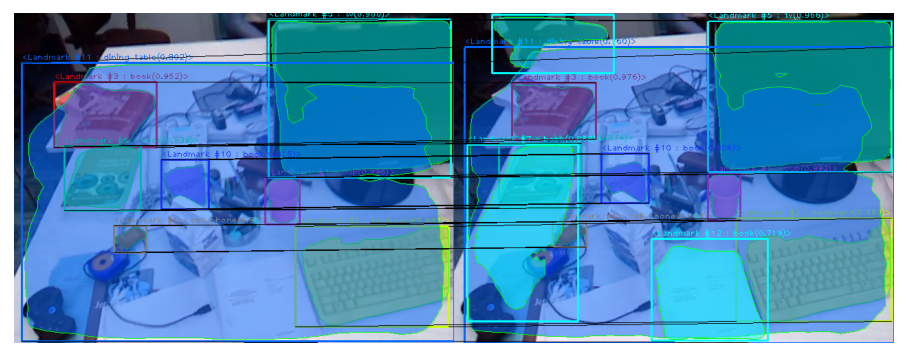

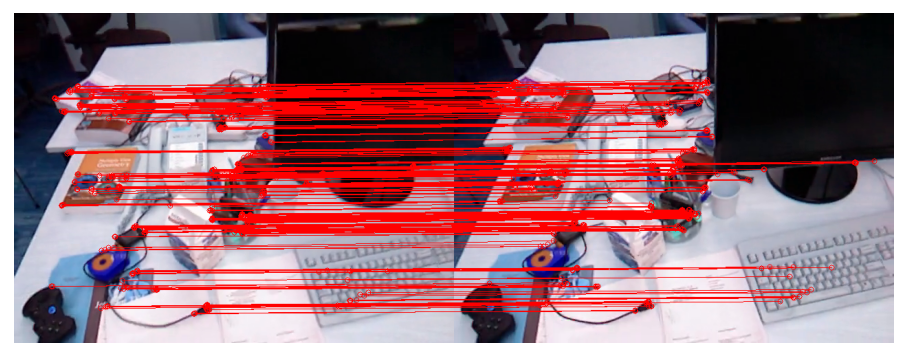

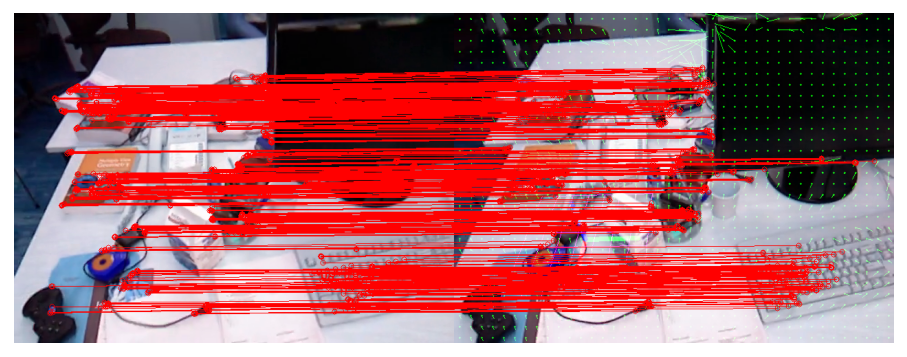

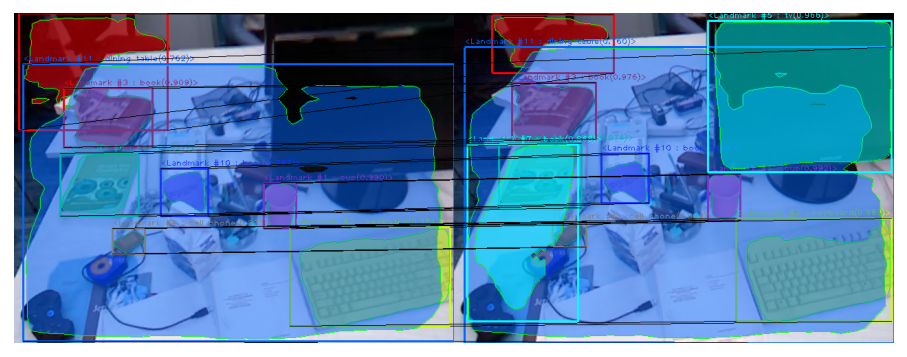

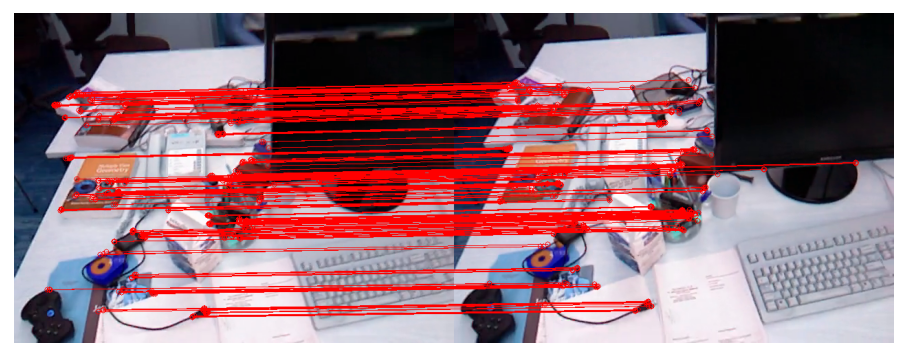

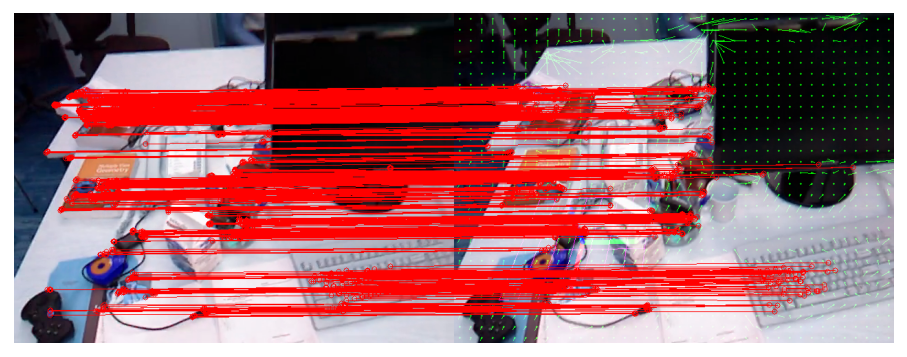

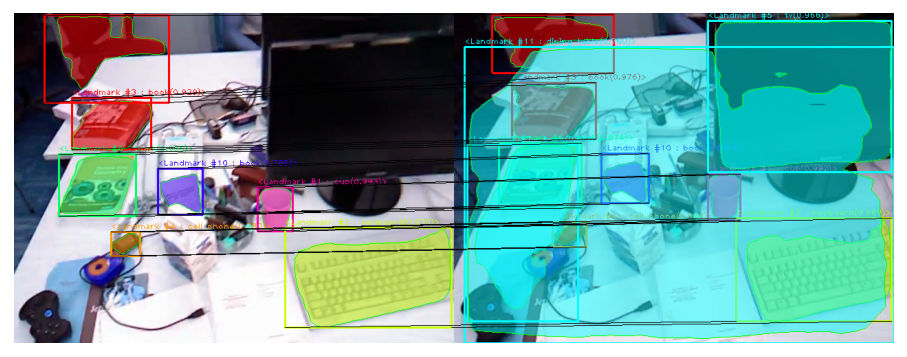

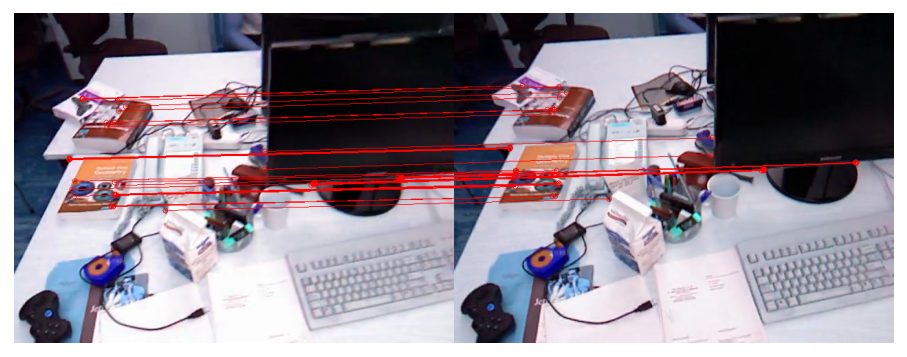

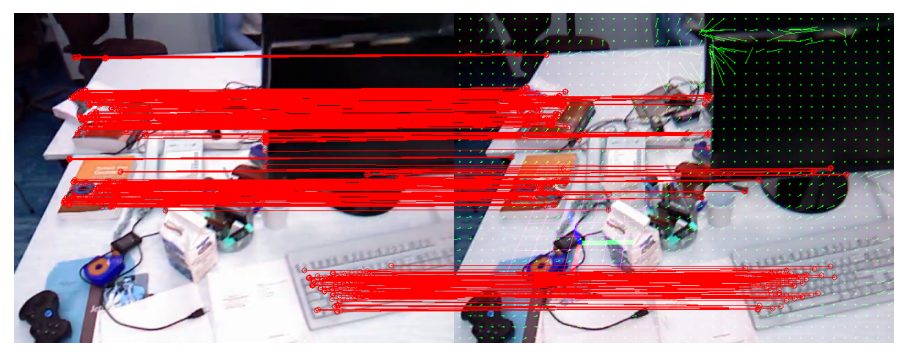

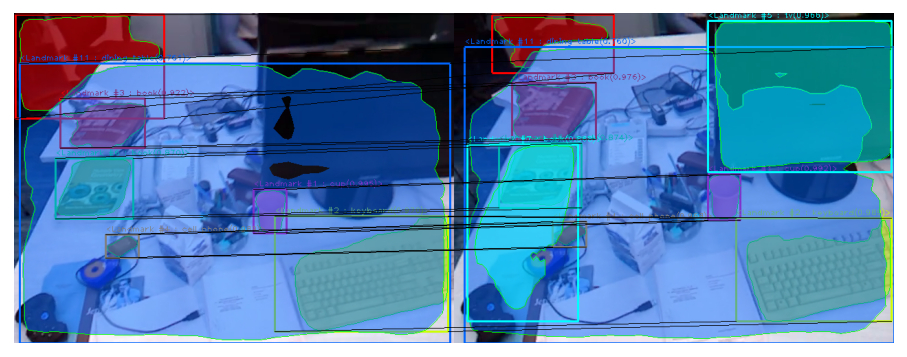

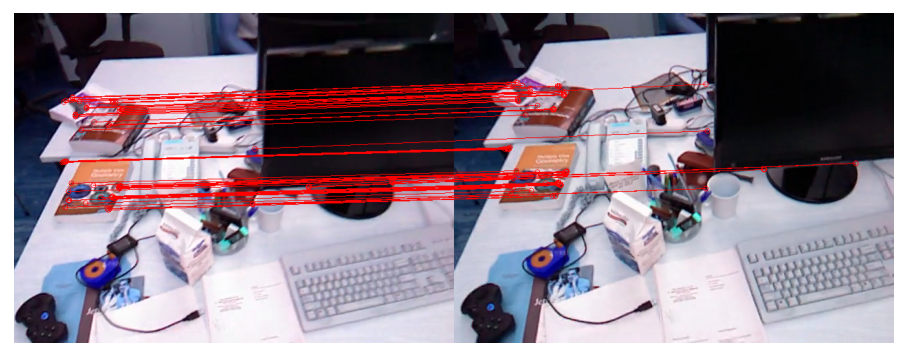

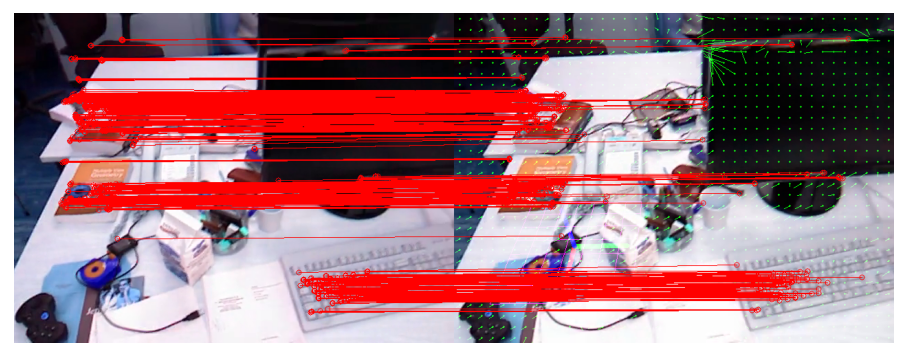

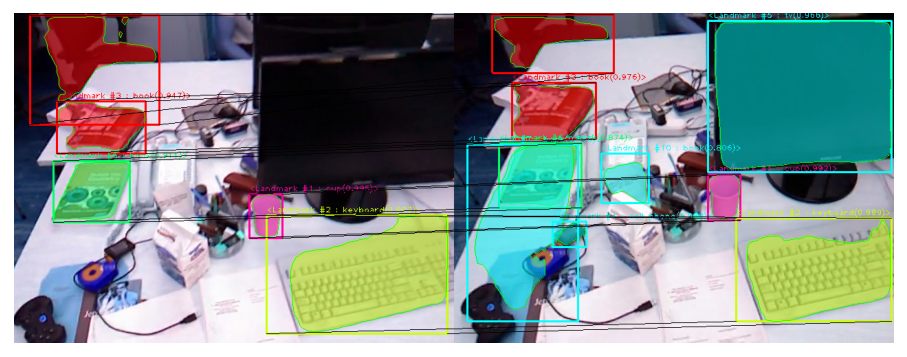

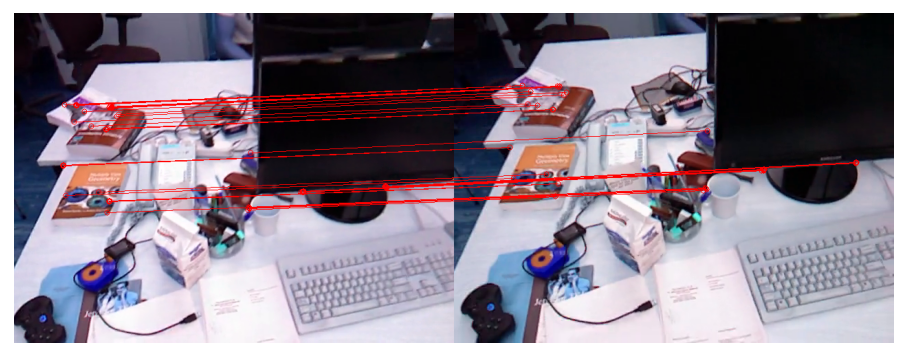

2020-05-25 11:44:12,663 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 669 >> PCViewer [GL Process] get a datum from the main thread of the parent process
2020-05-25 11:44:12,762 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 680 >> PCViewer [GL Process] update camera pose matrix got from datum: 
[[-0.01   0.672 -0.74   1.246]
 [ 1.    -0.015 -0.027  0.628]
 [-0.029 -0.74  -0.672  1.593]
 [ 0.     0.     0.     1.   ]]
2020-05-25 11:44:12,764 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 708 >> PCViewer [GL Process] drawing a camera with new pose matrix ...


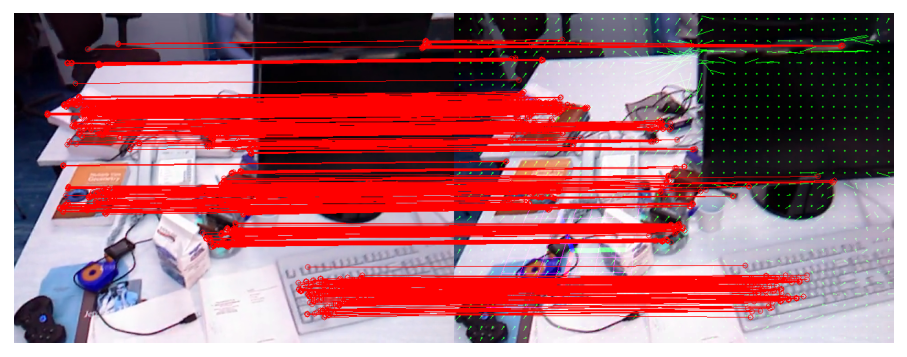

2020-05-25 11:44:13,017 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 763 >> PCViewer [GL Process] datum has been processed.
2020-05-25 11:44:14,524 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 667 >> PCViewer [GL Process] attributes is not empty, fetching datum ...
2020-05-25 11:44:14,527 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 669 >> PCViewer [GL Process] get a datum from the main thread of the parent process
2020-05-25 11:44:14,528 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 680 >> PCViewer [GL Process] update camera pose matrix got from datum: 
[[-0.01   0.672 -0.74   1.246]
 [ 1.    -0.015 -0.027  0.628]
 [-0.029 -0.74  -0.672  1.593]
 [ 0.     0.     0.     1.   ]]
2020-05-25 11:44:14,529 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 703 >> PCViewer [GL Process] drawing 1 lines ...
2020-05-25 11:44:14,529 [INFO]:<ipython-input-158-c5592810f5bf>.PCViewer, in line 708 >> PCViewer [GL Process] drawing a camera with

In [159]:
import cv2
import numpy as np
from skimage.measure import find_contours
import logging
from io import StringIO
import sys
# logging.basicConfig(level=logging.INFO,
#                     format=u"%(asctime)s [%(levelname)s]:%(filename)s.%(name)s, in line %(lineno)s >> %(message)s".encode('utf-8'))
# logging.basicConfig(level=logging.INFO)

# create stream handler and add it to root logger, otherwise your logging in the colab won't work
console = logging.StreamHandler(stream=sys.stdout)

root = logging.getLogger()
for handler in root.handlers:
  root.removeHandler(handler)

fmt = logging.Formatter("%(asctime)s [%(levelname)s]:%(filename)s.%(name)s, in line %(lineno)s >> %(message)s")
console.setFormatter(fmt)
console.setLevel(logging.INFO)
root.addHandler(console)

# The codes have been deprecated in favor of new implementation of WebImageRenderer
def save_instances(image, boxes, masks, class_ids, class_names, scores):
  n_instances = boxes.shape[0]
  colors = visualize.random_colors(n_instances)
  
  if not n_instances:
    print("No instances to display!")
  else:
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    
  masked_image = image.copy()
  for i in range(n_instances):
    color = colors[i]
    
    # Bounding box
    if not np.any(boxes[i]):
      # Skip this instance. Has no bbox. Likely lost in image cropping.
      continue
    
    y1, x1, y2, x2 = boxes[i]
    mask = masks[:, :, i]
    
    class_id = class_ids[i]
    score = scores[i]
    label = class_names[class_id]
    
    if label is not 'person':
      continue;
    
    caption = "{} {:.3f}".format(label, score) if score else label
    
    masked_image = visualize.apply_mask(masked_image, mask, color)
    masked_image_with_boxes = cv2.rectangle(masked_image, (x1, y1), (x2, y2), color, 2)
    
    # Mask Polygon
    padded_mask = np.zeros(
      (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8
    )
    padded_mask[1:-1, 1:-1] = mask
    # contours = find_contours(padded_mask, 0.5)
    _, contours, _ = cv2.findContours(padded_mask, 
cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    masked_image_with_contours_plus_boxes = cv2.drawContours(masked_image_with_boxes, contours, -1, (0, 255, 0), 1)
    
    out = cv2.putText(
      masked_image_with_contours_plus_boxes, caption, (x1, y1-2), cv2.FONT_HERSHEY_COMPLEX, 1.2, color, 2
    )
    
    masked_image = out
  return out
  

VIDEO_DIR="{project_base}/log/video".format(project_base=Project_base)
OUTPUT=VIDEO_DIR
SAVER=os.path.join(OUTPUT, "saver")

import os

if not os.path.isdir(SAVER):
  os.makedirs(SAVER)

capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, "freiburg1_xyz.mp4"))

batch_size = 1 # 10 GB GPU, which can fit 1 image, i.e. your batch should be set to 1. In the future I will develop a dynamic porgrame to decide this value using CUDA compute capability api intelligently.
# frames = []

# construct a map block, where typically raw map data should be read from this point
block = RuntimeBlock()
block.load_device("{project_base}/data/tum/camera1.yaml".format(project_base=Project_base))

# initialize a tracker
tracker = SVSOTracker().set_FromMap(block)

# set ground truth we loaded before
tracker.trajectories_gt = trajectories

# set depth images
DRAW_ONCE = False
tracker.depth_images = depth_images

# clear onehot encoder cache
SemanticFeatureExtractor.oneHotEncoder = None

# viewer
viewer = PCViewer()
viewer.set_FromTracker(tracker)
viewer.set_FromMap(block)
# viewer.Init()
viewer.Start()
print("[Main Thread] viewer: ", viewer)
print("\n\n")

cnt = 0
cnt0 = 0

STOP_FRAMES = 200
TRACKED_FRAMES = 6

STEP = 10

# ORBSLAM2 first successfully triangulated frame no: #91

while True:
  ret, frame = capture.read()
  if not ret:
    break
  
  timestamp = float(timestamps[cnt][0])
  file_name = timestamps[cnt][1]
  
  cnt += 1
  if cnt % STEP != 1:
    # comment this line if you want track images continuously
    pass
    # continue

  if cnt < 55:
    continue

  # @todo : TODO fix encoding error
  logging.info("exec tracker to track motions: %d" % cnt)
  # Hybrid of OpticalFlow and Kalman Filter predictor & deep features based Hungarian algorithm implementation, Updated on Feb 26 2020 by Author Lei Wang
  # tracker.track(frame)
  tracker.track(frame, timestamp=timestamp)
  cnt0 += 1
       
  ### Deprecated codes, in favor of new implementation of WebImagaRenderer ###
  # offline task 
  if tracker.cur is None or not hasattr(tracker.cur, "rendered_img") or tracker.cur.rendered_img is None:
    logging.info("skipping rendered_img at Frame#%d ..." % tracker.cur.seq)
    continue
  
  if not tracker.cur.is_First and tracker.cur.isKeyFrame:
    if tracker.cur.depth_img is not None and not DRAW_ONCE:
      viewer.drawDepthImage(tracker.cur)
      DRAW_ONCE = True
    logging.info("Updating point cloud viewer at KeyFrame %s" % tracker.cur)
    viewer.Update()
    logging.info("Point cloud viewer updated at KeyFrame %s" % tracker.cur)
    
  # rets = model.detect([tracker.last_frame.img], verbose=1)
  # r = rets[0]
  # visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
  # out_frame = save_instances(tracker.last_frame.img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
  
  name = os.path.join(SAVER, "images/{}.jpg".format(cnt))
  if tracker.last_frame is None or not hasattr(tracker.last_frame, "rendered_img") or tracker.last_frame.rendered_img is None:
    out_frame = tracker.cur.rendered_img 
  else:
    out_frame = cv2.add(tracker.last_frame.rendered_img, tracker.flow_mask)
  cv2.imwrite(name, out_frame)
  
  if cnt >= STOP_FRAMES:
    logging.info("break after %d frames" % STOP_FRAMES)
    break

  if cnt0 >= TRACKED_FRAMES:
    logging.info("break after %d frames tracked" % TRACKED_FRAMES)
    break
  
  if tracker.isInitalized():
    continue

capture.release()
# viewer.Stop()

In [ ]:
SAVER=os.path.join(Project_base, "video/saver")
print(SAVER)

In [ ]:
!pwd
!ls ./video/saver

In [ ]:
!rm ./video/saver/out.mp4
!rm ./video/saver/out.avi

import cv2
import glob

labeled_images = list(glob.iglob(os.path.join(SAVER, "*.jpg")))
labeled_images = sorted(labeled_images, key=lambda x: int(os.path.split(x)[1].split('.')[0]))
figsize = (16, 16)
_, ax = plt.subplots(1, figsize=figsize)
im = cv2.imread(labeled_images[200])
height, width = im.shape[:2]
size=(width, height)
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')
ax.imshow(im.astype(np.uint8))

##### Check the FPS to be used

The parameter will be used inside `cv2.VideoWriter` to compose an output video from generated images.

In [ ]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'homework.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

##### Generate Video with OpenCV2

I extracted some useful [comments](https://github.com/ContinuumIO/anaconda-issues/issues/223) by Github user \<jveitchmichaelis\>

- Only use '.avi', it's just a container, the codec is the important thing.
- Be careful with specifying frame sizes. In the constructor you need to pass the frame size as (column, row) e.g. 640x480. However the array you pass in, is indexed as (row, column). See in the above example how it's switched?
- If your input image has a different size to the VideoWriter, it will fail (often silently)
- Only pass in 8 bit images, manually cast your arrays if you have to (.astype('uint8'))
- In fact, never mind, just always cast. Even if you load in images using cv2.imread, you need to cast to uint8...
- MJPG will fail if you don't pass in a 3 channel, 8-bit image. I get an assertion failure for this at least.
- XVID also requires a 3 channel image but fails silently if you don't do this.
- H264 seems to be fine with a single channel image
- If you need raw output, say from a machine vision camera, you can use 'DIB '. 'RAW ' or an empty codec sometimes works. Oddly if I use DIB, I get an ffmpeg error, but the video is saved fine. If I use RAW, there isn't an error, but Windows Video player won't open it. All are fine in VLC.

My personal experience is that you need to make sure that size is in the ordier (img.shape[1], img.shape[0]). And image should be RBG images not a  single binary image is allowed.

In [ ]:
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize

fourcc = VideoWriter_fourcc(*'MJPG')
outputfn = os.path.join(SAVER, "out.avi")
fps = 24 # reset manually

vw = VideoWriter(outputfn, fourcc, float(fps), size)

print("the size of images is : {}".format(size))

for im in labeled_images:
  im = cv2.imread(im)
  height, width, channel = im.shape
  assert channel == 3
  if size[0] != im.shape[1] or size[1] != im.shape[0]:
    im = resize(im, size)
  vw.write(im.astype(np.uint8))

cv2.destroyAllWindows()
vw.release()
print(vw)

##### Using FFMpeg

FFMpeg is fast software used for images processing. We could use its binaries and libraries to process images such like converting sequences of images to a video.

In [ ]:
# you can also generate the video using FFmpeg 
def save():
    os.system("ffmpeg -r 24 -i '{input_dir}/%d.jpg' -vcodec mpeg4 -y {output_dir}".format(input_dir=SAVER, output_dir=os.path.join(SAVER, "out.mp4")))

!echo $SAVER/out.mp4
# save()
!ffmpeg -r 24 -i '$SAVER/%d.jpg' -vcodec mpeg4 -y $SAVER/out.mp4
!ls $SAVER/*.mp4 -h

##### Ouput to local system

In [ ]:
from google.colab import files
files.download(os.path.join(SAVER, "out.mp4"))

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open(os.path.join(SAVER, "out.mp4"), 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4">
             </video>'''.format(encoded.decode('ascii')))